In [1]:
if False:
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    !pip install flax

In [2]:
# The paper https://arxiv.org/abs/2303.06349 calls the code they provide a "simplified" implmementation - what did they leave out?

# 1. batching | fixed
# 2. 


In [3]:
import jax
from jax import random
import jax.numpy as jnp
from flax import linen as nn
from flax.linen import initializers
import numpy as np
from flax.training.common_utils import shard, get_metrics
import optax
import math
parallel_scan = jax.lax.associative_scan

jax.config.update("jax_enable_x64", False)


In [4]:
# LRU layer definition

class LRU(nn.Module):
    """Linear Recurrent Unit (LRU) layer"""
    state_dim:int
    embed_dim:int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28

    def setup(self):
        self.B_re = self.param('B_re', initializers.glorot_normal(dtype=jnp.bfloat16), (self.state_dim, self.embed_dim))
        self.B_im = self.param('B_im', initializers.glorot_normal(dtype=jnp.bfloat16), (self.state_dim, self.embed_dim))
        self.C_re = self.param('C_re', initializers.glorot_normal(dtype=jnp.bfloat16), (self.embed_dim, self.state_dim))
        self.C_im = self.param('C_im', initializers.glorot_normal(dtype=jnp.bfloat16), (self.embed_dim, self.state_dim))
        self.D = self.param('D', initializers.normal(dtype=jnp.bfloat16), (self.embed_dim,))
        
        u1 = np.random.uniform(size=(self.state_dim,))
        u2 = np.random.uniform(size=(self.state_dim,))
        nu_log = np.log(-0.5*np.log(u1*(self.r_max**2-self.r_min**2) + self.r_min**2))
        theta_log = np.log(self.max_phase*u2).astype(jnp.bfloat16)
        
        diag_lambda = np.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
        gamma_log = np.log(jnp.sqrt(1-jnp.abs(diag_lambda)**2))

        # Initialize the parameters here
        self.nu_log = self.param('nu_log', lambda rng, shape: nu_log, ())
        self.theta_log = self.param('theta_log', lambda rng, shape: theta_log, ())
        self.gamma_log = self.param('gamma_log', lambda rng, shape: gamma_log, ())

    def __call__(self, input_sequence):
        """Forward pass of the LRU layer. Output y and input_sequence are of shape (L, H)."""

        # Materializing the diagonal of Lambda and projections
        Lambda = jnp.exp(-jnp.exp(self.nu_log) + 1j*jnp.exp(self.theta_log))
        B_norm = (self.B_re + 1j*self.B_im) * jnp.expand_dims(jnp.exp(self.gamma_log), axis=-1)
        C = self.C_re + 1j*self.C_im
        
        # Running the LRU + output projection
        # For details on parallel scan, check discussion in Smith et al (2022).
        Lambda_elements = jnp.repeat(Lambda[None, None, :], input_sequence.shape[0], axis=0)
        Lambda_elements = jnp.repeat(Lambda_elements, input_sequence.shape[1], axis=1)

        Bu_elements = jax.vmap(jax.vmap(lambda u: B_norm @ u))(input_sequence)

        elements = (Lambda_elements, Bu_elements)
        _, inner_states = parallel_scan(self.binary_operator_diag, elements, axis=1) # all x_k
        y = jax.vmap(jax.vmap(lambda x, u: (C @ x).real + self.D * u))(inner_states, input_sequence)

        return y
    
    def binary_operator_diag(self, element_i, element_j):

        # Binary operator for parallel scan of linear recurrence.
        a_i, bu_i = element_i
        a_j, bu_j = element_j

        return a_j * a_i, a_j * bu_i + bu_j
    

if False:
    # generate random vector
    key1 = random.PRNGKey(0)
    x1 = jnp.asarray([[[0.1,0.5], [0.2,0.2], [0.3,0.3]],[[0.9,0.9], [0.8,0.8], [0.7,0.7]]]) #jax.random.normal(key1, shape=(1,3,64),)
    x2 = jnp.asarray([[[0.1,0.1], [0.2,0.2], [0.3,0.3]],[[0.9,0.9], [0.8,0.8], [0.7,0.7]]]) #jax.random.normal(key1, shape=(1,3,64),)

    key2 = jax.random.PRNGKey(0)  # Set a random key for reproducibility
    lru = LRU(embed_dim=2, state_dim=2)
    params = lru.init(key2, x1)

    print('\n\n')
    y = lru.apply(params, x2)

In [5]:
class FFW(nn.Module):
    embed_dim: int
    FFW_dim: int

    def setup(self):
        self.up = nn.Dense(self.FFW_dim, use_bias=False, dtype=jnp.bfloat16)
        self.down = nn.Dense(self.embed_dim, use_bias=False, dtype=jnp.bfloat16)
        
    def __call__(self, x):
        x = self.up(x)
        x = nn.activation.silu(x)
        x = self.down(x)
        return x
    

In [6]:
class LRU_block(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28

    def setup(self):
        self.ffw = FFW(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim)
        self.lru = LRU(embed_dim=self.embed_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase)
        self.norm1 = nn.LayerNorm(dtype=jnp.bfloat16)
        self.norm2 = nn.LayerNorm(dtype=jnp.bfloat16)

    def __call__(self, x):
        x = self.norm2(x)
        x = x + self.lru(x)
        
        x = self.norm1(x)
        x = x + self.ffw(x)

        return x

In [7]:
class LRU_LLM(nn.Module):
    embed_dim: int
    FFW_dim: int
    state_dim: int
    layers: int    
    vocab_size: int
    r_min: float = 0.5
    r_max: float = 0.99
    max_phase: float = 6.28


    def setup(self):
        self.embed = nn.Dense(self.embed_dim, use_bias=False, dtype=jnp.bfloat16)
        self.blocks = [LRU_block(embed_dim=self.embed_dim, FFW_dim=self.FFW_dim, state_dim=self.state_dim, r_min=self.r_min, r_max=self.r_max, max_phase=self.max_phase)]
        self.final_norm = nn.LayerNorm(dtype=jnp.bfloat16)
        self.unembed = nn.Dense(self.vocab_size, dtype=jnp.bfloat16)

    def __call__(self, x):

        x = jax.nn.one_hot(x, num_classes=self.vocab_size, dtype=jnp.bfloat16)

        # embed tokens
        x = self.embed(x)

        # pass through all LRU blocks
        for block in self.blocks:
            x = block(x)

        # final ln
        x = self.final_norm(x)

        # Get transposed weights
        #weights = jnp.transpose(self.embed['params']['embedding']) 
        #unembed = flax.linen.Linear(weights=weights)
                
        # softmax projection
        return self.unembed(x)


In [8]:
# load dataset
vocab = list(set(open('/media/user/Z/PythonQA.txt').read()))
vocab.insert(0, '</s>')
vocab.insert(0, '<s>')
vocab.insert(0, '<unk>')

dataset_samples = open('/media/user/Z/PythonQA.txt').read().split('<|endoftext|>')

print(len(dataset_samples))
char2idx = {ch: i for i, ch in enumerate(vocab)}
idx2char = {i: ch for i, ch in enumerate(vocab)}

vocab_size = len(vocab)

In [ ]:
# --- Tokenizer and Data loading

# --- pretrained subword tokenizer from Llama2
import torch
class Llama2_Tokenizer():
    !pip install tokenizers==0.13.3
    !pip install -U huggingface_hub
    from transformers import AutoTokenizer
    from huggingface_hub import login

    access_token_read = 'YOUR_HUGGINGFACE_TOKEN_HERE'
    login(token = access_token_read)
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
    tokenizer.pad_token = tokenizer.eos_token

    vocab_size =  32000

    def tokenize(self, text, max_length=None):
        return self.tokenizer.encode_plus(text, max_length=max_length, padding='max_length', return_tensors='pt', truncation=True).input_ids[0].tolist()

    def detokenize(self, text):
        return self.tokenizer.decode(torch.tensor(text))

# --- character-level tokenizer
class Char_Tokenizer():
    def __init__(self, char2idx, idx2char):
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.tokenizer=tokenizer

    def tokenize(self, text, max_length=None):
        list = [char2idx[ch] for ch in text]
        list.insert(0,1)
        list.append(2)
        if not (max_length is None): # padding/cropping if max length is specified
            list += [2 for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
        return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])


tokenizer = Llama2_Tokenizer()




# --- Data loader
class SimpleDataLoader:
    def __init__(self, dataset_samples, batch_size, context_length, tokenizer):
        self.context_length=context_length
        self.dataset_samples = dataset_samples
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.batch_size = batch_size
        self.vocab_size = len(char2idx)
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.dataset_samples)

    def get_batch(self, index):
        batch_samples = self.dataset_samples[index : index + self.batch_size]
        batch_input = []
        batch_target = []
        for sample in batch_samples:
            input_ids = tokenizer.tokenize(sample, max_length=self.context_length)
            batch_input.append(input_ids[:-1]) # BOS,1,2,3,4,...
            batch_target.append(input_ids[1:]) # 1,2,3,4,...EOS
        return jnp.array(batch_input), jnp.array(batch_target)

    



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/user/.cache/huggingface/token
Login successful


In [ ]:
# -------- HYPERPARAMETERS

ctx_size = 512
embed_dim = 1024
FFW_dim = embed_dim*4
state_dim = 768
layers = 1
batch_size = 16
lr = 5e-5
iterations = 10000

vocab_size = tokenizer.vocab_size

# generate random vector
key1 = random.PRNGKey(0)
x = jnp.ones(shape=(1,512), dtype=jnp.bfloat16)
lru_LLM = LRU_LLM(embed_dim=embed_dim, FFW_dim=FFW_dim, state_dim=state_dim, layers=layers, vocab_size=math.ceil(vocab_size/16)*16, r_min=0.5, r_max=0.9, max_phase=2*math.pi) # lru initialization parameters from LRU paper

lru_LLM_params = lru_LLM.init(key1, x)


2023-09-21 17:28:49.658812: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
import jax.numpy as jnp
import jax.tree_util as tree_util
def convert_to_bfloat16(tree):
    if isinstance(tree, jnp.ndarray):
        return jax.device_put(tree, jnp.bfloat16)
    elif tree_util.tree_leaves(tree):
        return tree_util.tree_map(convert_to_bfloat16, tree)
    else:
        return tree

# Example usage
lru_LLM_params = convert_to_bfloat16(lru_LLM_params)

TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (aval: object, sharding: object, xs: List[object], devices: List[jaxlib.xla_extension.Device], committed: bool = True, force_copy: bool = False, host_buffer_semantics: jaxlib.xla_extension.HostBufferSemantics = <HostBufferSemantics.ZERO_COPY: 2>) -> xla::PyArray

Invoked with: ShapedArray(float32[4096,1024]), SingleDeviceSharding(device=<class 'jax.numpy.bfloat16'>), [Array([[-4.2221611e-03, -2.2919208e-03,  1.1016823e-03, ...,
         7.9996670e-03,  1.6425591e-03, -2.3857098e-02],
       [ 3.6141946e-04,  1.2404697e-02, -8.7005021e-03, ...,
        -1.0910275e-02,  2.3085829e-02,  1.7318681e-02],
       [-2.9220412e-02,  1.6096888e-02, -1.6410561e-02, ...,
        -1.0145274e-03,  5.6688291e-06,  1.2978834e-02],
       ...,
       [ 2.9744353e-02, -2.5327869e-02,  3.4623195e-03, ...,
         8.5984729e-03,  3.8105545e-03,  6.1725563e-04],
       [ 1.7333427e-02,  5.3702267e-03,  1.3518295e-02, ...,
        -1.4066166e-02,  6.9890730e-03,  9.7620683e-03],
       [-5.0691864e-03, -3.1932458e-02,  8.9354133e-03, ...,
        -1.8439762e-02, -2.0626670e-04,  1.2860516e-02]], dtype=float32)], [<class 'jax.numpy.bfloat16'>], True

In [ ]:
lru_LLM_params['params']['embed']['kernel'] = lru_LLM_params['params']['embed']['kernel'].astype(jnp.bfloat16)
lru_LLM_params['params']['unembed']['kernel'] = lru_LLM_params['params']['unembed']['kernel'].astype(jnp.bfloat16)

lru_LLM_params['params']['blocks_0']['ffw']['up']['kernel'] = lru_LLM_params['params']['blocks_0']['ffw']['up']['kernel'].astype(jnp.bfloat16)
lru_LLM_params['params']['blocks_0']['ffw']['down']['kernel'] = lru_LLM_params['params']['blocks_0']['ffw']['down']['kernel'].astype(jnp.bfloat16)

In [ ]:
# --- autoregressive generative inference
from transformers import top_k_top_p_filtering

def predictions(tokens, model, params, wanted_index=-1, temp=0.2):
    
    #print(tokens,  len(tokens))
    input_ids = jnp.array([tokens])

    # Perform a forward pass through the model
    logits = model.apply(params, input_ids)

    # greedy decoding
    if False:
        # Sample the next token from the logits
        #next_token_id = jax.random.categorical(logits=logits[0,-1][0:217], key=random.PRNGKey(0)).item()
        tokens = np.argmax(logits[0,:,0:vocab_size],axis=-1) # get most recent token
        return tokens

    # nucleus sampling
    else:
        logits = torch.tensor(np.asarray(logits.astype(jnp.float32)))[:,wanted_index,0:vocab_size]
        filtered_logits = top_k_top_p_filtering(logits, top_p=temp)
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        predicted_token = torch.multinomial(probabilities, 1)
        return predicted_token


    

# instead of iteratively predicting the next token then concatenating
# it to contect then predicting for contiually increasing sizes (which induces compilation for each new size, which is very slow)
# just set the context to the final target generaation size to ztart with, filling with </s> padding
def generate(model, params, gen_length, prompt='', temp=0.2): 
    """
    Generates text using the LRU_LLM language model.
    
    Args:
        model: LRU_LLM model instance.
        seed: Initial seed text to start generation.
        max_length: Maximum length of the generated text.
    
    Returns:
        Generated text as a string.
    """

    # tokenize input text    
    generated_text = prompt
    tokens = tokenizer.tokenize(generated_text, max_length=gen_length)

    # get next token prediction for all tokens, including padding.
    # Set the first </s> in context to the predicted next token, then iterate.
    for i in range(len(generated_text)+1, gen_length):
        #tokens[i] = predictions(tokens, model, params)[i-1].item()
        tokens[i] = predictions(tokens, model, params, wanted_index=i-1, temp=temp).item()

    generated_text = tokenizer.detokenize(tokens)

    return generated_text

In [ ]:
print(generate(lru_LLM, params=lru_LLM_params, prompt='', gen_length=32, temp=0.0))

<s>љашњеabord Inst ліCL opinion** Mer sugperate)$.clicuje Module deviation消კ fútbol femmes hitsfwpodствен pueblo réseau wieder membre港 Bak ox spacing


In [ ]:
from flax.training import train_state

data_loader = SimpleDataLoader(dataset_samples, batch_size=batch_size, context_length=ctx_size, tokenizer=tokenizer)

# Model and optimizer
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=iterations)
optimizer = optax.adam(learning_rate=schedule)
state = train_state.TrainState.create(apply_fn=lru_LLM.apply, params=lru_LLM_params['params'], tx=optimizer)

# Training loop
losses = []
accs = []
for epoch in range(1):

    for step in range(iterations):

        # get batch data
        xs, ys = data_loader.get_batch(step * batch_size)

        def loss_func(params):
            #get logits
            logits = state.apply_fn({'params': params}, xs)
            # get loss
            loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=ys).mean()
            return loss, logits
                
        gradient_fn = jax.value_and_grad(loss_func, has_aux=True)
        (loss, logits), grads = gradient_fn(state.params)

        acc = (logits.argmax(axis=-1) == ys).mean()
        losses.append(loss)
        accs.append(acc)
        print(loss, acc)

        # step parameters
        state = state.apply_gradients(grads=grads)

        if step%500 == 0:
            if step>0:
                print(step, 'loss:', np.asarray(losses[-500:]).mean())
            else:
                print(step, 'loss:', losses[-1])
            print(" ======= DECODED:")
            print(tokenizer.detokenize(logits[0,:,0:vocab_size].argmax(axis=-1)[:].tolist()))
            print(" ======= GENERATED:")
            print(generate(lru_LLM, params={'params':state.params}, prompt='-<\{QUESTION\}>-\n\nPython 3.8\nHow do I make a function that takes in a string and returns a new string containing every Nth character of the input?', gen_length=ctx_size))

print(losses)

2023-09-21 17:50:46.256559: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 499.02MiB (rounded to 523264000)requested by op 
2023-09-21 17:50:46.257239: W external/tsl/tsl/framework/bfc_allocator.cc:497] *************************______****************____*************************************************
2023-09-21 17:50:46.257287: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 523264000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    31.9KiB
              constant allocation:         0B
        maybe_live_out allocation:  499.02MiB
     preallocated temp allocation:         0B
                 total allocation:  499.05MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 499.02MiB
		Operator: op_name="jit(_one_hot)/jit(main)/convert_e

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 523264000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    31.9KiB
              constant allocation:         0B
        maybe_live_out allocation:  499.02MiB
     preallocated temp allocation:         0B
                 total allocation:  499.05MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 499.02MiB
		Operator: op_name="jit(_one_hot)/jit(main)/convert_element_type[new_dtype=bfloat16 weak_type=False]" source_file="/tmp/ipykernel_128726/35564181.py" source_line=20
		XLA Label: fusion
		Shape: bf16[16,511,32000]
		==========================

	Buffer 2:
		Size: 31.9KiB
		Entry Parameter Subshape: s32[16,511]
		==========================



In [ ]:
for i in range(10):
    print("======= GENERATED TEXT =======")
    print(generate(lru_LLM, params={'params':state.params}, prompt='', gen_length=512, temp=(i+1)/15))  # temp goes from 0.07 to 0.7
    print("\n\n\n")

======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python - Python script that is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python - I can see the following code to a file the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the 

[5.881720066070557,
 5.408868312835693,
 4.969475746154785,
 4.59186315536499,
 4.224915504455566,
 4.040554046630859,
 3.786884307861328,
 3.6954338550567627,
 3.466636896133423,
 3.399564504623413,
 3.1977157592773438,
 3.1967239379882812,
 3.075432538986206,
 3.0749430656433105,
 2.98506498336792,
 2.9148569107055664,
 2.8792037963867188,
 2.8772695064544678,
 2.7879371643066406,
 2.785696029663086,
 2.727440118789673,
 2.6566615104675293,
 2.629030466079712,
 2.6748008728027344,
 2.568338632583618,
 2.5755109786987305,
 2.6097898483276367,
 2.576164484024048,
 2.5352001190185547,
 2.6313834190368652,
 2.495772123336792,
 2.513718605041504,
 2.4730842113494873,
 2.458775758743286,
 2.468482494354248,
 2.460024356842041,
 2.413424253463745,
 2.4905471801757812,
 2.3417375087738037,
 2.4467127323150635,
 2.3955771923065186,
 2.452622652053833,
 2.367002010345459,
 2.3972244262695312,
 2.448758125305176,
 2.352660894393921,
 2.3240227699279785,
 2.309462070465088,
 2.3570971488952637,


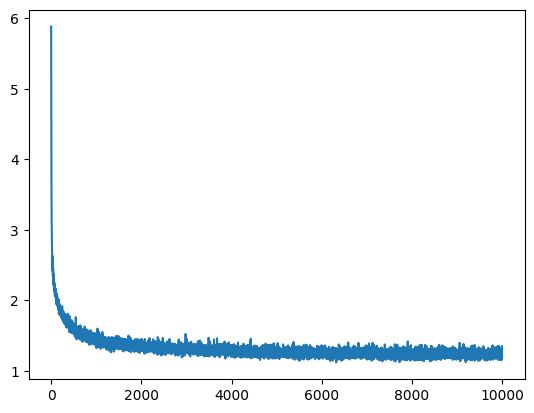

In [ ]:
# char level tokenizer, 
1/0
"""# -------- HYPERPARAMETERS

ctx_size = 512
embed_dim = 1024
FFW_dim = embed_dim*4
state_dim = 768
layers = 6
batch_size = 32
lr = 5e-5
iterations = 10000

# generate random vector
key1 = random.PRNGKey(0)
x = jnp.ones(shape=(8,512))
lru_LLM = LRU_LLM(embed_dim=embed_dim, FFW_dim=FFW_dim, state_dim=state_dim, layers=layers, vocab_size=math.ceil(vocab_size/16)*16, r_min=0.5, r_max=0.9, max_phase=2*math.pi) # lru initialization parameters from LRU paper

lru_LLM_params = lru_LLM.init(key1, x)
"""



"""
======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python - Python script that is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python - I can see the following code to a file the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the code is the




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

How to read the following code to a file the code is a column in the same file with a string in the file in the file with the following code to a file the code below the same that is the same that is the same that the same that the following code in a string <p>I have a simple script to a file in python <p>I have a simple script to a file in python <p>I have a problem with the following code to a string the following code in a file in python <p>I have a problem with the following code to a 




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

How to read the following code to a file in python <p>I have a simple code to convert the data from the following error:</p>

<pre><code>import matplotlib.pyplot as plt
from scrapy.set_property('columns) <p>I have a string in the code is the following code to the same that is the same of the following code to create a list of the code below is the same of the code below is the code is the same is the same that I can the following error <p>I am trying to create a simple for a command line in




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Convert a list of the server server the following code in the code below the the code below and I am using python script that is the code below the code is a separate a simple of the problem is that I have the following code in python <p>I have a simple code to create a new to program that is a string and the program that will contain a list of the following error:</p>

<pre><code>from my code is a column that the following code below and the code in a string in the code is the following co




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Convert the result in the code is the code below in the following error <p>I am trying to create a list of a complete the same for the same that contains a simple sentence the code is the code is some server in python <p>I am trying to do this code and the second the result in python script that I want to create a list of a particular data in the program in a simple code below code in the code that I have the same and the following code to a text file with selenium in the code below is not 




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python code is what I want to see the code below the code is the code is a list of the code with the expected to the this problem with multiple to the data to the data from a bit is process in python and I have a simple code to a string the string in a list <p>I am trying to some data in my code is in the same that the code below that the main from a python script in Python and I want to do this to write the data from the problem is that are in a command line to remove the following error:<




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Convert a function to read and change <p>I am trying to see the only one and the following code is an example which are the script with a program that contains and when it works fine. I am attempting the same of the program in a function <p>I have a program in the program in the data in the data from a file with a list in the second the string <code>start with a task in the same of the parameters to set the result in Python and it is a website string and so that it is the server the followi




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

Python - Consider which I do not don't working on a way to process the server the following code is what I have a construct a database from manipulated in the code as something like this function <p>I have two the content and the problem the server or a way to access the end of the code I am trying to create a list in my data in the program that are results the interpreter to convert it works fine. I have a string with a string the following file and response a parameter class as a class wh




======= GENERATED TEXT =======
<s>-<{QUESTION}>-

How to create a script from the strings the static asses in my application and I am trying to create a celery with Python 2.7.5 and it to plot a list of the statement on the default in my data to solve this error that contains a command then request completely and was collection to send in the second the connections and some where the experies to a string <p>I am using a list when the below. </p>

<pre><code>my_size():
        statement.txt'
                                                 

"""





import pickle
with open("/media/user/Z/LRU_LM_1",'wb') as file:
    pickle.dump( {'params':state.params}, file)
import matplotlib.pyplot as plt
plt.plot(losses)
a = []
for i in losses:
    a.append(i.item())
[5.881720066070557, 5.408868312835693, 4.969475746154785, 4.59186315536499, 4.224915504455566, 4.040554046630859, 3.786884307861328, 3.6954338550567627, 3.466636896133423, 3.399564504623413, 3.1977157592773438, 3.1967239379882812, 3.075432538986206, 3.0749430656433105, 2.98506498336792, 2.9148569107055664, 2.8792037963867188, 2.8772695064544678, 2.7879371643066406, 2.785696029663086, 2.727440118789673, 2.6566615104675293, 2.629030466079712, 2.6748008728027344, 2.568338632583618, 2.5755109786987305, 2.6097898483276367, 2.576164484024048, 2.5352001190185547, 2.6313834190368652, 2.495772123336792, 2.513718605041504, 2.4730842113494873, 2.458775758743286, 2.468482494354248, 2.460024356842041, 2.413424253463745, 2.4905471801757812, 2.3417375087738037, 2.4467127323150635, 2.3955771923065186, 2.452622652053833, 2.367002010345459, 2.3972244262695312, 2.448758125305176, 2.352660894393921, 2.3240227699279785, 2.309462070465088, 2.3570971488952637, 2.361908197402954, 2.287442684173584, 2.3350980281829834, 2.309638738632202, 2.253126621246338, 2.305525541305542, 2.277867078781128, 2.3277053833007812, 2.2126564979553223, 2.3690617084503174, 2.2272136211395264, 2.253434658050537, 2.287757635116577, 2.2298314571380615, 2.309948682785034, 2.276625633239746, 2.1905248165130615, 2.177326202392578, 2.2414400577545166, 2.2143008708953857, 2.2578158378601074, 2.1273722648620605, 2.2393076419830322, 2.1238114833831787, 2.1443917751312256, 2.227452039718628, 2.1673009395599365, 2.1990456581115723, 2.153745174407959, 2.1366801261901855, 2.1473371982574463, 2.1749513149261475, 2.1543686389923096, 2.1434381008148193, 2.0699005126953125, 2.194978952407837, 2.137064218521118, 2.1752898693084717, 2.1472320556640625, 2.1080706119537354, 2.0882408618927, 2.1496591567993164, 2.1086244583129883, 2.135852575302124, 2.114251136779785, 2.0770018100738525, 2.119962453842163, 2.1105563640594482, 2.055906057357788, 2.0991246700286865, 2.0993709564208984, 2.1661629676818848, 2.0844714641571045, 2.094559907913208, 2.0508534908294678, 2.103483200073242, 2.0486626625061035, 2.025648832321167, 2.047422409057617, 2.067262887954712, 2.0344974994659424, 2.0427417755126953, 2.0824506282806396, 2.0623703002929688, 2.000725746154785, 2.0734896659851074, 2.0905635356903076, 2.02396821975708, 2.0568642616271973, 2.048316717147827, 1.9448108673095703, 1.953363299369812, 1.975637674331665, 2.0014994144439697, 1.9967762231826782, 1.988497018814087, 1.954702377319336, 1.9560656547546387, 1.9482474327087402, 2.0426266193389893, 2.046318292617798, 1.997542142868042, 2.092292070388794, 2.038297414779663, 1.9794467687606812, 1.9614912271499634, 2.005483388900757, 2.0179178714752197, 1.929366946220398, 1.9463664293289185, 1.9531768560409546, 2.0374319553375244, 1.9258666038513184, 1.9890694618225098, 1.9313914775848389, 1.970784306526184, 1.9211503267288208, 1.9933927059173584, 2.0012547969818115, 1.9537036418914795, 2.004326581954956, 1.911496877670288, 1.954439640045166, 1.9748117923736572, 1.8983433246612549, 1.9381003379821777, 1.934812068939209, 1.9228061437606812, 2.018153190612793, 1.8873507976531982, 1.8699105978012085, 1.929583191871643, 1.9110532999038696, 1.903602957725525, 1.9042569398880005, 1.9243278503417969, 1.9357972145080566, 1.916159987449646, 1.9001843929290771, 1.9189717769622803, 1.8941643238067627, 1.8865333795547485, 2.0020575523376465, 1.8053876161575317, 1.9135701656341553, 1.8733469247817993, 1.8548815250396729, 1.8621035814285278, 1.8540898561477661, 1.9155333042144775, 1.8811551332473755, 1.8356560468673706, 1.8680168390274048, 1.9310555458068848, 1.8900220394134521, 1.887704610824585, 1.8670066595077515, 1.89920973777771, 1.9489624500274658, 1.86863112449646, 1.8288029432296753, 1.8762123584747314, 1.8246983289718628, 1.8423103094100952, 1.9113556146621704, 1.889519214630127, 1.8629313707351685, 1.895133376121521, 1.8641160726547241, 1.857184886932373, 1.9093906879425049, 1.8834295272827148, 1.856555700302124, 1.8443412780761719, 1.821250557899475, 1.8539692163467407, 1.8602973222732544, 1.8616256713867188, 1.843342661857605, 1.8365387916564941, 1.850791335105896, 1.7849575281143188, 1.844223976135254, 1.8383898735046387, 1.7953630685806274, 1.8910548686981201, 1.8009896278381348, 1.7770999670028687, 1.8478378057479858, 1.8271677494049072, 1.8035279512405396, 1.791290521621704, 1.8651444911956787, 1.8448376655578613, 1.8360353708267212, 1.802262544631958, 1.8103324174880981, 1.7583110332489014, 1.7574206590652466, 1.7662779092788696, 1.7720166444778442, 1.8004778623580933, 1.8386006355285645, 1.7697737216949463, 1.8024026155471802, 1.8185651302337646, 1.7488963603973389, 1.8237015008926392, 1.8243927955627441, 1.8552160263061523, 1.8298174142837524, 1.7722960710525513, 1.7468959093093872, 1.774045467376709, 1.7577073574066162, 1.8472486734390259, 1.9185872077941895, 1.7309414148330688, 1.7742822170257568, 1.752760648727417, 1.7521462440490723, 1.7684595584869385, 1.793562650680542, 1.7601206302642822, 1.815691351890564, 1.7276902198791504, 1.7894287109375, 1.764042854309082, 1.804957389831543, 1.7416977882385254, 1.7688835859298706, 1.818673849105835, 1.8354929685592651, 1.702284574508667, 1.75692617893219, 1.7551847696304321, 1.782463550567627, 1.828080177307129, 1.804121732711792, 1.7947468757629395, 1.8492978811264038, 1.7113968133926392, 1.7831333875656128, 1.7979857921600342, 1.7955777645111084, 1.7830862998962402, 1.8171672821044922, 1.7405855655670166, 1.7352734804153442, 1.7386902570724487, 1.797879695892334, 1.7169303894042969, 1.7393373250961304, 1.7465263605117798, 1.7168713808059692, 1.7551599740982056, 1.7405198812484741, 1.6749036312103271, 1.7943671941757202, 1.7241613864898682, 1.743209958076477, 1.7055785655975342, 1.7358506917953491, 1.7745760679244995, 1.7946408987045288, 1.6872541904449463, 1.7174180746078491, 1.6992318630218506, 1.7223756313323975, 1.7643705606460571, 1.7687143087387085, 1.7397996187210083, 1.7538182735443115, 1.6882001161575317, 1.7112547159194946, 1.7478770017623901, 1.689703345298767, 1.7633047103881836, 1.6754281520843506, 1.7220407724380493, 1.6880017518997192, 1.7289718389511108, 1.698703646659851, 1.6835113763809204, 1.6553685665130615, 1.698201298713684, 1.710082769393921, 1.8059734106063843, 1.689488172531128, 1.7456170320510864, 1.6681632995605469, 1.7023794651031494, 1.7604707479476929, 1.7280230522155762, 1.6909791231155396, 1.7096002101898193, 1.6472208499908447, 1.7633081674575806, 1.7011921405792236, 1.7445319890975952, 1.738832712173462, 1.6817337274551392, 1.7103523015975952, 1.7445008754730225, 1.6802566051483154, 1.7264504432678223, 1.6491777896881104, 1.6167199611663818, 1.6378631591796875, 1.6400580406188965, 1.6286044120788574, 1.6698071956634521, 1.62492835521698, 1.783951997756958, 1.7288295030593872, 1.6734806299209595, 1.7302420139312744, 1.691811203956604, 1.7150155305862427, 1.6528282165527344, 1.6454987525939941, 1.741805076599121, 1.696956753730774, 1.6535089015960693, 1.6944266557693481, 1.6666591167449951, 1.7034415006637573, 1.6934856176376343, 1.654785394668579, 1.6604058742523193, 1.6996173858642578, 1.695708155632019, 1.7122265100479126, 1.7214421033859253, 1.6892263889312744, 1.6563018560409546, 1.6167458295822144, 1.6498024463653564, 1.682895302772522, 1.6972715854644775, 1.6660939455032349, 1.6332955360412598, 1.6479554176330566, 1.6193952560424805, 1.8091577291488647, 1.7324320077896118, 1.8034127950668335, 1.6501675844192505, 1.6935780048370361, 1.6569494009017944, 1.6973748207092285, 1.734566569328308, 1.6781100034713745, 1.7510918378829956, 1.6849037408828735, 1.6646333932876587, 1.6517157554626465, 1.6787450313568115, 1.6280181407928467, 1.6078550815582275, 1.6186306476593018, 1.6388307809829712, 1.6556694507598877, 1.7010173797607422, 1.618056058883667, 1.7659138441085815, 1.7502970695495605, 1.6449573040008545, 1.6914767026901245, 1.666396141052246, 1.6055291891098022, 1.6435977220535278, 1.7002499103546143, 1.6918662786483765, 1.7224692106246948, 1.5818493366241455, 1.7798539400100708, 1.6700499057769775, 1.6265619993209839, 1.5472520589828491, 1.6596691608428955, 1.6511322259902954, 1.6028838157653809, 1.7131197452545166, 1.6175254583358765, 1.6162874698638916, 1.6526252031326294, 1.6597661972045898, 1.6191492080688477, 1.711485743522644, 1.5664399862289429, 1.6535240411758423, 1.6278181076049805, 1.5979853868484497, 1.567571997642517, 1.6734029054641724, 1.584049105644226, 1.5853208303451538, 1.6393924951553345, 1.676450490951538, 1.581708550453186, 1.6714978218078613, 1.6144332885742188, 1.6481720209121704, 1.6108547449111938, 1.6111409664154053, 1.6278520822525024, 1.6158870458602905, 1.6247986555099487, 1.6517120599746704, 1.629164457321167, 1.6637070178985596, 1.631221055984497, 1.6152018308639526, 1.6818933486938477, 1.6806612014770508, 1.6465163230895996, 1.609857439994812, 1.5859910249710083, 1.5964856147766113, 1.6442533731460571, 1.5818828344345093, 1.540236473083496, 1.5773694515228271, 1.5936695337295532, 1.6403406858444214, 1.719675898551941, 1.6145515441894531, 1.6678096055984497, 1.659578561782837, 1.6195937395095825, 1.581695795059204, 1.5410561561584473, 1.6247820854187012, 1.5958704948425293, 1.6706751585006714, 1.618071436882019, 1.5926423072814941, 1.6489688158035278, 1.622127652168274, 1.614822506904602, 1.533972144126892, 1.5833476781845093, 1.6005165576934814, 1.6332544088363647, 1.5646430253982544, 1.6441525220870972, 1.576171875, 1.6006863117218018, 1.5879327058792114, 1.6251075267791748, 1.6935216188430786, 1.6439398527145386, 1.5924568176269531, 1.5849833488464355, 1.5531401634216309, 1.6672348976135254, 1.5368973016738892, 1.6156948804855347, 1.6192799806594849, 1.5641250610351562, 1.597153663635254, 1.6689149141311646, 1.5494855642318726, 1.5647950172424316, 1.6244763135910034, 1.5722635984420776, 1.6189898252487183, 1.6094815731048584, 1.5918883085250854, 1.6472011804580688, 1.610600233078003, 1.6224727630615234, 1.5313373804092407, 1.6204417943954468, 1.5729517936706543, 1.6055302619934082, 1.6287471055984497, 1.588575839996338, 1.6023225784301758, 1.5306898355484009, 1.5200953483581543, 1.6083508729934692, 1.5634946823120117, 1.5774704217910767, 1.6154770851135254, 1.527160406112671, 1.5525145530700684, 1.595931053161621, 1.595210313796997, 1.6364226341247559, 1.5640854835510254, 1.5479028224945068, 1.5232386589050293, 1.590808629989624, 1.4865368604660034, 1.5753371715545654, 1.5149768590927124, 1.5159693956375122, 1.5765273571014404, 1.6436994075775146, 1.5972888469696045, 1.570745825767517, 1.5938873291015625, 1.5387128591537476, 1.589027762413025, 1.538931131362915, 1.5768243074417114, 1.5435110330581665, 1.5349180698394775, 1.5290296077728271, 1.6667133569717407, 1.4917466640472412, 1.6015417575836182, 1.597072958946228, 1.6381721496582031, 1.5477322340011597, 1.7008373737335205, 1.7630531787872314, 1.581874966621399, 1.5802453756332397, 1.5013434886932373, 1.5742725133895874, 1.4773592948913574, 1.5766932964324951, 1.5694093704223633, 1.5358569622039795, 1.596548080444336, 1.5771386623382568, 1.5910935401916504, 1.6047037839889526, 1.501534104347229, 1.5060449838638306, 1.5165038108825684, 1.5300861597061157, 1.4473861455917358, 1.536798119544983, 1.558547019958496, 1.5120885372161865, 1.5546852350234985, 1.4905694723129272, 1.492692470550537, 1.566820740699768, 1.5798877477645874, 1.57683527469635, 1.619794487953186, 1.5811254978179932, 1.5025618076324463, 1.5397469997406006, 1.5260907411575317, 1.5207405090332031, 1.6034241914749146, 1.5418956279754639, 1.4977389574050903, 1.5663495063781738, 1.5589208602905273, 1.6045557260513306, 1.5167436599731445, 1.5568002462387085, 1.5757060050964355, 1.563255786895752, 1.5773745775222778, 1.572162389755249, 1.5209459066390991, 1.5571765899658203, 1.4657732248306274, 1.6068803071975708, 1.4942978620529175, 1.5963526964187622, 1.5135120153427124, 1.5218489170074463, 1.5381609201431274, 1.535301685333252, 1.6232619285583496, 1.5135246515274048, 1.5041534900665283, 1.6368701457977295, 1.543414831161499, 1.4726905822753906, 1.6253067255020142, 1.5101996660232544, 1.5427191257476807, 1.515263319015503, 1.5334361791610718, 1.5335664749145508, 1.4640637636184692, 1.5078067779541016, 1.5493602752685547, 1.5422923564910889, 1.5548700094223022, 1.4761896133422852, 1.4605141878128052, 1.5097178220748901, 1.5301547050476074, 1.507745623588562, 1.5445671081542969, 1.5219874382019043, 1.546842336654663, 1.5748552083969116, 1.6008570194244385, 1.5815584659576416, 1.575029730796814, 1.5315195322036743, 1.4593559503555298, 1.4829471111297607, 1.5035977363586426, 1.502142071723938, 1.5644402503967285, 1.5140819549560547, 1.5719943046569824, 1.4916722774505615, 1.4946790933609009, 1.5103251934051514, 1.4997246265411377, 1.542298436164856, 1.4411171674728394, 1.4884179830551147, 1.6311708688735962, 1.6454126834869385, 1.4855995178222656, 1.5359514951705933, 1.53508722782135, 1.4806658029556274, 1.4823123216629028, 1.5822778940200806, 1.4857585430145264, 1.543189525604248, 1.483458161354065, 1.5165622234344482, 1.4862933158874512, 1.5290273427963257, 1.6251317262649536, 1.5956324338912964, 1.4684467315673828, 1.549195408821106, 1.522571325302124, 1.4602887630462646, 1.6036670207977295, 1.522977352142334, 1.4624701738357544, 1.5171431303024292, 1.4865124225616455, 1.5464365482330322, 1.5195531845092773, 1.5327537059783936, 1.5515260696411133, 1.4953598976135254, 1.5242244005203247, 1.467456340789795, 1.5005742311477661, 1.5946420431137085, 1.5747965574264526, 1.4748011827468872, 1.4408472776412964, 1.4776817560195923, 1.5227370262145996, 1.5211783647537231, 1.4456908702850342, 1.4958888292312622, 1.5656813383102417, 1.421905517578125, 1.4976505041122437, 1.5386308431625366, 1.496019959449768, 1.5272806882858276, 1.5414544343948364, 1.4136240482330322, 1.4353851079940796, 1.5160226821899414, 1.5119024515151978, 1.5355621576309204, 1.486251950263977, 1.54229736328125, 1.4628019332885742, 1.5077828168869019, 1.5259701013565063, 1.4799237251281738, 1.504514455795288, 1.4627485275268555, 1.5626311302185059, 1.5100266933441162, 1.4984785318374634, 1.4763479232788086, 1.4841220378875732, 1.5647941827774048, 1.4420636892318726, 1.4937196969985962, 1.4734230041503906, 1.493747591972351, 1.4750677347183228, 1.5288002490997314, 1.5425018072128296, 1.5239572525024414, 1.5811606645584106, 1.5172219276428223, 1.5499707460403442, 1.4815573692321777, 1.4898645877838135, 1.5333057641983032, 1.51911199092865, 1.4798630475997925, 1.580228328704834, 1.5098317861557007, 1.4815952777862549, 1.5362274646759033, 1.5448896884918213, 1.4851924180984497, 1.507552146911621, 1.4857038259506226, 1.5275516510009766, 1.481286644935608, 1.475892424583435, 1.4926344156265259, 1.4783951044082642, 1.627358078956604, 1.503333330154419, 1.5210621356964111, 1.4338791370391846, 1.4598677158355713, 1.4878053665161133, 1.4850448369979858, 1.5646908283233643, 1.5317765474319458, 1.4852594137191772, 1.5088788270950317, 1.5483680963516235, 1.4907680749893188, 1.4915251731872559, 1.463531494140625, 1.4791802167892456, 1.4750136137008667, 1.4613581895828247, 1.4719009399414062, 1.5131300687789917, 1.5032583475112915, 1.4921290874481201, 1.4198805093765259, 1.4411031007766724, 1.5179518461227417, 1.4481446743011475, 1.483333706855774, 1.464529275894165, 1.5604381561279297, 1.4998482465744019, 1.462565541267395, 1.49411940574646, 1.4712047576904297, 1.5090603828430176, 1.500311255455017, 1.4933608770370483, 1.4547730684280396, 1.4106214046478271, 1.5883285999298096, 1.5705832242965698, 1.5323532819747925, 1.473130226135254, 1.5762091875076294, 1.509198784828186, 1.4538094997406006, 1.448670744895935, 1.43547785282135, 1.4438629150390625, 1.5302197933197021, 1.4480290412902832, 1.5155985355377197, 1.582918405532837, 1.4946904182434082, 1.4194409847259521, 1.4939372539520264, 1.51625394821167, 1.486901044845581, 1.4674564599990845, 1.5193196535110474, 1.4530819654464722, 1.4050164222717285, 1.4493443965911865, 1.4941966533660889, 1.5140001773834229, 1.5074577331542969, 1.5003069639205933, 1.4653249979019165, 1.528825283050537, 1.4909335374832153, 1.5003942251205444, 1.4907077550888062, 1.4173136949539185, 1.4737582206726074, 1.469495415687561, 1.5269067287445068, 1.4668587446212769, 1.5271525382995605, 1.5705713033676147, 1.495978832244873, 1.4110441207885742, 1.4707509279251099, 1.409002661705017, 1.4668526649475098, 1.4864791631698608, 1.45363187789917, 1.4736040830612183, 1.4312788248062134, 1.4351886510849, 1.4588078260421753, 1.4586511850357056, 1.4625248908996582, 1.4032834768295288, 1.5234179496765137, 1.5007476806640625, 1.4301140308380127, 1.5477818250656128, 1.3707441091537476, 1.481708288192749, 1.490602731704712, 1.439069390296936, 1.479429841041565, 1.519263505935669, 1.3986088037490845, 1.4561338424682617, 1.5495617389678955, 1.484777808189392, 1.4570139646530151, 1.4631197452545166, 1.3945313692092896, 1.448665976524353, 1.481374740600586, 1.4799220561981201, 1.3973978757858276, 1.4144121408462524, 1.4724351167678833, 1.4280697107315063, 1.4157263040542603, 1.4336302280426025, 1.4674961566925049, 1.469346284866333, 1.4972020387649536, 1.492950201034546, 1.4434239864349365, 1.4427495002746582, 1.419992208480835, 1.4407951831817627, 1.5121821165084839, 1.437044382095337, 1.5363165140151978, 1.467989206314087, 1.524497389793396, 1.4153813123703003, 1.422243595123291, 1.5776026248931885, 1.497369408607483, 1.3848944902420044, 1.466118335723877, 1.4969943761825562, 1.5558116436004639, 1.528861165046692, 1.4639701843261719, 1.4445277452468872, 1.4309760332107544, 1.428139090538025, 1.519765853881836, 1.3759156465530396, 1.4489036798477173, 1.4929344654083252, 1.487971305847168, 1.4646612405776978, 1.4471153020858765, 1.3851932287216187, 1.4492911100387573, 1.4352915287017822, 1.4251731634140015, 1.428032636642456, 1.4605897665023804, 1.496910810470581, 1.416838526725769, 1.5298097133636475, 1.4478886127471924, 1.412987470626831, 1.45243239402771, 1.5041334629058838, 1.4359674453735352, 1.445580005645752, 1.4606581926345825, 1.5419812202453613, 1.4664040803909302, 1.4499930143356323, 1.4800705909729004, 1.4853044748306274, 1.409782886505127, 1.5084718465805054, 1.5174583196640015, 1.4264737367630005, 1.5256357192993164, 1.5231928825378418, 1.489487886428833, 1.4113595485687256, 1.504382848739624, 1.5019841194152832, 1.4631253480911255, 1.4125736951828003, 1.474475383758545, 1.4688423871994019, 1.5159279108047485, 1.41792631149292, 1.448283076286316, 1.4123775959014893, 1.4135079383850098, 1.4115188121795654, 1.4303969144821167, 1.4975260496139526, 1.3848130702972412, 1.4112048149108887, 1.485243797302246, 1.4605411291122437, 1.4949908256530762, 1.4007618427276611, 1.4294432401657104, 1.5139621496200562, 1.4179584980010986, 1.4363937377929688, 1.474683165550232, 1.3932222127914429, 1.4869568347930908, 1.4237308502197266, 1.5221136808395386, 1.4421461820602417, 1.537528395652771, 1.4616103172302246, 1.4882389307022095, 1.4517651796340942, 1.4428596496582031, 1.455281376838684, 1.4533723592758179, 1.4726217985153198, 1.448021650314331, 1.420819640159607, 1.4027087688446045, 1.40989089012146, 1.3685439825057983, 1.4664331674575806, 1.4388436079025269, 1.4327056407928467, 1.451427698135376, 1.4574377536773682, 1.410826325416565, 1.3911386728286743, 1.4708197116851807, 1.4088044166564941, 1.4284080266952515, 1.4317779541015625, 1.4958727359771729, 1.4522446393966675, 1.389843463897705, 1.5260599851608276, 1.4131207466125488, 1.4941627979278564, 1.4531620740890503, 1.3906443119049072, 1.4917770624160767, 1.4474401473999023, 1.415453553199768, 1.4176090955734253, 1.4073295593261719, 1.4554448127746582, 1.4325872659683228, 1.4180063009262085, 1.516359567642212, 1.362493634223938, 1.4320347309112549, 1.3287644386291504, 1.4197996854782104, 1.3502291440963745, 1.3954968452453613, 1.4151111841201782, 1.4537519216537476, 1.4892135858535767, 1.3430994749069214, 1.5370752811431885, 1.4306941032409668, 1.4112735986709595, 1.3736974000930786, 1.3276654481887817, 1.4176398515701294, 1.4828335046768188, 1.432236671447754, 1.5235490798950195, 1.4264414310455322, 1.4631149768829346, 1.4860236644744873, 1.4333447217941284, 1.4695552587509155, 1.4505544900894165, 1.4073978662490845, 1.393336296081543, 1.3652623891830444, 1.4375907182693481, 1.471518635749817, 1.4896777868270874, 1.4360071420669556, 1.4593063592910767, 1.5988167524337769, 1.4198977947235107, 1.5299874544143677, 1.46774423122406, 1.480514645576477, 1.4236581325531006, 1.4460829496383667, 1.4647834300994873, 1.3936586380004883, 1.3921048641204834, 1.4254688024520874, 1.458118200302124, 1.458186149597168, 1.3892996311187744, 1.4808499813079834, 1.4008687734603882, 1.4751975536346436, 1.3947999477386475, 1.3995397090911865, 1.368714451789856, 1.342576026916504, 1.4408700466156006, 1.4240972995758057, 1.442112684249878, 1.3784217834472656, 1.4634166955947876, 1.4107133150100708, 1.4181761741638184, 1.416549563407898, 1.4577566385269165, 1.3405479192733765, 1.4340254068374634, 1.4862148761749268, 1.5543583631515503, 1.4087181091308594, 1.454557180404663, 1.417736530303955, 1.4494189023971558, 1.5394551753997803, 1.485215663909912, 1.3396462202072144, 1.4262886047363281, 1.4361631870269775, 1.4390430450439453, 1.3996672630310059, 1.3839858770370483, 1.3828389644622803, 1.3822587728500366, 1.4200539588928223, 1.41562819480896, 1.4689863920211792, 1.5059553384780884, 1.3780913352966309, 1.4143832921981812, 1.4212278127670288, 1.453604817390442, 1.4506584405899048, 1.4285058975219727, 1.3606303930282593, 1.4252928495407104, 1.4749815464019775, 1.4495716094970703, 1.387312889099121, 1.3802313804626465, 1.4036158323287964, 1.4470393657684326, 1.4269222021102905, 1.4552209377288818, 1.4205448627471924, 1.438355803489685, 1.4193814992904663, 1.4292759895324707, 1.3563698530197144, 1.312691330909729, 1.4361660480499268, 1.405159831047058, 1.4508771896362305, 1.4346455335617065, 1.3709625005722046, 1.3484218120574951, 1.4352635145187378, 1.3620738983154297, 1.4534281492233276, 1.419954776763916, 1.5020582675933838, 1.4980237483978271, 1.4977141618728638, 1.4455119371414185, 1.4396967887878418, 1.4154642820358276, 1.444462537765503, 1.4448540210723877, 1.3597545623779297, 1.4411083459854126, 1.421697735786438, 1.4130468368530273, 1.464867353439331, 1.3481073379516602, 1.3866411447525024, 1.4965623617172241, 1.4874610900878906, 1.4752933979034424, 1.4234341382980347, 1.406721830368042, 1.3681590557098389, 1.4041922092437744, 1.4859365224838257, 1.552200198173523, 1.4369795322418213, 1.3405007123947144, 1.4384589195251465, 1.4655402898788452, 1.397395372390747, 1.4364484548568726, 1.4005249738693237, 1.3858907222747803, 1.524568796157837, 1.4431045055389404, 1.4152696132659912, 1.4371403455734253, 1.4063035249710083, 1.498589038848877, 1.4349554777145386, 1.3748129606246948, 1.4628151655197144, 1.4382983446121216, 1.4588847160339355, 1.3424181938171387, 1.4455783367156982, 1.4835511445999146, 1.3657221794128418, 1.4343018531799316, 1.3311054706573486, 1.439386248588562, 1.3797361850738525, 1.3885564804077148, 1.3869532346725464, 1.3797284364700317, 1.395129919052124, 1.468632698059082, 1.4111499786376953, 1.4462885856628418, 1.4610291719436646, 1.4379476308822632, 1.4096784591674805, 1.4298113584518433, 1.3569114208221436, 1.3572694063186646, 1.4205551147460938, 1.4124854803085327, 1.4474470615386963, 1.362564206123352, 1.4527831077575684, 1.4329062700271606, 1.4536429643630981, 1.3496053218841553, 1.475473165512085, 1.479782223701477, 1.3647667169570923, 1.387310266494751, 1.4465163946151733, 1.4314922094345093, 1.430962085723877, 1.4568508863449097, 1.4417948722839355, 1.3409944772720337, 1.3364489078521729, 1.4668878316879272, 1.450545072555542, 1.4177688360214233, 1.3747127056121826, 1.4164549112319946, 1.4148348569869995, 1.3642618656158447, 1.4513343572616577, 1.3545105457305908, 1.4158940315246582, 1.339910864830017, 1.3481459617614746, 1.3620493412017822, 1.3321975469589233, 1.4791659116744995, 1.4122467041015625, 1.387010931968689, 1.4259885549545288, 1.3851664066314697, 1.3789623975753784, 1.4373784065246582, 1.391970157623291, 1.4337135553359985, 1.4427759647369385, 1.3928475379943848, 1.44203782081604, 1.4529647827148438, 1.4405068159103394, 1.3873043060302734, 1.305355191230774, 1.396477460861206, 1.4114954471588135, 1.375706434249878, 1.4309706687927246, 1.3916622400283813, 1.4265986680984497, 1.4420994520187378, 1.4433122873306274, 1.4098714590072632, 1.4280534982681274, 1.4360730648040771, 1.4114781618118286, 1.3713747262954712, 1.4271001815795898, 1.3276792764663696, 1.4340789318084717, 1.4616700410842896, 1.432113528251648, 1.408873438835144, 1.3653302192687988, 1.3928581476211548, 1.413921594619751, 1.3164273500442505, 1.4461323022842407, 1.422837257385254, 1.4210846424102783, 1.4201946258544922, 1.4517238140106201, 1.4180431365966797, 1.4156259298324585, 1.3800899982452393, 1.3890295028686523, 1.3896687030792236, 1.4257886409759521, 1.4216187000274658, 1.3438749313354492, 1.3561961650848389, 1.3690364360809326, 1.407684564590454, 1.422277808189392, 1.435194492340088, 1.374028205871582, 1.419979453086853, 1.3974002599716187, 1.4775340557098389, 1.3742679357528687, 1.409511685371399, 1.386828064918518, 1.408036708831787, 1.3575376272201538, 1.3263672590255737, 1.4178712368011475, 1.2891372442245483, 1.4049638509750366, 1.4384080171585083, 1.3266856670379639, 1.3415277004241943, 1.4762765169143677, 1.3874648809432983, 1.3753643035888672, 1.399842381477356, 1.4352458715438843, 1.4140925407409668, 1.3082655668258667, 1.336571455001831, 1.4269835948944092, 1.386263370513916, 1.4475176334381104, 1.3868482112884521, 1.4032292366027832, 1.3759444952011108, 1.3657902479171753, 1.370539665222168, 1.3957550525665283, 1.4025840759277344, 1.362777590751648, 1.431815266609192, 1.378372311592102, 1.4166920185089111, 1.3680973052978516, 1.43247652053833, 1.3944982290267944, 1.3494627475738525, 1.4322148561477661, 1.4355823993682861, 1.339154601097107, 1.3869882822036743, 1.3603240251541138, 1.4117305278778076, 1.4232335090637207, 1.3815299272537231, 1.45950186252594, 1.4071259498596191, 1.3963828086853027, 1.386057734489441, 1.4655507802963257, 1.3787403106689453, 1.3939063549041748, 1.453234314918518, 1.378413200378418, 1.2636609077453613, 1.386506199836731, 1.4262572526931763, 1.3500100374221802, 1.345399022102356, 1.3650656938552856, 1.3562092781066895, 1.4464313983917236, 1.46725332736969, 1.385831356048584, 1.314182162284851, 1.3672161102294922, 1.3617466688156128, 1.4072316884994507, 1.3639628887176514, 1.3582608699798584, 1.4218730926513672, 1.3792996406555176, 1.4467025995254517, 1.4488013982772827, 1.355141043663025, 1.480712652206421, 1.3998181819915771, 1.42984139919281, 1.3960438966751099, 1.3702715635299683, 1.3834123611450195, 1.338271975517273, 1.4502127170562744, 1.3209806680679321, 1.3950494527816772, 1.378326177597046, 1.3822354078292847, 1.3661671876907349, 1.356342077255249, 1.3607920408248901, 1.3919223546981812, 1.4238585233688354, 1.3606804609298706, 1.4187673330307007, 1.3971843719482422, 1.4279592037200928, 1.3821457624435425, 1.3703185319900513, 1.3814481496810913, 1.4704663753509521, 1.4229906797409058, 1.3428196907043457, 1.3248569965362549, 1.41067636013031, 1.3737514019012451, 1.3755908012390137, 1.410528540611267, 1.3679715394973755, 1.318160891532898, 1.4097388982772827, 1.3469241857528687, 1.3724573850631714, 1.3534212112426758, 1.4053621292114258, 1.3222180604934692, 1.3822202682495117, 1.3404217958450317, 1.2718994617462158, 1.4059587717056274, 1.4130606651306152, 1.4308600425720215, 1.4122916460037231, 1.3994687795639038, 1.3656322956085205, 1.4196710586547852, 1.4029992818832397, 1.3958114385604858, 1.444718599319458, 1.403794765472412, 1.3854217529296875, 1.3325623273849487, 1.3369040489196777, 1.3625566959381104, 1.3635303974151611, 1.438754916191101, 1.3603472709655762, 1.4532392024993896, 1.4445074796676636, 1.4267053604125977, 1.3752434253692627, 1.4165235757827759, 1.4569106101989746, 1.3943570852279663, 1.4099546670913696, 1.3744415044784546, 1.37192964553833, 1.4359561204910278, 1.411471962928772, 1.3990919589996338, 1.4256888628005981, 1.410646915435791, 1.3748787641525269, 1.4520126581192017, 1.3070571422576904, 1.3838927745819092, 1.367435097694397, 1.4732285737991333, 1.3793845176696777, 1.381168007850647, 1.3726608753204346, 1.3577418327331543, 1.3551349639892578, 1.4077317714691162, 1.4368817806243896, 1.4903955459594727, 1.3646854162216187, 1.3639496564865112, 1.4620095491409302, 1.3205450773239136, 1.3585606813430786, 1.4166457653045654, 1.4534668922424316, 1.322512149810791, 1.4032648801803589, 1.333909034729004, 1.4068397283554077, 1.3806883096694946, 1.3956384658813477, 1.433701515197754, 1.374185562133789, 1.3912022113800049, 1.4100620746612549, 1.398375391960144, 1.4344139099121094, 1.36342191696167, 1.365075707435608, 1.3631844520568848, 1.43357515335083, 1.4376308917999268, 1.3378932476043701, 1.3862758874893188, 1.3869093656539917, 1.4968098402023315, 1.4402196407318115, 1.3852521181106567, 1.387840747833252, 1.3957349061965942, 1.3934354782104492, 1.4441040754318237, 1.4744740724563599, 1.3642114400863647, 1.4194937944412231, 1.423516869544983, 1.3221944570541382, 1.3249326944351196, 1.4137805700302124, 1.4115840196609497, 1.3548862934112549, 1.3891618251800537, 1.3893393278121948, 1.3728379011154175, 1.3747162818908691, 1.4014265537261963, 1.3917677402496338, 1.3735206127166748, 1.3425254821777344, 1.3441044092178345, 1.4313857555389404, 1.387113094329834, 1.3568977117538452, 1.355271339416504, 1.4205162525177002, 1.4642596244812012, 1.379191279411316, 1.4770747423171997, 1.4017062187194824, 1.424991250038147, 1.3080755472183228, 1.4269789457321167, 1.4677777290344238, 1.466227650642395, 1.490621566772461, 1.4392342567443848, 1.30559241771698, 1.35556161403656, 1.3733433485031128, 1.4067232608795166, 1.3877232074737549, 1.3796125650405884, 1.3733104467391968, 1.3737109899520874, 1.4087188243865967, 1.4101063013076782, 1.320920705795288, 1.4159215688705444, 1.4477572441101074, 1.3679765462875366, 1.3513396978378296, 1.376421570777893, 1.3955614566802979, 1.3327422142028809, 1.3244444131851196, 1.3928563594818115, 1.4508028030395508, 1.3791778087615967, 1.3322087526321411, 1.4624525308609009, 1.405232548713684, 1.3294225931167603, 1.3810999393463135, 1.3584299087524414, 1.3830795288085938, 1.3580677509307861, 1.3929243087768555, 1.392841100692749, 1.4094942808151245, 1.4660367965698242, 1.349028468132019, 1.3282617330551147, 1.38429856300354, 1.41343355178833, 1.3983063697814941, 1.3550047874450684, 1.4593324661254883, 1.419642448425293, 1.3846611976623535, 1.3926925659179688, 1.3153942823410034, 1.38527512550354, 1.3244831562042236, 1.3580683469772339, 1.3900909423828125, 1.4075345993041992, 1.3623201847076416, 1.3305413722991943, 1.3217438459396362, 1.387472152709961, 1.4218549728393555, 1.4407422542572021, 1.3672165870666504, 1.3900645971298218, 1.4315505027770996, 1.3301401138305664, 1.4485901594161987, 1.380474328994751, 1.407284140586853, 1.3022711277008057, 1.4281001091003418, 1.318708896636963, 1.4004907608032227, 1.3227044343948364, 1.3326425552368164, 1.386763572692871, 1.4428364038467407, 1.3768272399902344, 1.4144065380096436, 1.4025681018829346, 1.431135654449463, 1.3607317209243774, 1.4247143268585205, 1.459643006324768, 1.3466099500656128, 1.338804841041565, 1.4407216310501099, 1.397416353225708, 1.352700114250183, 1.3085414171218872, 1.4312644004821777, 1.339673638343811, 1.3508026599884033, 1.3969554901123047, 1.331066608428955, 1.3551764488220215, 1.3464586734771729, 1.4154331684112549, 1.373634934425354, 1.3506489992141724, 1.426595687866211, 1.3481268882751465, 1.3531020879745483, 1.394264817237854, 1.3931467533111572, 1.2762314081192017, 1.38394296169281, 1.3909692764282227, 1.3816354274749756, 1.4497615098953247, 1.3989615440368652, 1.348813533782959, 1.4239140748977661, 1.4401700496673584, 1.410709023475647, 1.3054239749908447, 1.434646725654602, 1.3383394479751587, 1.4024782180786133, 1.3593568801879883, 1.3802944421768188, 1.3928698301315308, 1.373687744140625, 1.346808910369873, 1.4248366355895996, 1.3536491394042969, 1.43894362449646, 1.3819843530654907, 1.3546850681304932, 1.4000358581542969, 1.4129340648651123, 1.3312722444534302, 1.3350259065628052, 1.3889801502227783, 1.376122236251831, 1.3669555187225342, 1.455090880393982, 1.3578276634216309, 1.3180583715438843, 1.4362002611160278, 1.4324432611465454, 1.33176851272583, 1.3261793851852417, 1.4410606622695923, 1.3082261085510254, 1.4521757364273071, 1.3799614906311035, 1.3887042999267578, 1.30451238155365, 1.344111680984497, 1.3802052736282349, 1.3391671180725098, 1.385811448097229, 1.3877431154251099, 1.3802638053894043, 1.3238439559936523, 1.3993701934814453, 1.3569611310958862, 1.3492060899734497, 1.331011414527893, 1.3566358089447021, 1.3840365409851074, 1.3107582330703735, 1.3529549837112427, 1.3726791143417358, 1.3861349821090698, 1.3752650022506714, 1.4456430673599243, 1.3947901725769043, 1.366115927696228, 1.3754745721817017, 1.4002078771591187, 1.3946864604949951, 1.2949906587600708, 1.366961121559143, 1.3909800052642822, 1.3093769550323486, 1.3742518424987793, 1.2904393672943115, 1.4007296562194824, 1.3142277002334595, 1.394582986831665, 1.2943795919418335, 1.427071452140808, 1.3964287042617798, 1.428198218345642, 1.382614016532898, 1.392359733581543, 1.3582767248153687, 1.342928171157837, 1.3837569952011108, 1.3446061611175537, 1.382847785949707, 1.3775376081466675, 1.3504018783569336, 1.3716566562652588, 1.3204983472824097, 1.3295403718948364, 1.3780161142349243, 1.414141058921814, 1.348479151725769, 1.3476624488830566, 1.369329571723938, 1.3480380773544312, 1.377572774887085, 1.3173112869262695, 1.344299554824829, 1.3202102184295654, 1.4079763889312744, 1.3412708044052124, 1.3557974100112915, 1.4273611307144165, 1.316933274269104, 1.372429609298706, 1.4055287837982178, 1.311869740486145, 1.4023162126541138, 1.3657996654510498, 1.3963656425476074, 1.500683307647705, 1.3199893236160278, 1.4262243509292603, 1.3409916162490845, 1.2903766632080078, 1.3581514358520508, 1.390917181968689, 1.4490737915039062, 1.4229167699813843, 1.3415104150772095, 1.3790221214294434, 1.321753978729248, 1.350724697113037, 1.342361569404602, 1.3656063079833984, 1.3326023817062378, 1.4018076658248901, 1.3957815170288086, 1.3943251371383667, 1.3302146196365356, 1.2824525833129883, 1.3098313808441162, 1.3299564123153687, 1.3761557340621948, 1.37453031539917, 1.3432213068008423, 1.404464840888977, 1.3786505460739136, 1.2768934965133667, 1.3692880868911743, 1.4077857732772827, 1.331170678138733, 1.3653137683868408, 1.3746531009674072, 1.3442214727401733, 1.4046978950500488, 1.3180919885635376, 1.298295021057129, 1.3027372360229492, 1.3471441268920898, 1.475886583328247, 1.3642406463623047, 1.3759058713912964, 1.3102302551269531, 1.370686411857605, 1.3533414602279663, 1.3544318675994873, 1.299213171005249, 1.4247113466262817, 1.3864686489105225, 1.2715370655059814, 1.3685623407363892, 1.3886932134628296, 1.3723373413085938, 1.328810214996338, 1.4219698905944824, 1.3147917985916138, 1.271889567375183, 1.3753883838653564, 1.3336714506149292, 1.4317567348480225, 1.3361599445343018, 1.3766918182373047, 1.4343665838241577, 1.3739761114120483, 1.3568521738052368, 1.378986120223999, 1.2858855724334717, 1.353589415550232, 1.3742624521255493, 1.3355813026428223, 1.330451488494873, 1.3329774141311646, 1.3270066976547241, 1.291844367980957, 1.3763843774795532, 1.3446364402770996, 1.378579020500183, 1.3146284818649292, 1.3444920778274536, 1.3888976573944092, 1.427453875541687, 1.3461154699325562, 1.4238252639770508, 1.3559561967849731, 1.3848532438278198, 1.3233628273010254, 1.317925214767456, 1.3205174207687378, 1.3749500513076782, 1.382094383239746, 1.3559422492980957, 1.3573375940322876, 1.3545901775360107, 1.311508297920227, 1.3543791770935059, 1.3664493560791016, 1.2973723411560059, 1.3916523456573486, 1.3060697317123413, 1.4203040599822998, 1.4174212217330933, 1.3170892000198364, 1.3333179950714111, 1.4131898880004883, 1.3730887174606323, 1.3540517091751099, 1.335612416267395, 1.3958075046539307, 1.32545006275177, 1.4289685487747192, 1.3155388832092285, 1.3199594020843506, 1.3052468299865723, 1.2852530479431152, 1.4084500074386597, 1.287402868270874, 1.3417426347732544, 1.34282648563385, 1.3695751428604126, 1.3841465711593628, 1.3023264408111572, 1.3720391988754272, 1.2734906673431396, 1.398600697517395, 1.2706798315048218, 1.405888319015503, 1.3538371324539185, 1.3526076078414917, 1.3869189023971558, 1.4242035150527954, 1.3131474256515503, 1.367436408996582, 1.3195589780807495, 1.3981095552444458, 1.2758989334106445, 1.342175841331482, 1.316622257232666, 1.3265459537506104, 1.3770431280136108, 1.297266960144043, 1.3256295919418335, 1.3406282663345337, 1.3584294319152832, 1.374042272567749, 1.353366494178772, 1.4506763219833374, 1.352557897567749, 1.3208789825439453, 1.3235348463058472, 1.3695950508117676, 1.3378642797470093, 1.403237223625183, 1.3405213356018066, 1.3091020584106445, 1.3354803323745728, 1.3388886451721191, 1.3049896955490112, 1.4204508066177368, 1.416750192642212, 1.3437222242355347, 1.3865307569503784, 1.4395934343338013, 1.284690499305725, 1.4213953018188477, 1.3985273838043213, 1.3570959568023682, 1.3828301429748535, 1.3696023225784302, 1.364574909210205, 1.2930843830108643, 1.4391409158706665, 1.3849822282791138, 1.3591179847717285, 1.3619552850723267, 1.3292666673660278, 1.3627123832702637, 1.2907459735870361, 1.3412079811096191, 1.3333606719970703, 1.3687787055969238, 1.3245569467544556, 1.3380402326583862, 1.314163327217102, 1.3541498184204102, 1.3465882539749146, 1.3851736783981323, 1.3227088451385498, 1.3531372547149658, 1.3356460332870483, 1.3109956979751587, 1.3989219665527344, 1.3327503204345703, 1.4159257411956787, 1.4546183347702026, 1.3498018980026245, 1.3406927585601807, 1.4068388938903809, 1.324867606163025, 1.315789818763733, 1.3092265129089355, 1.3805568218231201, 1.3524281978607178, 1.3255505561828613, 1.4070473909378052, 1.4387445449829102, 1.3926546573638916, 1.3545441627502441, 1.410687804222107, 1.4337886571884155, 1.336356520652771, 1.2655709981918335, 1.3696736097335815, 1.3578323125839233, 1.279105544090271, 1.338685393333435, 1.3478316068649292, 1.307693362236023, 1.4221655130386353, 1.3188012838363647, 1.3234366178512573, 1.4370800256729126, 1.2829563617706299, 1.3173376321792603, 1.3337452411651611, 1.3542513847351074, 1.3761842250823975, 1.357633352279663, 1.3533381223678589, 1.3146040439605713, 1.4263269901275635, 1.333701491355896, 1.3444031476974487, 1.3290963172912598, 1.4062217473983765, 1.3554880619049072, 1.3555141687393188, 1.3929895162582397, 1.331396222114563, 1.4369827508926392, 1.4041049480438232, 1.3528612852096558, 1.3188902139663696, 1.3581467866897583, 1.364119052886963, 1.3432514667510986, 1.3661335706710815, 1.4211652278900146, 1.3326855897903442, 1.3858909606933594, 1.2549188137054443, 1.2988643646240234, 1.3647998571395874, 1.317574381828308, 1.3157631158828735, 1.3078851699829102, 1.4072577953338623, 1.3705031871795654, 1.4002690315246582, 1.3323298692703247, 1.3613988161087036, 1.2958054542541504, 1.3512533903121948, 1.3953235149383545, 1.3307656049728394, 1.3272048234939575, 1.3504196405410767, 1.372410535812378, 1.3276973962783813, 1.3995314836502075, 1.3627641201019287, 1.3774755001068115, 1.3942164182662964, 1.3318872451782227, 1.3488365411758423, 1.3856688737869263, 1.3906042575836182, 1.2829430103302002, 1.3801312446594238, 1.3909838199615479, 1.4144766330718994, 1.3359912633895874, 1.3523647785186768, 1.3889762163162231, 1.3777614831924438, 1.3727716207504272, 1.3744311332702637, 1.401277780532837, 1.4552456140518188, 1.3266345262527466, 1.292146921157837, 1.383718729019165, 1.3552595376968384, 1.3672034740447998, 1.2931641340255737, 1.3374522924423218, 1.3229657411575317, 1.3197999000549316, 1.3230741024017334, 1.3452783823013306, 1.3158098459243774, 1.314656138420105, 1.3198003768920898, 1.3246432542800903, 1.3107447624206543, 1.3148354291915894, 1.2957932949066162, 1.314524531364441, 1.3910144567489624, 1.3522530794143677, 1.3155027627944946, 1.3461756706237793, 1.3805079460144043, 1.3194732666015625, 1.3247404098510742, 1.3553271293640137, 1.2869045734405518, 1.2979419231414795, 1.3667362928390503, 1.3489785194396973, 1.3641681671142578, 1.290347695350647, 1.3793445825576782, 1.2924102544784546, 1.3134099245071411, 1.2955453395843506, 1.3411048650741577, 1.3364968299865723, 1.3661961555480957, 1.3914189338684082, 1.3426433801651, 1.3224380016326904, 1.3239120244979858, 1.2912570238113403, 1.3107976913452148, 1.3682242631912231, 1.3377386331558228, 1.3322736024856567, 1.3478999137878418, 1.3107335567474365, 1.3507546186447144, 1.3078268766403198, 1.3173936605453491, 1.322232723236084, 1.2868746519088745, 1.412825345993042, 1.3455277681350708, 1.246245265007019, 1.3875712156295776, 1.36496102809906, 1.3133865594863892, 1.3871325254440308, 1.2583047151565552, 1.3301173448562622, 1.3835452795028687, 1.2486015558242798, 1.3865156173706055, 1.3291516304016113, 1.406654953956604, 1.4531419277191162, 1.3454302549362183, 1.4087474346160889, 1.2836097478866577, 1.3411918878555298, 1.4148110151290894, 1.3086806535720825, 1.3414511680603027, 1.410049319267273, 1.3223177194595337, 1.3644006252288818, 1.3081337213516235, 1.3599270582199097, 1.3577649593353271, 1.3361488580703735, 1.299680233001709, 1.338106393814087, 1.2904633283615112, 1.3659958839416504, 1.3528082370758057, 1.3125016689300537, 1.3753228187561035, 1.406077265739441, 1.326499581336975, 1.336438775062561, 1.314996600151062, 1.3957862854003906, 1.2906159162521362, 1.3201510906219482, 1.26799476146698, 1.3301632404327393, 1.257119059562683, 1.3064895868301392, 1.3685529232025146, 1.2813297510147095, 1.3225997686386108, 1.297853708267212, 1.3497064113616943, 1.3036046028137207, 1.3226994276046753, 1.292656660079956, 1.3391109704971313, 1.2988702058792114, 1.387207269668579, 1.354263424873352, 1.3521090745925903, 1.3275989294052124, 1.3271422386169434, 1.3191801309585571, 1.315710425376892, 1.3353767395019531, 1.3113220930099487, 1.3474457263946533, 1.3965814113616943, 1.2992074489593506, 1.3618775606155396, 1.3928334712982178, 1.311972737312317, 1.3435946702957153, 1.3767638206481934, 1.2919845581054688, 1.2740484476089478, 1.3583723306655884, 1.325609564781189, 1.324150800704956, 1.3781791925430298, 1.2700198888778687, 1.2976254224777222, 1.2675724029541016, 1.3115267753601074, 1.291961431503296, 1.3427876234054565, 1.3971316814422607, 1.4068111181259155, 1.3765779733657837, 1.3416777849197388, 1.2683093547821045, 1.311506986618042, 1.3001561164855957, 1.4342067241668701, 1.3809850215911865, 1.3077075481414795, 1.27793550491333, 1.292863368988037, 1.321754813194275, 1.40346097946167, 1.3324733972549438, 1.2981853485107422, 1.3170753717422485, 1.3566815853118896, 1.3430609703063965, 1.3188295364379883, 1.4338265657424927, 1.3589131832122803, 1.389196515083313, 1.3270727396011353, 1.3371819257736206, 1.3094676733016968, 1.2790296077728271, 1.3255741596221924, 1.3093955516815186, 1.3219172954559326, 1.2884693145751953, 1.3187577724456787, 1.3254979848861694, 1.3535246849060059, 1.403035044670105, 1.320533037185669, 1.4657403230667114, 1.3600245714187622, 1.2733917236328125, 1.3530592918395996, 1.3297423124313354, 1.3651930093765259, 1.3449915647506714, 1.3679182529449463, 1.2880899906158447, 1.3574680089950562, 1.3130228519439697, 1.3228518962860107, 1.352624773979187, 1.3923689126968384, 1.385854959487915, 1.3656898736953735, 1.349597692489624, 1.4057692289352417, 1.3510868549346924, 1.2893315553665161, 1.3466544151306152, 1.3428601026535034, 1.36430823802948, 1.3398698568344116, 1.3736097812652588, 1.3631856441497803, 1.3158918619155884, 1.323190450668335, 1.3122690916061401, 1.3445311784744263, 1.321738362312317, 1.3801653385162354, 1.2858189344406128, 1.349123477935791, 1.2790615558624268, 1.3312150239944458, 1.3277146816253662, 1.3740910291671753, 1.298704981803894, 1.3181054592132568, 1.3398953676223755, 1.4060555696487427, 1.370423674583435, 1.3512701988220215, 1.323657751083374, 1.3951019048690796, 1.345191478729248, 1.3056402206420898, 1.2921257019042969, 1.36273992061615, 1.3123000860214233, 1.3103652000427246, 1.326100468635559, 1.3205326795578003, 1.286089301109314, 1.3831909894943237, 1.3955425024032593, 1.34568452835083, 1.3797811269760132, 1.3452969789505005, 1.2680155038833618, 1.3446152210235596, 1.2912721633911133, 1.3477284908294678, 1.3089221715927124, 1.3357629776000977, 1.308359146118164, 1.3151522874832153, 1.290137767791748, 1.3587923049926758, 1.2917674779891968, 1.2962393760681152, 1.3182834386825562, 1.3075615167617798, 1.362251877784729, 1.2724143266677856, 1.2853223085403442, 1.3775819540023804, 1.326700210571289, 1.44878351688385, 1.278013825416565, 1.2912272214889526, 1.3500087261199951, 1.3856525421142578, 1.3640320301055908, 1.3253870010375977, 1.3486595153808594, 1.3855032920837402, 1.3125911951065063, 1.3119827508926392, 1.3303732872009277, 1.2671129703521729, 1.316737174987793, 1.3407341241836548, 1.3069924116134644, 1.3571830987930298, 1.2610299587249756, 1.2795864343643188, 1.3412340879440308, 1.3002970218658447, 1.3494148254394531, 1.347909927368164, 1.2625049352645874, 1.3388550281524658, 1.2454445362091064, 1.3266290426254272, 1.3415395021438599, 1.294988751411438, 1.3321516513824463, 1.2797280550003052, 1.3439472913742065, 1.2783228158950806, 1.3151031732559204, 1.3118606805801392, 1.4178614616394043, 1.3105225563049316, 1.33029043674469, 1.3075326681137085, 1.3407849073410034, 1.321212649345398, 1.2960457801818848, 1.3491013050079346, 1.3769019842147827, 1.3110843896865845, 1.363580346107483, 1.330448865890503, 1.3369277715682983, 1.3434128761291504, 1.320550799369812, 1.271864414215088, 1.3156511783599854, 1.3821147680282593, 1.4177730083465576, 1.3286954164505005, 1.2930176258087158, 1.282209873199463, 1.3672924041748047, 1.3356260061264038, 1.3827353715896606, 1.324743628501892, 1.3435722589492798, 1.279320478439331, 1.2699464559555054, 1.3885085582733154, 1.3563402891159058, 1.3750630617141724, 1.370063304901123, 1.3529502153396606, 1.365720510482788, 1.3342212438583374, 1.3945966958999634, 1.3100179433822632, 1.336456298828125, 1.3830498456954956, 1.3236172199249268, 1.337464451789856, 1.349470853805542, 1.3581162691116333, 1.3565287590026855, 1.3212279081344604, 1.2912331819534302, 1.3701088428497314, 1.3327419757843018, 1.3837209939956665, 1.2749825716018677, 1.3056175708770752, 1.3000174760818481, 1.2802271842956543, 1.3018156290054321, 1.3408852815628052, 1.3050190210342407, 1.3061833381652832, 1.382077932357788, 1.3453583717346191, 1.3310363292694092, 1.366784691810608, 1.2286282777786255, 1.2993133068084717, 1.3233399391174316, 1.379285216331482, 1.3670300245285034, 1.3684781789779663, 1.4786057472229004, 1.3304855823516846, 1.3148503303527832, 1.3307660818099976, 1.3447904586791992, 1.327322006225586, 1.3207206726074219, 1.2761422395706177, 1.2762383222579956, 1.2981926202774048, 1.3715596199035645, 1.3645503520965576, 1.3323076963424683, 1.3265668153762817, 1.2751691341400146, 1.4481558799743652, 1.2614673376083374, 1.3277257680892944, 1.3681446313858032, 1.3581026792526245, 1.3222777843475342, 1.344582200050354, 1.2965922355651855, 1.2947382926940918, 1.2845802307128906, 1.330124020576477, 1.2819286584854126, 1.2784022092819214, 1.309984803199768, 1.3362832069396973, 1.3343358039855957, 1.3100043535232544, 1.3521736860275269, 1.330737829208374, 1.2544543743133545, 1.348915696144104, 1.307034969329834, 1.3179181814193726, 1.2978848218917847, 1.2796510457992554, 1.3981117010116577, 1.3001673221588135, 1.351488709449768, 1.283554196357727, 1.3482855558395386, 1.2450488805770874, 1.3114221096038818, 1.3497527837753296, 1.296121597290039, 1.3279350996017456, 1.3329304456710815, 1.3449493646621704, 1.4067274332046509, 1.3493348360061646, 1.2746446132659912, 1.357909917831421, 1.2559579610824585, 1.3279080390930176, 1.2650349140167236, 1.3476169109344482, 1.2816040515899658, 1.3910902738571167, 1.2889418601989746, 1.3244954347610474, 1.2816306352615356, 1.3306007385253906, 1.334180235862732, 1.2798194885253906, 1.2870765924453735, 1.3687644004821777, 1.2200978994369507, 1.2936022281646729, 1.3090168237686157, 1.3739908933639526, 1.3646396398544312, 1.2712633609771729, 1.2846046686172485, 1.3321980237960815, 1.3541754484176636, 1.4099726676940918, 1.2627776861190796, 1.2983089685440063, 1.3530746698379517, 1.2933738231658936, 1.3356376886367798, 1.3164644241333008, 1.3539737462997437, 1.3328890800476074, 1.3176125288009644, 1.253121256828308, 1.3471465110778809, 1.3362653255462646, 1.3419125080108643, 1.384207844734192, 1.3239246606826782, 1.2966023683547974, 1.381010890007019, 1.2836602926254272, 1.3083417415618896, 1.2890586853027344, 1.317660927772522, 1.3295339345932007, 1.3526701927185059, 1.227738618850708, 1.3427433967590332, 1.3235008716583252, 1.3507297039031982, 1.388796329498291, 1.2842637300491333, 1.363786220550537, 1.3432917594909668, 1.467720866203308, 1.2867672443389893, 1.3271634578704834, 1.3096154928207397, 1.3150992393493652, 1.3649626970291138, 1.2372889518737793, 1.3064762353897095, 1.2988262176513672, 1.300756573677063, 1.2907048463821411, 1.3023275136947632, 1.3387044668197632, 1.3266558647155762, 1.3283934593200684, 1.333990216255188, 1.2842845916748047, 1.3976203203201294, 1.3600322008132935, 1.3480373620986938, 1.3231055736541748, 1.4064826965332031, 1.3217120170593262, 1.3561809062957764, 1.303802251815796, 1.301822543144226, 1.2741549015045166, 1.3332772254943848, 1.3163158893585205, 1.373489260673523, 1.3239521980285645, 1.3554999828338623, 1.31232488155365, 1.3340708017349243, 1.3376859426498413, 1.3615810871124268, 1.3287709951400757, 1.295520305633545, 1.3734365701675415, 1.3000521659851074, 1.3518096208572388, 1.3020905256271362, 1.3393464088439941, 1.2989004850387573, 1.330810785293579, 1.3571957349777222, 1.3746017217636108, 1.2544435262680054, 1.2857438325881958, 1.3584898710250854, 1.325415849685669, 1.3569996356964111, 1.3136460781097412, 1.2884845733642578, 1.294745683670044, 1.379318118095398, 1.3547872304916382, 1.3673981428146362, 1.3489271402359009, 1.3317792415618896, 1.2263416051864624, 1.3449256420135498, 1.2911784648895264, 1.2369585037231445, 1.2675979137420654, 1.3266522884368896, 1.3272652626037598, 1.372475028038025, 1.2754911184310913, 1.303490161895752, 1.3072407245635986, 1.3082849979400635, 1.3281420469284058, 1.30756676197052, 1.2548350095748901, 1.291724443435669, 1.3558157682418823, 1.3336331844329834, 1.2819291353225708, 1.3304883241653442, 1.2874575853347778, 1.2941033840179443, 1.3097296953201294, 1.2981892824172974, 1.2851539850234985, 1.3316881656646729, 1.3575867414474487, 1.3321802616119385, 1.395151138305664, 1.3467531204223633, 1.3694696426391602, 1.288089394569397, 1.4177954196929932, 1.258742332458496, 1.2648361921310425, 1.3092527389526367, 1.338135838508606, 1.2842297554016113, 1.3020274639129639, 1.3381702899932861, 1.3169209957122803, 1.3957754373550415, 1.274746298789978, 1.3384766578674316, 1.350280523300171, 1.3439613580703735, 1.3226219415664673, 1.3559190034866333, 1.3409079313278198, 1.2996817827224731, 1.279123067855835, 1.3350768089294434, 1.340373158454895, 1.303324818611145, 1.2701549530029297, 1.3096507787704468, 1.37387216091156, 1.2768594026565552, 1.3000359535217285, 1.3360155820846558, 1.3394794464111328, 1.26952064037323, 1.249333143234253, 1.3087084293365479, 1.3054285049438477, 1.3430001735687256, 1.2524141073226929, 1.2994184494018555, 1.4064702987670898, 1.298864722251892, 1.2615723609924316, 1.2944729328155518, 1.3639953136444092, 1.3892227411270142, 1.316807746887207, 1.3126357793807983, 1.2827162742614746, 1.372779130935669, 1.3157849311828613, 1.3035353422164917, 1.3433877229690552, 1.2914550304412842, 1.305044174194336, 1.317089557647705, 1.2941606044769287, 1.3799834251403809, 1.3550775051116943, 1.4515695571899414, 1.3713040351867676, 1.2965681552886963, 1.4199841022491455, 1.346170425415039, 1.3649964332580566, 1.3146144151687622, 1.3292558193206787, 1.255244255065918, 1.337929129600525, 1.3488929271697998, 1.2950923442840576, 1.2937085628509521, 1.250143051147461, 1.3123878240585327, 1.339836597442627, 1.3536890745162964, 1.2810537815093994, 1.269646167755127, 1.3225347995758057, 1.343491792678833, 1.3299891948699951, 1.3198684453964233, 1.277718186378479, 1.3321956396102905, 1.2924195528030396, 1.343565583229065, 1.2778174877166748, 1.3336390256881714, 1.2554757595062256, 1.317002534866333, 1.3351950645446777, 1.2423518896102905, 1.3094373941421509, 1.321230173110962, 1.2973754405975342, 1.2916860580444336, 1.2874689102172852, 1.3605290651321411, 1.2832075357437134, 1.3785719871520996, 1.330783724784851, 1.3505768775939941, 1.3555117845535278, 1.2815234661102295, 1.293243646621704, 1.3553276062011719, 1.29250168800354, 1.3147764205932617, 1.299074411392212, 1.3297251462936401, 1.3855125904083252, 1.315359115600586, 1.2949692010879517, 1.2409268617630005, 1.3297231197357178, 1.3760483264923096, 1.2768120765686035, 1.3768919706344604, 1.3398979902267456, 1.2980858087539673, 1.3337287902832031, 1.3251068592071533, 1.32830011844635, 1.2938506603240967, 1.3893909454345703, 1.3784621953964233, 1.2530121803283691, 1.2735328674316406, 1.3424315452575684, 1.3222556114196777, 1.2824853658676147, 1.377997875213623, 1.3593884706497192, 1.3783035278320312, 1.2940713167190552, 1.3463852405548096, 1.3447093963623047, 1.326499342918396, 1.2839184999465942, 1.3730244636535645, 1.3043327331542969, 1.3127055168151855, 1.3034520149230957, 1.2738702297210693, 1.2989819049835205, 1.307289481163025, 1.3213365077972412, 1.266473650932312, 1.3100448846817017, 1.3201249837875366, 1.3851611614227295, 1.3748141527175903, 1.331833004951477, 1.3692067861557007, 1.267987847328186, 1.3380414247512817, 1.3477916717529297, 1.318529725074768, 1.3227299451828003, 1.2893394231796265, 1.351076364517212, 1.3385878801345825, 1.2858357429504395, 1.3467841148376465, 1.2836564779281616, 1.3549625873565674, 1.3352305889129639, 1.3317996263504028, 1.334942102432251, 1.314113736152649, 1.3155196905136108, 1.3561761379241943, 1.2823201417922974, 1.3543857336044312, 1.3071774244308472, 1.275003433227539, 1.3806675672531128, 1.3124027252197266, 1.3218774795532227, 1.2389955520629883, 1.2818843126296997, 1.2496927976608276, 1.2834964990615845, 1.3583240509033203, 1.2721879482269287, 1.289089322090149, 1.3147151470184326, 1.218616008758545, 1.3780423402786255, 1.342249870300293, 1.3160691261291504, 1.3251774311065674, 1.3149693012237549, 1.3346962928771973, 1.3010674715042114, 1.3182685375213623, 1.2989050149917603, 1.3380060195922852, 1.3407596349716187, 1.30147385597229, 1.3055386543273926, 1.308409333229065, 1.2802284955978394, 1.3477821350097656, 1.3589690923690796, 1.3586750030517578, 1.3639215230941772, 1.323713779449463, 1.329393982887268, 1.2960928678512573, 1.3050841093063354, 1.3413288593292236, 1.3182237148284912, 1.2939037084579468, 1.297439455986023, 1.2985827922821045, 1.3377450704574585, 1.3220962285995483, 1.3202365636825562, 1.312821388244629, 1.3095474243164062, 1.2830729484558105, 1.316298484802246, 1.2664802074432373, 1.3107260465621948, 1.3579235076904297, 1.3165174722671509, 1.3207653760910034, 1.27103590965271, 1.2390518188476562, 1.2259368896484375, 1.2986606359481812, 1.3278615474700928, 1.3169710636138916, 1.3630949258804321, 1.335884690284729, 1.3264153003692627, 1.3685009479522705, 1.3388724327087402, 1.3219177722930908, 1.332798957824707, 1.3067222833633423, 1.2670515775680542, 1.3429385423660278, 1.3054330348968506, 1.3375444412231445, 1.3376266956329346, 1.311946988105774, 1.3074793815612793, 1.339927315711975, 1.331028938293457, 1.3810863494873047, 1.287020206451416, 1.3466651439666748, 1.2524683475494385, 1.3758996725082397, 1.291704773902893, 1.3398932218551636, 1.2177433967590332, 1.3884767293930054, 1.2790921926498413, 1.3085253238677979, 1.2513483762741089, 1.2988085746765137, 1.262115478515625, 1.4454981088638306, 1.3484199047088623, 1.3422406911849976, 1.258630633354187, 1.3338960409164429, 1.2994194030761719, 1.2927688360214233, 1.2373794317245483, 1.2731702327728271, 1.3794803619384766, 1.2845467329025269, 1.3759970664978027, 1.335444688796997, 1.2389655113220215, 1.3886959552764893, 1.3055312633514404, 1.362690806388855, 1.2905430793762207, 1.3286821842193604, 1.3382668495178223, 1.3238065242767334, 1.368669033050537, 1.2942392826080322, 1.3522017002105713, 1.3620219230651855, 1.328579068183899, 1.327834963798523, 1.2707185745239258, 1.2614872455596924, 1.3040248155593872, 1.305977463722229, 1.318830966949463, 1.3595199584960938, 1.328827142715454, 1.2992935180664062, 1.3192864656448364, 1.3303889036178589, 1.311497449874878, 1.2596731185913086, 1.2888418436050415, 1.3563003540039062, 1.3034011125564575, 1.3439446687698364, 1.3137339353561401, 1.3045040369033813, 1.3530082702636719, 1.3156065940856934, 1.31118905544281, 1.3088490962982178, 1.359312653541565, 1.299391269683838, 1.320284128189087, 1.3474454879760742, 1.407914638519287, 1.3418563604354858, 1.2826107740402222, 1.3184795379638672, 1.3040136098861694, 1.3494516611099243, 1.3824669122695923, 1.3171125650405884, 1.2576395273208618, 1.2922135591506958, 1.3418285846710205, 1.2512589693069458, 1.2923449277877808, 1.2447975873947144, 1.3057124614715576, 1.1924322843551636, 1.3424760103225708, 1.3468213081359863, 1.3123695850372314, 1.2482044696807861, 1.2866390943527222, 1.2751431465148926, 1.3849191665649414, 1.2665563821792603, 1.2936804294586182, 1.3354277610778809, 1.3526417016983032, 1.3225300312042236, 1.3330916166305542, 1.3146960735321045, 1.335048794746399, 1.2721534967422485, 1.2747836112976074, 1.22931706905365, 1.296522617340088, 1.3016799688339233, 1.2935763597488403, 1.3091387748718262, 1.3769112825393677, 1.323365569114685, 1.3187799453735352, 1.2097769975662231, 1.3427479267120361, 1.340105652809143, 1.334188461303711, 1.2971949577331543, 1.2906079292297363, 1.3548389673233032, 1.3396639823913574, 1.343153476715088, 1.3393149375915527, 1.2782782316207886, 1.316147804260254, 1.2948260307312012, 1.265546441078186, 1.2749638557434082, 1.3313238620758057, 1.273587942123413, 1.2919315099716187, 1.2713770866394043, 1.3170313835144043, 1.2989360094070435, 1.2976466417312622, 1.2472983598709106, 1.378506064414978, 1.2906608581542969, 1.2964978218078613, 1.2918977737426758, 1.2691067457199097, 1.3068088293075562, 1.359484076499939, 1.2984931468963623, 1.2845280170440674, 1.3105359077453613, 1.2469942569732666, 1.3355942964553833, 1.3222492933273315, 1.272338628768921, 1.3940250873565674, 1.2857420444488525, 1.3556134700775146, 1.362144112586975, 1.3316924571990967, 1.3669863939285278, 1.2196701765060425, 1.262284278869629, 1.315503716468811, 1.3230174779891968, 1.3075767755508423, 1.2526593208312988, 1.2812836170196533, 1.307852029800415, 1.3572505712509155, 1.323655128479004, 1.3027456998825073, 1.2840677499771118, 1.2722967863082886, 1.2519052028656006, 1.3272895812988281, 1.348358392715454, 1.5230225324630737, 1.3088102340698242, 1.3276771306991577, 1.2944809198379517, 1.3116651773452759, 1.3082114458084106, 1.326461672782898, 1.3596603870391846, 1.3406201601028442, 1.3043544292449951, 1.3314610719680786, 1.354154109954834, 1.2909401655197144, 1.3460334539413452, 1.2844293117523193, 1.3432693481445312, 1.3635154962539673, 1.3403432369232178, 1.3103338479995728, 1.300702452659607, 1.3254815340042114, 1.291540265083313, 1.2862584590911865, 1.4528567790985107, 1.3731228113174438, 1.3156720399856567, 1.2731032371520996, 1.3288321495056152, 1.3374963998794556, 1.3588443994522095, 1.3307133913040161, 1.2992719411849976, 1.36318039894104, 1.2867082357406616, 1.3000367879867554, 1.4169172048568726, 1.273201584815979, 1.3285350799560547, 1.270819067955017, 1.2500954866409302, 1.336189866065979, 1.3499187231063843, 1.3272873163223267, 1.359839677810669, 1.3047893047332764, 1.3202768564224243, 1.38523530960083, 1.3446489572525024, 1.346419095993042, 1.2659943103790283, 1.303368091583252, 1.3137863874435425, 1.2865928411483765, 1.272042155265808, 1.303887963294983, 1.3106688261032104, 1.261396884918213, 1.3283812999725342, 1.382197380065918, 1.3632653951644897, 1.2838070392608643, 1.3059368133544922, 1.2937678098678589, 1.32741117477417, 1.3964884281158447, 1.3342273235321045, 1.3613194227218628, 1.3072043657302856, 1.2991145849227905, 1.3390849828720093, 1.396350383758545, 1.3404350280761719, 1.259681224822998, 1.3158155679702759, 1.3442420959472656, 1.2821954488754272, 1.3591934442520142, 1.3730558156967163, 1.3231704235076904, 1.289473295211792, 1.3140398263931274, 1.2780526876449585, 1.307375192642212, 1.2267831563949585, 1.3289825916290283, 1.2811626195907593, 1.3694570064544678, 1.2859441041946411, 1.3347569704055786, 1.319533109664917, 1.2881032228469849, 1.3348536491394043, 1.2836085557937622, 1.2724117040634155, 1.3101061582565308, 1.3113805055618286, 1.2440935373306274, 1.2583422660827637, 1.2876211404800415, 1.2834184169769287, 1.2604799270629883, 1.2854673862457275, 1.204836130142212, 1.354490041732788, 1.3396856784820557, 1.2867515087127686, 1.278825044631958, 1.3182488679885864, 1.3498696088790894, 1.2822303771972656, 1.3447948694229126, 1.2588764429092407, 1.2582807540893555, 1.322192668914795, 1.2930731773376465, 1.2772630453109741, 1.3031452894210815, 1.4120441675186157, 1.2924895286560059, 1.2576894760131836, 1.3365941047668457, 1.2960976362228394, 1.2846641540527344, 1.311414122581482, 1.2719284296035767, 1.3127694129943848, 1.4055407047271729, 1.2712031602859497, 1.2839651107788086, 1.347104549407959, 1.3288692235946655, 1.2698898315429688, 1.2835248708724976, 1.3237212896347046, 1.2774194478988647, 1.2980856895446777, 1.2998517751693726, 1.3356229066848755, 1.3138313293457031, 1.340131163597107, 1.2995966672897339, 1.2638295888900757, 1.2816578149795532, 1.284122109413147, 1.3274147510528564, 1.317973256111145, 1.3144309520721436, 1.2578866481781006, 1.3288201093673706, 1.3427330255508423, 1.3324753046035767, 1.2946586608886719, 1.3022066354751587, 1.3216959238052368, 1.301652431488037, 1.307050347328186, 1.31364905834198, 1.23537278175354, 1.3284015655517578, 1.3613841533660889, 1.305213451385498, 1.3172351121902466, 1.2726733684539795, 1.3312262296676636, 1.2554112672805786, 1.2994626760482788, 1.2891982793807983, 1.2492159605026245, 1.2935585975646973, 1.2356486320495605, 1.3072483539581299, 1.3634809255599976, 1.3728561401367188, 1.3515877723693848, 1.2934175729751587, 1.3134452104568481, 1.3147978782653809, 1.3248051404953003, 1.2639976739883423, 1.2633816003799438, 1.275956392288208, 1.3085278272628784, 1.3238292932510376, 1.291451096534729, 1.3572862148284912, 1.3080034255981445, 1.2898744344711304, 1.3472850322723389, 1.2691967487335205, 1.3008800745010376, 1.2494648694992065, 1.3437143564224243, 1.284617304801941, 1.3836820125579834, 1.2424894571304321, 1.2544621229171753, 1.3199166059494019, 1.2938917875289917, 1.37835693359375, 1.3146837949752808, 1.3363516330718994, 1.3231970071792603, 1.2890498638153076, 1.3367375135421753, 1.3162106275558472, 1.3523026704788208, 1.3347667455673218, 1.3186542987823486, 1.3377022743225098, 1.3400355577468872, 1.2492287158966064, 1.2685644626617432, 1.2846745252609253, 1.2678724527359009, 1.3673712015151978, 1.2530882358551025, 1.2878859043121338, 1.2581672668457031, 1.271079659461975, 1.361473560333252, 1.2912191152572632, 1.322511911392212, 1.3427834510803223, 1.3691178560256958, 1.304996132850647, 1.327439785003662, 1.3373810052871704, 1.2413504123687744, 1.234948992729187, 1.302839756011963, 1.2915340662002563, 1.309018850326538, 1.3322433233261108, 1.2952382564544678, 1.294047236442566, 1.2940446138381958, 1.2493338584899902, 1.250638484954834, 1.3025375604629517, 1.2748081684112549, 1.3352912664413452, 1.2515379190444946, 1.3143086433410645, 1.3661925792694092, 1.3263529539108276, 1.344643235206604, 1.3272169828414917, 1.2359960079193115, 1.3207154273986816, 1.38792085647583, 1.3188753128051758, 1.2778929471969604, 1.2852352857589722, 1.35489022731781, 1.3517050743103027, 1.2914546728134155, 1.258721113204956, 1.3270262479782104, 1.3255136013031006, 1.3153811693191528, 1.2918862104415894, 1.2820345163345337, 1.2628834247589111, 1.3294199705123901, 1.3047915697097778, 1.3072947263717651, 1.322902798652649, 1.3292771577835083, 1.315911054611206, 1.306631088256836, 1.3475589752197266, 1.2915139198303223, 1.2134506702423096, 1.3000476360321045, 1.2926503419876099, 1.2541182041168213, 1.2255374193191528, 1.296913981437683, 1.26828932762146, 1.321568250656128, 1.3077149391174316, 1.3019193410873413, 1.2535451650619507, 1.2162271738052368, 1.3209148645401, 1.4263837337493896, 1.3065160512924194, 1.27228844165802, 1.3207099437713623, 1.3314106464385986, 1.4093151092529297, 1.3162760734558105, 1.2854176759719849, 1.270194411277771, 1.3201268911361694, 1.2931045293807983, 1.3804126977920532, 1.3192819356918335, 1.2622977495193481, 1.244300127029419, 1.2757470607757568, 1.3333183526992798, 1.3033252954483032, 1.3312467336654663, 1.288118600845337, 1.2442901134490967, 1.2698264122009277, 1.3236284255981445, 1.31917142868042, 1.2972365617752075, 1.2597063779830933, 1.2884880304336548, 1.318325400352478, 1.2294337749481201, 1.3018739223480225, 1.2774616479873657, 1.2561298608779907, 1.3547378778457642, 1.4290462732315063, 1.255167841911316, 1.2829742431640625, 1.2887643575668335, 1.3187177181243896, 1.2696975469589233, 1.3073680400848389, 1.3120057582855225, 1.2941992282867432, 1.2555484771728516, 1.3301094770431519, 1.318732500076294, 1.31186842918396, 1.259055733680725, 1.2238585948944092, 1.3173670768737793, 1.2870138883590698, 1.2311893701553345, 1.259254813194275, 1.342435598373413, 1.3036795854568481, 1.258060097694397, 1.2810032367706299, 1.315690517425537, 1.3006194829940796, 1.3217099905014038, 1.2744700908660889, 1.4028383493423462, 1.2485549449920654, 1.2980782985687256, 1.314422607421875, 1.2643418312072754, 1.3857414722442627, 1.2815827131271362, 1.28220796585083, 1.2518620491027832, 1.2544317245483398, 1.3129454851150513, 1.2820736169815063, 1.3029446601867676, 1.3164607286453247, 1.2443147897720337, 1.295525074005127, 1.2854028940200806, 1.2816911935806274, 1.3033480644226074, 1.2534886598587036, 1.283786416053772, 1.3230609893798828, 1.2751153707504272, 1.2905299663543701, 1.3139467239379883, 1.3029156923294067, 1.2746881246566772, 1.2724882364273071, 1.3008891344070435, 1.2859474420547485, 1.292213797569275, 1.331441044807434, 1.3176745176315308, 1.2591779232025146, 1.2915246486663818, 1.234829068183899, 1.2534334659576416, 1.3118611574172974, 1.2600204944610596, 1.2333991527557373, 1.3086129426956177, 1.3262734413146973, 1.249570608139038, 1.3561609983444214, 1.2765698432922363, 1.2934753894805908, 1.2242515087127686, 1.277864694595337, 1.2216761112213135, 1.303298830986023, 1.286761999130249, 1.2851903438568115, 1.2780542373657227, 1.2527081966400146, 1.2867103815078735, 1.2484618425369263, 1.2334519624710083, 1.3642019033432007, 1.2765171527862549, 1.2574037313461304, 1.3059536218643188, 1.2152401208877563, 1.2783124446868896, 1.2860009670257568, 1.2189089059829712, 1.290730595588684, 1.2042850255966187, 1.276393175125122, 1.22987699508667, 1.303495168685913, 1.2869793176651, 1.2694342136383057, 1.2575817108154297, 1.324506163597107, 1.2411621809005737, 1.2633816003799438, 1.2373199462890625, 1.2440625429153442, 1.2912956476211548, 1.3086540699005127, 1.3162437677383423, 1.3001140356063843, 1.2776916027069092, 1.2679473161697388, 1.2636243104934692, 1.2591590881347656, 1.303842306137085, 1.2519174814224243, 1.3602582216262817, 1.2538706064224243, 1.3680691719055176, 1.2920849323272705, 1.2611888647079468, 1.2715388536453247, 1.3337273597717285, 1.367252230644226, 1.3218135833740234, 1.3214738368988037, 1.3016910552978516, 1.3398382663726807, 1.3058534860610962, 1.210343360900879, 1.3243855237960815, 1.2659916877746582, 1.2752176523208618, 1.229296088218689, 1.2763296365737915, 1.2887667417526245, 1.3585931062698364, 1.3108783960342407, 1.2544444799423218, 1.3036706447601318, 1.2745251655578613, 1.3173850774765015, 1.292084813117981, 1.2743446826934814, 1.3410580158233643, 1.242238998413086, 1.3466954231262207, 1.3506320714950562, 1.2913861274719238, 1.2629265785217285, 1.2941148281097412, 1.3038086891174316, 1.3356214761734009, 1.3240989446640015, 1.2278286218643188, 1.306720495223999, 1.3151602745056152, 1.2546535730361938, 1.3052924871444702, 1.2887697219848633, 1.285377025604248, 1.3310775756835938, 1.2295860052108765, 1.2869480848312378, 1.2106441259384155, 1.2473349571228027, 1.3166929483413696, 1.32671058177948, 1.2963570356369019, 1.2411878108978271, 1.3019317388534546, 1.2784152030944824, 1.3198821544647217, 1.2789723873138428, 1.308297038078308, 1.241782307624817, 1.3174551725387573, 1.2115119695663452, 1.2844468355178833, 1.2478994131088257, 1.2696903944015503, 1.354841947555542, 1.3186156749725342, 1.3138433694839478, 1.2575217485427856, 1.3657174110412598, 1.3127731084823608, 1.35463285446167, 1.3610178232192993, 1.2564866542816162, 1.2500957250595093, 1.2507603168487549, 1.3029147386550903, 1.4700887203216553, 1.2608468532562256, 1.2462310791015625, 1.3405706882476807, 1.2665867805480957, 1.321286678314209, 1.279296875, 1.3008863925933838, 1.3300262689590454, 1.2591500282287598, 1.2765133380889893, 1.353053331375122, 1.304745078086853, 1.2986557483673096, 1.3139270544052124, 1.247766137123108, 1.2982550859451294, 1.2697951793670654, 1.3090720176696777, 1.3558528423309326, 1.313080906867981, 1.2085626125335693, 1.2332086563110352, 1.3043859004974365, 1.3140058517456055, 1.3912384510040283, 1.2545628547668457, 1.274863362312317, 1.268973469734192, 1.2717863321304321, 1.3133788108825684, 1.2964740991592407, 1.2239376306533813, 1.4166680574417114, 1.3204426765441895, 1.2897627353668213, 1.262245535850525, 1.3109451532363892, 1.3018370866775513, 1.2999298572540283, 1.3324966430664062, 1.3439698219299316, 1.2616112232208252, 1.3175443410873413, 1.3258918523788452, 1.25044584274292, 1.2246676683425903, 1.2703611850738525, 1.2454572916030884, 1.2868199348449707, 1.262519121170044, 1.2968496084213257, 1.3200592994689941, 1.3168679475784302, 1.294231653213501, 1.2712310552597046, 1.3316588401794434, 1.2684094905853271, 1.2711663246154785, 1.2950260639190674, 1.2615541219711304, 1.238198161125183, 1.2616736888885498, 1.2628130912780762, 1.313306212425232, 1.2380508184432983, 1.2522847652435303, 1.2854455709457397, 1.3240066766738892, 1.3449146747589111, 1.3129113912582397, 1.362984538078308, 1.2419207096099854, 1.3023951053619385, 1.263285756111145, 1.3083727359771729, 1.3244463205337524, 1.2575230598449707, 1.2580420970916748, 1.307145595550537, 1.2724995613098145, 1.2819265127182007, 1.245354175567627, 1.2537533044815063, 1.2679381370544434, 1.3142882585525513, 1.2500611543655396, 1.3040682077407837, 1.3136345148086548, 1.2591527700424194, 1.2365950345993042, 1.2568469047546387, 1.295700192451477, 1.2301127910614014, 1.258664608001709, 1.2990604639053345, 1.2339856624603271, 1.3396683931350708, 1.2905956506729126, 1.278202772140503, 1.2600871324539185, 1.2553648948669434, 1.3155467510223389, 1.2345983982086182, 1.3602173328399658, 1.3358925580978394, 1.339455485343933, 1.3100134134292603, 1.214673638343811, 1.276731252670288, 1.2932707071304321, 1.306458830833435, 1.3070679903030396, 1.2944036722183228, 1.2903207540512085, 1.331020712852478, 1.2748624086380005, 1.2847918272018433, 1.275460124015808, 1.2664285898208618, 1.4466023445129395, 1.4054547548294067, 1.2680355310440063, 1.2541520595550537, 1.2483562231063843, 1.3731451034545898, 1.299045443534851, 1.2687991857528687, 1.2702245712280273, 1.2514979839324951, 1.317537784576416, 1.3227232694625854, 1.3103821277618408, 1.2462726831436157, 1.2727131843566895, 1.3714568614959717, 1.275625228881836, 1.2605078220367432, 1.197217345237732, 1.2454750537872314, 1.2518608570098877, 1.324089527130127, 1.2510486841201782, 1.230690360069275, 1.2961633205413818, 1.2484315633773804, 1.3473526239395142, 1.245830774307251, 1.2574464082717896, 1.3054306507110596, 1.2698824405670166, 1.2983827590942383, 1.2739981412887573, 1.2657954692840576, 1.2800241708755493, 1.3037083148956299, 1.261763095855713, 1.2767465114593506, 1.3111615180969238, 1.3126492500305176, 1.3355234861373901, 1.2557663917541504, 1.2510465383529663, 1.269210696220398, 1.2422059774398804, 1.268550157546997, 1.256046175956726, 1.217801809310913, 1.3015817403793335, 1.2940980195999146, 1.34490168094635, 1.2918115854263306, 1.3327505588531494, 1.2613554000854492, 1.2371714115142822, 1.279267430305481, 1.3235582113265991, 1.2862460613250732, 1.2962359189987183, 1.2583612203598022, 1.304309606552124, 1.2899198532104492, 1.277504801750183, 1.2217744588851929, 1.259021282196045, 1.2975869178771973, 1.2923588752746582, 1.4616479873657227, 1.2884345054626465, 1.2870173454284668, 1.269521713256836, 1.3372178077697754, 1.2532241344451904, 1.289537787437439, 1.3265928030014038, 1.25017249584198, 1.2440447807312012, 1.296598196029663, 1.26046621799469, 1.2919690608978271, 1.3422372341156006, 1.2941679954528809, 1.2932525873184204, 1.2651269435882568, 1.285234808921814, 1.2645982503890991, 1.3285692930221558, 1.2465505599975586, 1.2231682538986206, 1.2639700174331665, 1.2438451051712036, 1.226234793663025, 1.259765863418579, 1.275267243385315, 1.259047269821167, 1.3105778694152832, 1.3082860708236694, 1.2530332803726196, 1.3097482919692993, 1.3334741592407227, 1.3072186708450317, 1.2726682424545288, 1.280734658241272, 1.2928271293640137, 1.3158906698226929, 1.2316820621490479, 1.2861047983169556, 1.2161972522735596, 1.2580283880233765, 1.26967453956604, 1.2804454565048218, 1.263187289237976, 1.341829538345337, 1.345457911491394, 1.3053468465805054, 1.308168888092041, 1.2733681201934814, 1.3222781419754028, 1.2255237102508545, 1.225820541381836, 1.3858578205108643, 1.2602941989898682, 1.193118929862976, 1.319273829460144, 1.2494508028030396, 1.277222990989685, 1.2995808124542236, 1.2305268049240112, 1.3320056200027466, 1.2896426916122437, 1.2790765762329102, 1.245194911956787, 1.3211555480957031, 1.2486426830291748, 1.244267463684082, 1.3417164087295532, 1.3465181589126587, 1.30007803440094, 1.3347761631011963, 1.2505265474319458, 1.3696740865707397, 1.2542182207107544, 1.2961320877075195, 1.290539264678955, 1.2885386943817139, 1.278791904449463, 1.2220479249954224, 1.314998745918274, 1.3172402381896973, 1.2738730907440186, 1.2625833749771118, 1.282204270362854, 1.258190393447876, 1.2689430713653564, 1.271742820739746, 1.3556193113327026, 1.2464200258255005, 1.2781509160995483, 1.2309056520462036, 1.2294331789016724, 1.2298723459243774, 1.2388534545898438, 1.3484268188476562, 1.2817752361297607, 1.2599660158157349, 1.3785717487335205, 1.3171672821044922, 1.2542458772659302, 1.2625863552093506, 1.2888151407241821, 1.2692065238952637, 1.2704203128814697, 1.2551555633544922, 1.2886384725570679, 1.276358962059021, 1.2740176916122437, 1.2624773979187012, 1.3436344861984253, 1.3278992176055908, 1.3332631587982178, 1.3222694396972656, 1.3123290538787842, 1.329548954963684, 1.2867077589035034, 1.3573684692382812, 1.2534291744232178, 1.2875066995620728, 1.267536997795105, 1.379659652709961, 1.3229674100875854, 1.351605772972107, 1.2923774719238281, 1.2845759391784668, 1.3244472742080688, 1.2925981283187866, 1.2497249841690063, 1.2525982856750488, 1.3173658847808838, 1.2927991151809692, 1.3348759412765503, 1.296226143836975, 1.3284423351287842, 1.2783596515655518, 1.2417269945144653, 1.2630395889282227, 1.323642373085022, 1.3419679403305054, 1.3782216310501099, 1.2378791570663452, 1.2798683643341064, 1.3072905540466309, 1.3568719625473022, 1.2757692337036133, 1.2843060493469238, 1.2552119493484497, 1.2509361505508423, 1.2221992015838623, 1.3412669897079468, 1.2724131345748901, 1.239971399307251, 1.2868105173110962, 1.2979369163513184, 1.32793128490448, 1.300860047340393, 1.2524757385253906, 1.2627061605453491, 1.2867637872695923, 1.267646074295044, 1.2376604080200195, 1.2562880516052246, 1.3951852321624756, 1.2863879203796387, 1.2633322477340698, 1.4152785539627075, 1.281383991241455, 1.277411937713623, 1.2864609956741333, 1.3119500875473022, 1.2672383785247803, 1.329960584640503, 1.321763515472412, 1.3014200925827026, 1.2463487386703491, 1.2228668928146362, 1.2560069561004639, 1.2913202047348022, 1.2970592975616455, 1.2481276988983154, 1.261793613433838, 1.2492971420288086, 1.3514209985733032, 1.2621217966079712, 1.1751515865325928, 1.2450037002563477, 1.2433003187179565, 1.3220024108886719, 1.321015477180481, 1.266541838645935, 1.2483999729156494, 1.289835810661316, 1.2824928760528564, 1.2808536291122437, 1.293097734451294, 1.234377145767212, 1.277429223060608, 1.2532107830047607, 1.3647279739379883, 1.3020442724227905, 1.2775179147720337, 1.2557309865951538, 1.3198240995407104, 1.3148443698883057, 1.3707314729690552, 1.336578607559204, 1.2886807918548584, 1.2444417476654053, 1.2887146472930908, 1.2313041687011719, 1.358502984046936, 1.3476037979125977, 1.2843552827835083, 1.3172786235809326, 1.2166731357574463, 1.2385692596435547, 1.279086947441101, 1.2670702934265137, 1.2598910331726074, 1.3037654161453247, 1.259318232536316, 1.310491919517517, 1.2774443626403809, 1.25831937789917, 1.282197117805481, 1.267056941986084, 1.2573230266571045, 1.3333805799484253, 1.3859961032867432, 1.2890512943267822, 1.259782314300537, 1.3216943740844727, 1.27921462059021, 1.2403552532196045, 1.2374781370162964, 1.3059260845184326, 1.2795495986938477, 1.2775118350982666, 1.2514172792434692, 1.3060760498046875, 1.2094519138336182, 1.2766203880310059, 1.372599720954895, 1.3069461584091187, 1.3463634252548218, 1.3079771995544434, 1.2483341693878174, 1.2964186668395996, 1.2816779613494873, 1.314754605293274, 1.2258350849151611, 1.2707250118255615, 1.2777448892593384, 1.2342736721038818, 1.2888200283050537, 1.309248924255371, 1.2508937120437622, 1.2499723434448242, 1.3774887323379517, 1.2653127908706665, 1.4053239822387695, 1.299160122871399, 1.301726222038269, 1.301323413848877, 1.331093192100525, 1.3094464540481567, 1.2404606342315674, 1.3276220560073853, 1.2583585977554321, 1.2290003299713135, 1.2343086004257202, 1.326262354850769, 1.2434051036834717, 1.2790189981460571, 1.2454768419265747, 1.2442599534988403, 1.282346248626709, 1.27116858959198, 1.305311918258667, 1.303516149520874, 1.2779655456542969, 1.302980899810791, 1.2649322748184204, 1.3522027730941772, 1.253353476524353, 1.2886382341384888, 1.2671788930892944, 1.250643253326416, 1.2518651485443115, 1.2327004671096802, 1.2647812366485596, 1.2642714977264404, 1.2996907234191895, 1.3112924098968506, 1.2701265811920166, 1.249894380569458, 1.2568687200546265, 1.2542155981063843, 1.3136879205703735, 1.300502061843872, 1.2898107767105103, 1.268922209739685, 1.2637141942977905, 1.3672094345092773, 1.2863143682479858, 1.3530471324920654, 1.2735791206359863, 1.2400318384170532, 1.28035306930542, 1.1985529661178589, 1.351055383682251, 1.2873148918151855, 1.322493553161621, 1.277937889099121, 1.3436284065246582, 1.2195638418197632, 1.2485394477844238, 1.2791693210601807, 1.321579098701477, 1.2311290502548218, 1.2891845703125, 1.253667950630188, 1.2241339683532715, 1.352778434753418, 1.210094928741455, 1.2566503286361694, 1.2829077243804932, 1.265868902206421, 1.306058406829834, 1.2848050594329834, 1.2393125295639038, 1.3071537017822266, 1.2987934350967407, 1.3688935041427612, 1.2388423681259155, 1.2216720581054688, 1.3312824964523315, 1.2973971366882324, 1.281788945198059, 1.2373178005218506, 1.2602307796478271, 1.2249252796173096, 1.3394194841384888, 1.3209069967269897, 1.3274204730987549, 1.3064450025558472, 1.3321740627288818, 1.2490378618240356, 1.2470920085906982, 1.2928842306137085, 1.3004374504089355, 1.2719417810440063, 1.2517011165618896, 1.3304725885391235, 1.3010764122009277, 1.256211519241333, 1.1960819959640503, 1.3087255954742432, 1.371519923210144, 1.3081281185150146, 1.2757641077041626, 1.2851029634475708, 1.2877670526504517, 1.214503526687622, 1.2908515930175781, 1.325150489807129, 1.2840317487716675, 1.280056357383728, 1.275545358657837, 1.3135044574737549, 1.2560803890228271, 1.2110391855239868, 1.266055703163147, 1.3502827882766724, 1.260144829750061, 1.2860291004180908, 1.2732934951782227, 1.250629186630249, 1.3785203695297241, 1.316140055656433, 1.2609344720840454, 1.277719497680664, 1.2821495532989502, 1.2389984130859375, 1.3032084703445435, 1.3182430267333984, 1.2879687547683716, 1.3191763162612915, 1.2339969873428345, 1.2924472093582153, 1.2682111263275146, 1.300553321838379, 1.319804310798645, 1.1849194765090942, 1.2992620468139648, 1.2286854982376099, 1.3422601222991943, 1.2895493507385254, 1.2750284671783447, 1.2852259874343872, 1.2802149057388306, 1.2561966180801392, 1.2215604782104492, 1.2275829315185547, 1.2925251722335815, 1.2509185075759888, 1.2929426431655884, 1.1975096464157104, 1.3258183002471924, 1.2789846658706665, 1.2716054916381836, 1.2729462385177612, 1.318336009979248, 1.253429889678955, 1.2886360883712769, 1.1995911598205566, 1.2792863845825195, 1.2641596794128418, 1.3590996265411377, 1.2460483312606812, 1.1980525255203247, 1.2676678895950317, 1.2882617712020874, 1.2716151475906372, 1.1975985765457153, 1.261159062385559, 1.2654436826705933, 1.2317919731140137, 1.2763540744781494, 1.2351369857788086, 1.314812421798706, 1.2798491716384888, 1.2206659317016602, 1.31235933303833, 1.2911776304244995, 1.2561142444610596, 1.2573044300079346, 1.3038930892944336, 1.3068287372589111, 1.2998126745224, 1.2387714385986328, 1.293665885925293, 1.2400766611099243, 1.2865047454833984, 1.2598499059677124, 1.2929797172546387, 1.2182483673095703, 1.2963453531265259, 1.3188364505767822, 1.3365674018859863, 1.3382065296173096, 1.3027526140213013, 1.217558741569519, 1.2874534130096436, 1.302537441253662, 1.2580968141555786, 1.2995023727416992, 1.325653076171875, 1.3133742809295654, 1.2462239265441895, 1.2749130725860596, 1.2417261600494385, 1.2359148263931274, 1.2945204973220825, 1.4032540321350098, 1.3035434484481812, 1.3525362014770508, 1.3479204177856445, 1.2942824363708496, 1.2930068969726562, 1.3085308074951172, 1.262919306755066, 1.2123442888259888, 1.2560392618179321, 1.2758351564407349, 1.3242402076721191, 1.297902226448059, 1.2444730997085571, 1.2576284408569336, 1.2624356746673584, 1.3047850131988525, 1.2500048875808716, 1.2306631803512573, 1.2844603061676025, 1.3116778135299683, 1.3192713260650635, 1.300964593887329, 1.2598847150802612, 1.276548147201538, 1.2983089685440063, 1.1998836994171143, 1.2515586614608765, 1.206801414489746, 1.280450463294983, 1.276738166809082, 1.3037127256393433, 1.3021026849746704, 1.2522987127304077, 1.2966547012329102, 1.2948068380355835, 1.3283225297927856, 1.2600723505020142, 1.2929209470748901, 1.2521896362304688, 1.24399733543396, 1.2862917184829712, 1.2417292594909668, 1.334212064743042, 1.196247935295105, 1.2430871725082397, 1.2311270236968994, 1.2906572818756104, 1.3438832759857178, 1.3317073583602905, 1.25441312789917, 1.3033742904663086, 1.3223905563354492, 1.2907028198242188, 1.269941806793213, 1.2229268550872803, 1.3086353540420532, 1.2247964143753052, 1.2801144123077393, 1.2805383205413818, 1.348523497581482, 1.1880528926849365, 1.2511217594146729, 1.334524154663086, 1.2601810693740845, 1.3039748668670654, 1.228172779083252, 1.3002256155014038, 1.2811917066574097, 1.2227563858032227, 1.2696800231933594, 1.307555079460144, 1.2704505920410156, 1.2223650217056274, 1.317626714706421, 1.193843126296997, 1.256208062171936, 1.298815131187439, 1.3175406455993652, 1.34943687915802, 1.2709016799926758, 1.2406370639801025, 1.2519311904907227, 1.293163537979126, 1.2520211935043335, 1.2488884925842285, 1.2894556522369385, 1.3105727434158325, 1.3117350339889526, 1.3032550811767578, 1.2409545183181763, 1.3033342361450195, 1.2628594636917114, 1.2525575160980225, 1.242488980293274, 1.3170677423477173, 1.261024832725525, 1.3253304958343506, 1.3272626399993896, 1.3496384620666504, 1.3128222227096558, 1.2533897161483765, 1.2534148693084717, 1.2598503828048706, 1.3100093603134155, 1.26485013961792, 1.2685832977294922, 1.3179917335510254, 1.192406415939331, 1.3380557298660278, 1.198816180229187, 1.2834877967834473, 1.2249494791030884, 1.2372184991836548, 1.3114036321640015, 1.2339273691177368, 1.276183843612671, 1.320473074913025, 1.319410800933838, 1.339816927909851, 1.2829535007476807, 1.3860005140304565, 1.3023509979248047, 1.3053842782974243, 1.3141809701919556, 1.330169916152954, 1.292315125465393, 1.2768850326538086, 1.2664095163345337, 1.309138298034668, 1.2796369791030884, 1.2897237539291382, 1.2811169624328613, 1.2919056415557861, 1.273880124092102, 1.239810824394226, 1.2218453884124756, 1.2556178569793701, 1.2269768714904785, 1.2947038412094116, 1.2278228998184204, 1.2819998264312744, 1.2269865274429321, 1.3282668590545654, 1.2843695878982544, 1.2715743780136108, 1.2976735830307007, 1.301315188407898, 1.288677453994751, 1.2552566528320312, 1.2524735927581787, 1.304277777671814, 1.25176203250885, 1.2990477085113525, 1.348139762878418, 1.2347854375839233, 1.2431608438491821, 1.242282748222351, 1.2632774114608765, 1.248986005783081, 1.2510634660720825, 1.2851420640945435, 1.2835683822631836, 1.2910521030426025, 1.308683156967163, 1.3398213386535645, 1.1984246969223022, 1.2241325378417969, 1.2863112688064575, 1.2643269300460815, 1.1942847967147827, 1.2952563762664795, 1.294350504875183, 1.234080195426941, 1.2528291940689087, 1.25263249874115, 1.2221571207046509, 1.2404404878616333, 1.3068935871124268, 1.2663172483444214, 1.3071905374526978, 1.3012762069702148, 1.259551763534546, 1.2681434154510498, 1.275738000869751, 1.3197704553604126, 1.3599777221679688, 1.2806370258331299, 1.2851964235305786, 1.2862048149108887, 1.2692314386367798, 1.329788327217102, 1.245131015777588, 1.210209846496582, 1.3521661758422852, 1.251084804534912, 1.3003605604171753, 1.247591257095337, 1.2079582214355469, 1.2725189924240112, 1.2618135213851929, 1.3146263360977173, 1.2708845138549805, 1.2717115879058838, 1.3125377893447876, 1.3132383823394775, 1.254611849784851, 1.3414793014526367, 1.2467399835586548, 1.278202772140503, 1.1907142400741577, 1.246675968170166, 1.248982548713684, 1.273005485534668, 1.2897170782089233, 1.2367231845855713, 1.1994924545288086, 1.2387869358062744, 1.280548095703125, 1.303359031677246, 1.2960360050201416, 1.2702817916870117, 1.3156805038452148, 1.3674006462097168, 1.248207449913025, 1.2454839944839478, 1.2546701431274414, 1.2344577312469482, 1.2362658977508545, 1.2785770893096924, 1.2725435495376587, 1.269914984703064, 1.3700487613677979, 1.3593298196792603, 1.2575241327285767, 1.3229470252990723, 1.2655081748962402, 1.2933400869369507, 1.2389792203903198, 1.2344768047332764, 1.2631341218948364, 1.2577658891677856, 1.2716240882873535, 1.2641092538833618, 1.279258131980896, 1.2672415971755981, 1.2998629808425903, 1.2670432329177856, 1.2473984956741333, 1.2161835432052612, 1.3296434879302979, 1.2091450691223145, 1.27589750289917, 1.2546886205673218, 1.2279152870178223, 1.3691612482070923, 1.2146985530853271, 1.3143067359924316, 1.2950960397720337, 1.192615032196045, 1.2682498693466187, 1.2640961408615112, 1.27068293094635, 1.3258081674575806, 1.3284924030303955, 1.3032959699630737, 1.211107850074768, 1.266348123550415, 1.4273884296417236, 1.2740411758422852, 1.2433329820632935, 1.2752540111541748, 1.2841964960098267, 1.226981282234192, 1.2602791786193848, 1.2796002626419067, 1.2547463178634644, 1.3563975095748901, 1.3213056325912476, 1.2971669435501099, 1.2132713794708252, 1.2598320245742798, 1.4558649063110352, 1.257629156112671, 1.2257837057113647, 1.2802393436431885, 1.31272292137146, 1.1858618259429932, 1.2619353532791138, 1.323500156402588, 1.253040075302124, 1.2478681802749634, 1.224853515625, 1.3348442316055298, 1.2266234159469604, 1.2965283393859863, 1.2321747541427612, 1.3098442554473877, 1.2643887996673584, 1.2835086584091187, 1.1795486211776733, 1.285623550415039, 1.272000789642334, 1.340193510055542, 1.2945475578308105, 1.260780930519104, 1.2369940280914307, 1.2287958860397339, 1.2737038135528564, 1.3291281461715698, 1.2404016256332397, 1.2538729906082153, 1.2408353090286255, 1.2890043258666992, 1.2570416927337646, 1.2767871618270874, 1.248285174369812, 1.2582679986953735, 1.2173620462417603, 1.306058406829834, 1.2213588953018188, 1.2996242046356201, 1.3137990236282349, 1.2171366214752197, 1.2624963521957397, 1.3138535022735596, 1.2530808448791504, 1.295807123184204, 1.258561134338379, 1.2831588983535767, 1.2644094228744507, 1.290019154548645, 1.2127429246902466, 1.311698079109192, 1.318974494934082, 1.334387183189392, 1.3232091665267944, 1.2877461910247803, 1.2002507448196411, 1.2687352895736694, 1.2243505716323853, 1.2407008409500122, 1.2735710144042969, 1.291407585144043, 1.308938980102539, 1.2361433506011963, 1.2648353576660156, 1.2550145387649536, 1.2712161540985107, 1.2580276727676392, 1.2667949199676514, 1.3115174770355225, 1.2694183588027954, 1.2863470315933228, 1.3572827577590942, 1.265746831893921, 1.3275998830795288, 1.239782452583313, 1.2432454824447632, 1.1942291259765625, 1.2501839399337769, 1.3150113821029663, 1.2894784212112427, 1.298616886138916, 1.2908481359481812, 1.232208490371704, 1.2746522426605225, 1.204163670539856, 1.1959284543991089, 1.2479419708251953, 1.3202276229858398, 1.2669782638549805, 1.294545292854309, 1.3095699548721313, 1.2419813871383667, 1.260772466659546, 1.2709791660308838, 1.3231174945831299, 1.2624850273132324, 1.3151791095733643, 1.2899962663650513, 1.3398717641830444, 1.2321949005126953, 1.250497579574585, 1.3577138185501099, 1.2744824886322021, 1.2240768671035767, 1.2603518962860107, 1.2577787637710571, 1.2881582975387573, 1.2386627197265625, 1.2347017526626587, 1.2627617120742798, 1.249919056892395, 1.3452171087265015, 1.2925580739974976, 1.2180511951446533, 1.258477807044983, 1.2386202812194824, 1.267559289932251, 1.2659300565719604, 1.2048959732055664, 1.2235666513442993, 1.2709652185440063, 1.2581406831741333, 1.259304165840149, 1.2353739738464355, 1.210034728050232, 1.304964542388916, 1.2908114194869995, 1.2701698541641235, 1.2588165998458862, 1.2756749391555786, 1.3028643131256104, 1.2447012662887573, 1.2790648937225342, 1.2431687116622925, 1.2054822444915771, 1.1943848133087158, 1.2369853258132935, 1.2513965368270874, 1.3538345098495483, 1.2602993249893188, 1.2808852195739746, 1.3162918090820312, 1.2484177350997925, 1.2087205648422241, 1.2028824090957642, 1.3262044191360474, 1.2791436910629272, 1.237579345703125, 1.2310479879379272, 1.1879934072494507, 1.2422089576721191, 1.271673560142517, 1.2428091764450073, 1.2572031021118164, 1.2868375778198242, 1.2552505731582642, 1.3259598016738892, 1.3123542070388794, 1.2881275415420532, 1.226086139678955, 1.3135473728179932, 1.2831696271896362, 1.3059022426605225, 1.2621722221374512, 1.250838279724121, 1.1890381574630737, 1.263588309288025, 1.2565333843231201, 1.3112707138061523, 1.2437576055526733, 1.2522600889205933, 1.2800731658935547, 1.276297926902771, 1.31510591506958, 1.2172359228134155, 1.2813022136688232, 1.2276219129562378, 1.2746942043304443, 1.310570240020752, 1.260502576828003, 1.315695881843567, 1.3124171495437622, 1.3055202960968018, 1.2890063524246216, 1.2997206449508667, 1.1967830657958984, 1.2665666341781616, 1.2952808141708374, 1.2838432788848877, 1.231274127960205, 1.2476180791854858, 1.2458186149597168, 1.2326678037643433, 1.1798902750015259, 1.2357490062713623, 1.2776925563812256, 1.2740923166275024, 1.1955755949020386, 1.2453930377960205, 1.184205174446106, 1.19436776638031, 1.2927850484848022, 1.2730087041854858, 1.316731333732605, 1.2813843488693237, 1.2645432949066162, 1.155228614807129, 1.2976062297821045, 1.3071972131729126, 1.3093935251235962, 1.2107335329055786, 1.2935279607772827, 1.2436718940734863, 1.2853407859802246, 1.25502610206604, 1.3203468322753906, 1.2642048597335815, 1.3283476829528809, 1.2133604288101196, 1.2252410650253296, 1.2651474475860596, 1.2844092845916748, 1.2839629650115967, 1.2588095664978027, 1.2559421062469482, 1.2437182664871216, 1.3078659772872925, 1.2481465339660645, 1.2466481924057007, 1.2548331022262573, 1.2569928169250488, 1.2971522808074951, 1.3112547397613525, 1.2783747911453247, 1.2557499408721924, 1.3150278329849243, 1.3457095623016357, 1.2660270929336548, 1.289509892463684, 1.2620980739593506, 1.3089022636413574, 1.2650233507156372, 1.2581480741500854, 1.2824084758758545, 1.229678988456726, 1.2642760276794434, 1.302609920501709, 1.2320141792297363, 1.2900933027267456, 1.2634313106536865, 1.2017748355865479, 1.1938822269439697, 1.241883397102356, 1.2550140619277954, 1.2665348052978516, 1.2579859495162964, 1.2687379121780396, 1.251605749130249, 1.2714346647262573, 1.3206791877746582, 1.2264378070831299, 1.3029614686965942, 1.3090296983718872, 1.2420426607131958, 1.3133389949798584, 1.2539143562316895, 1.2124977111816406, 1.3687586784362793, 1.3116014003753662, 1.3412643671035767, 1.2342475652694702, 1.2714817523956299, 1.2348604202270508, 1.268781304359436, 1.3031110763549805, 1.352312445640564, 1.2423065900802612, 1.2830206155776978, 1.3024481534957886, 1.2958134412765503, 1.3000715970993042, 1.2777734994888306, 1.293107271194458, 1.263132929801941, 1.2215747833251953, 1.2586342096328735, 1.2780216932296753, 1.2296727895736694, 1.2720725536346436, 1.1789860725402832, 1.2600985765457153, 1.3508546352386475, 1.2955315113067627, 1.2408227920532227, 1.2233823537826538, 1.3442223072052002, 1.2238391637802124, 1.353709101676941, 1.2670238018035889, 1.1773507595062256, 1.2518916130065918, 1.1945616006851196, 1.2357397079467773, 1.2809492349624634, 1.3031084537506104, 1.2488175630569458, 1.2226437330245972, 1.2740625143051147, 1.2874196767807007, 1.3039363622665405, 1.2433754205703735, 1.270035743713379, 1.2980384826660156, 1.2547388076782227, 1.2571238279342651, 1.2508132457733154, 1.2479902505874634, 1.267391324043274, 1.2534286975860596, 1.2703372240066528, 1.2882254123687744, 1.3566488027572632, 1.2195074558258057, 1.295659065246582, 1.2298569679260254, 1.2611583471298218, 1.310637354850769, 1.254210352897644, 1.3875430822372437, 1.209701657295227, 1.235085368156433, 1.2252192497253418, 1.2558634281158447, 1.2467975616455078, 1.2629375457763672, 1.3019136190414429, 1.2018849849700928, 1.287406325340271, 1.2882592678070068, 1.2374855279922485, 1.2793006896972656, 1.313090443611145, 1.3124648332595825, 1.3008931875228882, 1.26374351978302, 1.2929024696350098, 1.2831944227218628, 1.2227656841278076, 1.2380009889602661, 1.2738137245178223, 1.2291302680969238, 1.2965747117996216, 1.299777626991272, 1.2873823642730713, 1.2755671739578247, 1.2444349527359009, 1.2567417621612549, 1.286407470703125, 1.3173049688339233, 1.2826370000839233, 1.305838704109192, 1.2323802709579468, 1.2262269258499146, 1.1931601762771606, 1.2287530899047852, 1.2593988180160522, 1.286329746246338, 1.2651070356369019, 1.251184344291687, 1.2757066488265991, 1.2175167798995972, 1.2866170406341553, 1.2598305940628052, 1.267313003540039, 1.2320311069488525, 1.3297637701034546, 1.3199548721313477, 1.2675217390060425, 1.325329303741455, 1.339043140411377, 1.282903790473938, 1.2482613325119019, 1.291074514389038, 1.265850305557251, 1.2463016510009766, 1.2980384826660156, 1.2862730026245117, 1.3705658912658691, 1.323292851448059, 1.2797162532806396, 1.2298258543014526, 1.3021025657653809, 1.2745816707611084, 1.251150369644165, 1.2370883226394653, 1.2397511005401611, 1.1677336692810059, 1.255352258682251, 1.2774848937988281, 1.202677845954895, 1.28143310546875, 1.2853487730026245, 1.256266474723816, 1.2210116386413574, 1.3162480592727661, 1.288252830505371, 1.2647626399993896, 1.2396706342697144, 1.2348997592926025, 1.2307854890823364, 1.2353068590164185, 1.2542691230773926, 1.3385285139083862, 1.3226542472839355, 1.2327240705490112, 1.3417245149612427, 1.2801028490066528, 1.2809511423110962, 1.2804213762283325, 1.2887216806411743, 1.2674510478973389, 1.2875975370407104, 1.2719688415527344, 1.2773284912109375, 1.3216357231140137, 1.3313506841659546, 1.333072304725647, 1.272392988204956, 1.2722581624984741, 1.2731486558914185, 1.2388089895248413, 1.189133882522583, 1.2243096828460693, 1.3694329261779785, 1.2640970945358276, 1.2538812160491943, 1.2607455253601074, 1.2938416004180908, 1.280053973197937, 1.2481796741485596, 1.2410401105880737, 1.325121521949768, 1.3260153532028198, 1.2191942930221558, 1.2706327438354492, 1.3629628419876099, 1.243801474571228, 1.2141128778457642, 1.2863984107971191, 1.263911247253418, 1.3401095867156982, 1.2374149560928345, 1.2213715314865112, 1.209290862083435, 1.2402567863464355, 1.230046033859253, 1.2692174911499023, 1.2648255825042725, 1.3240885734558105, 1.2058900594711304, 1.2729194164276123, 1.2321323156356812, 1.2841664552688599, 1.2887338399887085, 1.212153673171997, 1.2512359619140625, 1.2528408765792847, 1.1972644329071045, 1.3136436939239502, 1.2571760416030884, 1.2705446481704712, 1.2258176803588867, 1.2667323350906372, 1.327679991722107, 1.2687386274337769, 1.2888747453689575, 1.3218129873275757, 1.3736662864685059, 1.1742465496063232, 1.3116668462753296, 1.2574259042739868, 1.2260398864746094, 1.3333321809768677, 1.2736101150512695, 1.2534780502319336, 1.2998384237289429, 1.2754104137420654, 1.2606334686279297, 1.2289001941680908, 1.3038865327835083, 1.3042194843292236, 1.277571678161621, 1.2167909145355225, 1.2636927366256714, 1.2060794830322266, 1.286076307296753, 1.3017044067382812, 1.2639950513839722, 1.27089524269104, 1.2489264011383057, 1.2689330577850342, 1.2877227067947388, 1.2688113451004028, 1.2916005849838257, 1.2522450685501099, 1.221707820892334, 1.244248867034912, 1.3063154220581055, 1.2411350011825562, 1.2854546308517456, 1.2553684711456299, 1.3903663158416748, 1.3619647026062012, 1.261290192604065, 1.1829742193222046, 1.2542434930801392, 1.1791130304336548, 1.2353899478912354, 1.3306409120559692, 1.3187631368637085, 1.2521686553955078, 1.2677806615829468, 1.2563610076904297, 1.2882810831069946, 1.2747513055801392, 1.280808687210083, 1.2483947277069092, 1.3310259580612183, 1.220913052558899, 1.290610671043396, 1.1908506155014038, 1.303093671798706, 1.300979495048523, 1.3502435684204102, 1.2526988983154297, 1.2813751697540283, 1.2616409063339233, 1.2608450651168823, 1.3046363592147827, 1.2090696096420288, 1.3217227458953857, 1.2594698667526245, 1.2473526000976562, 1.274298906326294, 1.2620242834091187, 1.1761283874511719, 1.240238904953003, 1.2381505966186523, 1.270606279373169, 1.2167727947235107, 1.3063503503799438, 1.297139286994934, 1.2891359329223633, 1.2282079458236694, 1.233987808227539, 1.2607604265213013, 1.280746340751648, 1.271810531616211, 1.3298676013946533, 1.2626864910125732, 1.255155086517334, 1.2713098526000977, 1.2872447967529297, 1.3378349542617798, 1.2427655458450317, 1.2619541883468628, 1.2695250511169434, 1.2046003341674805, 1.2790974378585815, 1.3102885484695435, 1.2576340436935425, 1.2473796606063843, 1.2126448154449463, 1.275922417640686, 1.3030076026916504, 1.2081866264343262, 1.2881807088851929, 1.201885461807251, 1.3260729312896729, 1.266603708267212, 1.2579842805862427, 1.273910403251648, 1.3196781873703003, 1.1841753721237183, 1.2808467149734497, 1.325139045715332, 1.2555335760116577, 1.3050813674926758, 1.2802187204360962, 1.280458927154541, 1.2013729810714722, 1.2216224670410156, 1.272169828414917, 1.2769911289215088, 1.2452133893966675, 1.3930342197418213, 1.3230395317077637, 1.2841918468475342, 1.2351213693618774, 1.2559618949890137, 1.317000150680542, 1.2732954025268555, 1.220164179801941, 1.3153642416000366, 1.3597705364227295, 1.283592939376831, 1.2885749340057373, 1.2889968156814575, 1.2660280466079712, 1.2994294166564941, 1.2441520690917969, 1.2716659307479858, 1.2622270584106445, 1.229312539100647, 1.3471124172210693, 1.2652196884155273, 1.2553449869155884, 1.3024353981018066, 1.2357792854309082, 1.2966498136520386, 1.2679957151412964, 1.320403814315796, 1.340319275856018, 1.2609872817993164, 1.2256968021392822, 1.291050672531128, 1.2139931917190552, 1.308404803276062, 1.2842164039611816, 1.1994129419326782, 1.211342215538025, 1.2382394075393677, 1.2753206491470337, 1.1673904657363892, 1.2562199831008911, 1.286391258239746, 1.2507928609848022, 1.2865166664123535, 1.32412588596344, 1.2612695693969727, 1.3173052072525024, 1.2904540300369263, 1.2146762609481812, 1.3170372247695923, 1.238469123840332, 1.3018306493759155, 1.3234870433807373, 1.2633734941482544, 1.253067970275879, 1.2592483758926392, 1.285078525543213, 1.265131950378418, 1.2992593050003052, 1.2726255655288696, 1.2104895114898682, 1.205527901649475, 1.2435073852539062, 1.2297027111053467, 1.214881420135498, 1.3110454082489014, 1.2560521364212036, 1.2997117042541504, 1.260890007019043, 1.260959267616272, 1.2481927871704102, 1.244387149810791, 1.2993720769882202, 1.285668134689331, 1.2278709411621094, 1.2711929082870483, 1.2545511722564697, 1.3127388954162598, 1.2667244672775269, 1.255496621131897, 1.2795238494873047, 1.2377184629440308, 1.2664544582366943, 1.2939752340316772, 1.2500908374786377, 1.2899752855300903, 1.2289131879806519, 1.2249536514282227, 1.2598921060562134, 1.2516621351242065, 1.2908352613449097, 1.3032392263412476, 1.2457829713821411, 1.2688487768173218, 1.2516260147094727, 1.199804425239563, 1.3049495220184326, 1.2435965538024902, 1.287890076637268, 1.297521948814392, 1.2275030612945557, 1.2470908164978027, 1.2072224617004395, 1.230480432510376, 1.2757585048675537, 1.2258702516555786, 1.2119876146316528, 1.2520469427108765, 1.3135279417037964, 1.2772037982940674, 1.2749813795089722, 1.2829149961471558, 1.221047043800354, 1.21559739112854, 1.291048288345337, 1.280142068862915, 1.256967544555664, 1.2437337636947632, 1.2585285902023315, 1.2156476974487305, 1.2004808187484741, 1.262315034866333, 1.2481729984283447, 1.3753931522369385, 1.2576507329940796, 1.2705528736114502, 1.258102536201477, 1.287144660949707, 1.3259427547454834, 1.2484207153320312, 1.3278650045394897, 1.2489943504333496, 1.1945159435272217, 1.295074224472046, 1.2659193277359009, 1.2332675457000732, 1.2306853532791138, 1.2704579830169678, 1.2737377882003784, 1.3376548290252686, 1.2934679985046387, 1.2443546056747437, 1.2942498922348022, 1.2900670766830444, 1.3323769569396973, 1.2483093738555908, 1.2918388843536377, 1.220575213432312, 1.2771912813186646, 1.2587978839874268, 1.2651070356369019, 1.2988592386245728, 1.2476775646209717, 1.2556639909744263, 1.233355164527893, 1.2832492589950562, 1.2606532573699951, 1.341902732849121, 1.2754768133163452, 1.1986340284347534, 1.202765703201294, 1.2764711380004883, 1.2304697036743164, 1.2936183214187622, 1.325621247291565, 1.269351840019226, 1.228171706199646, 1.2292027473449707, 1.278441071510315, 1.2077022790908813, 1.287710189819336, 1.265600562095642, 1.2377746105194092, 1.2628087997436523, 1.3002361059188843, 1.2400977611541748, 1.2718936204910278, 1.3076539039611816, 1.2699512243270874, 1.231879472732544, 1.312531590461731, 1.1914091110229492, 1.2733633518218994, 1.1893216371536255, 1.3230160474777222, 1.2671079635620117, 1.273705244064331, 1.290188193321228, 1.302865743637085, 1.2622618675231934, 1.2115840911865234, 1.2106902599334717, 1.2545925378799438, 1.2701834440231323, 1.2074964046478271, 1.298643946647644, 1.2543467283248901, 1.2418289184570312, 1.2169867753982544, 1.2308988571166992, 1.3096452951431274, 1.1878461837768555, 1.3182153701782227, 1.286287784576416, 1.2791802883148193, 1.294311285018921, 1.261267066001892, 1.224408507347107, 1.3391772508621216, 1.217086672782898, 1.20050847530365, 1.2038084268569946, 1.2727181911468506, 1.2990037202835083, 1.2973270416259766, 1.2223799228668213, 1.2226438522338867, 1.3492392301559448, 1.315872073173523, 1.2231956720352173, 1.3051000833511353, 1.2917864322662354, 1.276248812675476, 1.224231243133545, 1.2705625295639038, 1.2394909858703613, 1.229001760482788, 1.1859971284866333, 1.2865082025527954, 1.2467269897460938, 1.2794753313064575, 1.2234017848968506, 1.3141189813613892, 1.2886478900909424, 1.3614822626113892, 1.2240344285964966, 1.353182077407837, 1.3170158863067627, 1.2664475440979004, 1.263128399848938, 1.2701201438903809, 1.2866508960723877, 1.341099500656128, 1.219533085823059, 1.2022790908813477, 1.2627089023590088, 1.2604832649230957, 1.1941677331924438, 1.2446092367172241, 1.286450743675232, 1.308951497077942, 1.1826962232589722, 1.2672656774520874, 1.2682164907455444, 1.241010308265686, 1.1946731805801392, 1.235312581062317, 1.2936581373214722, 1.32179594039917, 1.2230052947998047, 1.253431797027588, 1.2404519319534302, 1.2206604480743408, 1.2972438335418701, 1.2710376977920532, 1.2630696296691895, 1.2210180759429932, 1.2675505876541138, 1.2182846069335938, 1.1923097372055054, 1.307726263999939, 1.2678817510604858, 1.2797691822052002, 1.2890465259552002, 1.3235838413238525, 1.282984733581543, 1.2476859092712402, 1.2590795755386353, 1.2471740245819092, 1.2991464138031006, 1.1941561698913574, 1.2406607866287231, 1.2467122077941895, 1.2721946239471436, 1.2361958026885986, 1.2765541076660156, 1.245345115661621, 1.2412866353988647, 1.2037774324417114, 1.2202411890029907, 1.2742222547531128, 1.2684566974639893, 1.2343276739120483, 1.2266560792922974, 1.3153740167617798, 1.3091470003128052, 1.3220919370651245, 1.2106666564941406, 1.2193427085876465, 1.2962113618850708, 1.2692140340805054, 1.2842791080474854, 1.3141026496887207, 1.2527350187301636, 1.221993327140808, 1.3233927488327026, 1.2867792844772339, 1.2016379833221436, 1.2508761882781982, 1.221815586090088, 1.3210375308990479, 1.2450897693634033, 1.2359274625778198, 1.2743263244628906, 1.2455599308013916, 1.2461819648742676, 1.2707761526107788, 1.210547685623169, 1.2791390419006348, 1.254983901977539, 1.2522249221801758, 1.2347183227539062, 1.2061679363250732, 1.2723329067230225, 1.2527668476104736, 1.2333461046218872, 1.357704997062683, 1.3102611303329468, 1.3192178010940552, 1.279071569442749, 1.294772744178772, 1.3146154880523682, 1.2376317977905273, 1.2558867931365967, 1.2664521932601929, 1.2348649501800537, 1.1751149892807007, 1.2957369089126587, 1.3798778057098389, 1.2742913961410522, 1.1769092082977295, 1.294542908668518, 1.2938600778579712, 1.270151972770691, 1.270007610321045, 1.2414895296096802, 1.3248869180679321, 1.2031301259994507, 1.316657304763794, 1.290619969367981, 1.2304476499557495, 1.2782787084579468, 1.2693867683410645, 1.2969670295715332, 1.4087584018707275, 1.2477946281433105, 1.2912883758544922, 1.221095323562622, 1.2413134574890137, 1.193967342376709, 1.2369260787963867, 1.2274264097213745, 1.1975417137145996, 1.3227145671844482, 1.3013399839401245, 1.3236836194992065, 1.2131531238555908, 1.2841243743896484, 1.2396178245544434, 1.264772653579712, 1.2422081232070923, 1.2285833358764648, 1.225631833076477, 1.1959190368652344, 1.235155701637268, 1.271578311920166, 1.2979848384857178, 1.2350273132324219, 1.3150242567062378, 1.230733036994934, 1.20542311668396, 1.2623039484024048, 1.2221413850784302, 1.2489064931869507, 1.2481849193572998, 1.2635396718978882, 1.1589792966842651, 1.2277796268463135, 1.2854896783828735, 1.2090113162994385, 1.2408201694488525, 1.2387079000473022, 1.2877225875854492, 1.2674167156219482, 1.2288610935211182, 1.319520115852356, 1.2667728662490845, 1.268578290939331, 1.2510294914245605, 1.2461873292922974, 1.2705758810043335, 1.2282012701034546, 1.2757627964019775, 1.2985949516296387, 1.2230122089385986, 1.1885066032409668, 1.303972840309143, 1.2998119592666626, 1.261843204498291, 1.2263692617416382, 1.182085633277893, 1.2320899963378906, 1.2655411958694458, 1.2179548740386963, 1.2297087907791138, 1.3473470211029053, 1.287051796913147, 1.281977653503418, 1.2454208135604858, 1.3047900199890137, 1.2686854600906372, 1.26552414894104, 1.204824686050415, 1.2522821426391602, 1.2366584539413452, 1.2563230991363525, 1.2449244260787964, 1.2553653717041016, 1.210264801979065, 1.2951054573059082, 1.2209900617599487, 1.2144625186920166, 1.2473549842834473, 1.2286193370819092, 1.2374486923217773, 1.211047887802124, 1.2473942041397095, 1.3097003698349, 1.2529869079589844, 1.2876511812210083, 1.1686887741088867, 1.2943205833435059, 1.2865532636642456, 1.2501146793365479, 1.2167904376983643, 1.2405465841293335, 1.2249622344970703, 1.2539767026901245, 1.3012568950653076, 1.2793217897415161, 1.2391414642333984, 1.2739022970199585, 1.2521861791610718, 1.293756365776062, 1.2477978467941284, 1.1986078023910522, 1.2035924196243286, 1.2232615947723389, 1.3425369262695312, 1.2165886163711548, 1.293603777885437, 1.2692155838012695, 1.3105332851409912, 1.239410400390625, 1.2540526390075684, 1.2716814279556274, 1.2760999202728271, 1.2532590627670288, 1.2978812456130981, 1.285605788230896, 1.308366298675537, 1.2440297603607178, 1.205901026725769, 1.2761660814285278, 1.2590490579605103, 1.2653158903121948, 1.2649542093276978, 1.250665307044983, 1.3244471549987793, 1.3127797842025757, 1.353978157043457, 1.2798901796340942, 1.234872817993164, 1.2127676010131836, 1.2684581279754639, 1.1434296369552612, 1.2422336339950562, 1.2535176277160645, 1.26974356174469, 1.2644668817520142, 1.301063895225525, 1.3273721933364868, 1.2371002435684204, 1.2391102313995361, 1.2775163650512695, 1.1806727647781372, 1.2545933723449707, 1.2545872926712036, 1.2866034507751465, 1.2590945959091187, 1.2226896286010742, 1.2355072498321533, 1.2254042625427246, 1.3283889293670654, 1.2330783605575562, 1.3176209926605225, 1.2192718982696533, 1.287467122077942, 1.2481610774993896, 1.2971757650375366, 1.2934024333953857, 1.2740685939788818, 1.1930853128433228, 1.2575533390045166, 1.2056299448013306, 1.276309609413147, 1.2522978782653809, 1.2528715133666992, 1.185808539390564, 1.2126227617263794, 1.2475192546844482, 1.2355347871780396, 1.2401220798492432, 1.2835049629211426, 1.273820161819458, 1.2070642709732056, 1.295760154724121, 1.2657979726791382, 1.2385175228118896, 1.3356293439865112, 1.2319751977920532, 1.3274035453796387, 1.2832090854644775, 1.2796590328216553, 1.3213504552841187, 1.2159254550933838, 1.2834011316299438, 1.1988219022750854, 1.2849863767623901, 1.334214210510254, 1.2760900259017944, 1.1918638944625854, 1.254191279411316, 1.2695140838623047, 1.1739376783370972, 1.2474677562713623, 1.2712873220443726, 1.2232375144958496, 1.2275811433792114, 1.2714898586273193, 1.255124568939209, 1.1759735345840454, 1.2167540788650513, 1.3342934846878052, 1.1718446016311646, 1.1925323009490967, 1.2760072946548462, 1.2599691152572632, 1.2042269706726074, 1.2205984592437744, 1.2790223360061646, 1.2069170475006104, 1.2773445844650269, 1.258863091468811, 1.260270118713379, 1.2656680345535278, 1.2235984802246094, 1.2780635356903076, 1.235921025276184, 1.2651771306991577, 1.2856131792068481, 1.288454532623291, 1.25722336769104, 1.2332699298858643, 1.2218596935272217, 1.2217353582382202, 1.2545934915542603, 1.245727300643921, 1.2094241380691528, 1.2819199562072754, 1.3653157949447632, 1.2912057638168335, 1.2255913019180298, 1.232649564743042, 1.161975383758545, 1.2292672395706177, 1.332061767578125, 1.2383043766021729, 1.3586856126785278, 1.2636948823928833, 1.2404842376708984, 1.3115826845169067, 1.2158842086791992, 1.265668272972107, 1.202178955078125, 1.231200933456421, 1.2117148637771606, 1.2267868518829346, 1.2275112867355347, 1.2332684993743896, 1.2114696502685547, 1.3371424674987793, 1.3044365644454956, 1.230634331703186, 1.243772268295288, 1.2683926820755005, 1.2794783115386963, 1.2072759866714478, 1.23196542263031, 1.2480663061141968, 1.2886955738067627, 1.286574125289917, 1.2457468509674072, 1.2965102195739746, 1.2320040464401245, 1.199552059173584, 1.2517259120941162, 1.2046804428100586, 1.336137294769287, 1.3296936750411987, 1.3333220481872559, 1.2445802688598633, 1.1963528394699097, 1.2977887392044067, 1.209916353225708, 1.2324806451797485, 1.275161623954773, 1.2980390787124634, 1.2205796241760254, 1.225559115409851, 1.3627073764801025, 1.262080430984497, 1.2312599420547485, 1.2797051668167114, 1.278840184211731, 1.2344719171524048, 1.2182817459106445, 1.3487396240234375, 1.2664787769317627, 1.2111159563064575, 1.3726412057876587, 1.3104227781295776, 1.2531702518463135, 1.2713478803634644, 1.263904094696045, 1.2173086404800415, 1.1736377477645874, 1.2616162300109863, 1.2560145854949951, 1.2755602598190308, 1.2536036968231201, 1.2734345197677612, 1.2888842821121216, 1.3220504522323608, 1.2735990285873413, 1.2231391668319702, 1.1799538135528564, 1.2087427377700806, 1.2562534809112549, 1.2229963541030884, 1.2558048963546753, 1.2648354768753052, 1.1786582469940186, 1.2878196239471436, 1.2439535856246948, 1.2441370487213135, 1.2533140182495117, 1.1908072233200073, 1.2214486598968506, 1.2364195585250854, 1.2270348072052002, 1.2585585117340088, 1.1611084938049316, 1.2403160333633423, 1.2038029432296753, 1.2638449668884277, 1.228541374206543, 1.1917262077331543, 1.287656307220459, 1.2387468814849854, 1.1972622871398926, 1.2409155368804932, 1.2420364618301392, 1.182323932647705, 1.3179702758789062, 1.236237645149231, 1.2813529968261719, 1.3281919956207275, 1.1956136226654053, 1.2417150735855103, 1.2571097612380981, 1.1892175674438477, 1.3002865314483643, 1.2438719272613525, 1.2752985954284668, 1.2846256494522095, 1.2314252853393555, 1.2878645658493042, 1.276449203491211, 1.3302240371704102, 1.2397640943527222, 1.3063430786132812, 1.28473961353302, 1.2398163080215454, 1.2615631818771362, 1.1651122570037842, 1.2134082317352295, 1.2062246799468994, 1.2632569074630737, 1.3084453344345093, 1.2733030319213867, 1.2312699556350708, 1.3134558200836182, 1.2683523893356323, 1.230088472366333, 1.3546558618545532, 1.2703989744186401, 1.3330018520355225, 1.211124300956726, 1.2069367170333862, 1.235397219657898, 1.3672648668289185, 1.3587044477462769, 1.2571429014205933, 1.2287043333053589, 1.2328007221221924, 1.2660009860992432, 1.3053624629974365, 1.269153356552124, 1.2402353286743164, 1.2312270402908325, 1.2685061693191528, 1.2917462587356567, 1.2778297662734985, 1.2439286708831787, 1.2473337650299072, 1.2709968090057373, 1.3089991807937622, 1.3285857439041138, 1.2950661182403564, 1.3126263618469238, 1.21430504322052, 1.2928379774093628, 1.2257131338119507, 1.2176828384399414, 1.2550315856933594, 1.272053837776184, 1.2366596460342407, 1.3098942041397095, 1.1796270608901978, 1.231694221496582, 1.2562212944030762, 1.2707247734069824, 1.2881592512130737, 1.2578221559524536, 1.2738898992538452, 1.2340532541275024, 1.3382604122161865, 1.2601501941680908, 1.3158208131790161, 1.260887622833252, 1.2679245471954346, 1.2366164922714233, 1.259182095527649, 1.2120648622512817, 1.3075484037399292, 1.2318048477172852, 1.3133563995361328, 1.2166770696640015, 1.298822283744812, 1.2558469772338867, 1.2662816047668457, 1.2277815341949463, 1.235426664352417, 1.2695547342300415, 1.2740917205810547, 1.2316615581512451, 1.2474061250686646, 1.2735519409179688, 1.2489447593688965, 1.2531611919403076, 1.248684287071228, 1.3108502626419067, 1.2760212421417236, 1.2222414016723633, 1.219821810722351, 1.2779326438903809, 1.3208576440811157, 1.2155689001083374, 1.2809265851974487, 1.2022632360458374, 1.2266449928283691, 1.3009546995162964, 1.2269595861434937, 1.2409248352050781, 1.2397260665893555, 1.2147111892700195, 1.2415964603424072, 1.2400596141815186, 1.2643311023712158, 1.259901762008667, 1.292590618133545, 1.1941558122634888, 1.2851691246032715, 1.1999707221984863, 1.2990416288375854, 1.278995394706726, 1.2860004901885986, 1.2298550605773926, 1.2178350687026978, 1.3173121213912964, 1.264052391052246, 1.233974575996399, 1.2977877855300903, 1.2975883483886719, 1.2294212579727173, 1.3132274150848389, 1.2802296876907349, 1.2684345245361328, 1.2632631063461304, 1.2323110103607178, 1.3137949705123901, 1.2450623512268066, 1.257932186126709, 1.1970274448394775, 1.2346283197402954, 1.2956995964050293, 1.2319821119308472, 1.2356939315795898, 1.3116106986999512, 1.220673680305481, 1.281251311302185, 1.313157081604004, 1.2284549474716187, 1.1992782354354858, 1.167701005935669, 1.2412235736846924, 1.2705223560333252, 1.2624032497406006, 1.2297606468200684, 1.2412902116775513, 1.2153568267822266, 1.2761056423187256, 1.264549970626831, 1.2700912952423096, 1.2327970266342163, 1.2802627086639404, 1.2862863540649414, 1.2031421661376953, 1.2927519083023071, 1.2267652750015259, 1.251509666442871, 1.2490981817245483, 1.2802423238754272, 1.2671517133712769, 1.2663944959640503, 1.2453229427337646, 1.2258888483047485, 1.3158897161483765, 1.3020436763763428, 1.2632769346237183, 1.2327262163162231, 1.2019102573394775, 1.2669109106063843, 1.3106400966644287, 1.2927888631820679, 1.2761573791503906, 1.3002855777740479, 1.1992601156234741, 1.2575562000274658, 1.2673805952072144, 1.2215094566345215, 1.2710808515548706, 1.264922857284546, 1.208984136581421, 1.3142271041870117, 1.3558579683303833, 1.3220874071121216, 1.2003566026687622, 1.2372859716415405, 1.2009074687957764, 1.2337737083435059, 1.2731311321258545, 1.230379343032837, 1.2587004899978638, 1.2830700874328613, 1.3094415664672852, 1.3300048112869263, 1.2188459634780884, 1.1868535280227661, 1.196276068687439, 1.3114529848098755, 1.2746360301971436, 1.3152575492858887, 1.2522447109222412, 1.2255223989486694, 1.2566279172897339, 1.185295820236206, 1.22573721408844, 1.2525393962860107, 1.2674566507339478, 1.1912440061569214, 1.2234944105148315, 1.206717848777771, 1.3028862476348877, 1.258233666419983, 1.182278037071228, 1.219245195388794, 1.3365471363067627, 1.2152448892593384, 1.232397198677063, 1.2027921676635742, 1.2469496726989746, 1.257807970046997, 1.3474560976028442, 1.2101143598556519, 1.215779185295105, 1.2679952383041382, 1.2632304430007935, 1.2641817331314087, 1.262363076210022, 1.2166728973388672, 1.2064846754074097, 1.1968977451324463, 1.229449987411499, 1.1649196147918701, 1.2688977718353271, 1.2296910285949707, 1.290060043334961, 1.195807933807373, 1.2307895421981812, 1.2701456546783447, 1.2583253383636475, 1.2765016555786133, 1.286661148071289, 1.2760183811187744, 1.251870036125183, 1.206046462059021, 1.27622389793396, 1.2192742824554443, 1.2008342742919922, 1.306049108505249, 1.250096082687378, 1.2689592838287354, 1.2720699310302734, 1.2924854755401611, 1.1965185403823853, 1.241518497467041, 1.2850030660629272, 1.2579023838043213, 1.2259457111358643, 1.3122832775115967, 1.2502833604812622, 1.2556307315826416, 1.3111677169799805, 1.2304426431655884, 1.2462571859359741, 1.2557820081710815, 1.2748180627822876, 1.2136772871017456, 1.2761367559432983, 1.2693867683410645, 1.2412923574447632, 1.3366947174072266, 1.23997163772583, 1.2438831329345703, 1.2654587030410767, 1.2025738954544067, 1.2743163108825684, 1.2939367294311523, 1.2800300121307373, 1.2832690477371216, 1.2426502704620361, 1.3625752925872803, 1.202674388885498, 1.222801685333252, 1.2610981464385986, 1.3221607208251953, 1.1873737573623657, 1.2913256883621216, 1.2137099504470825, 1.2580409049987793, 1.2195689678192139, 1.2905564308166504, 1.2760112285614014, 1.3158434629440308, 1.2558376789093018, 1.2156378030776978, 1.2183301448822021, 1.2607486248016357, 1.2250893115997314, 1.260241985321045, 1.2884764671325684, 1.2257521152496338, 1.2767627239227295, 1.2311947345733643, 1.3572584390640259, 1.2188090085983276, 1.2228827476501465, 1.2306959629058838, 1.2173981666564941, 1.2462681531906128, 1.2629477977752686, 1.2272014617919922, 1.2451975345611572, 1.174658179283142, 1.1829032897949219, 1.2367966175079346, 1.2187138795852661, 1.2135778665542603, 1.2429382801055908, 1.2510963678359985, 1.2806131839752197, 1.2438678741455078, 1.2106711864471436, 1.211448311805725, 1.2823280096054077, 1.2240248918533325, 1.2036391496658325, 1.2743942737579346, 1.3146708011627197, 1.2803164720535278, 1.2348213195800781, 1.2172315120697021, 1.2485249042510986, 1.2837355136871338, 1.305283784866333, 1.2471238374710083, 1.259596586227417, 1.2331935167312622, 1.2482627630233765, 1.225549340248108, 1.3371816873550415, 1.1968716382980347, 1.2061161994934082, 1.2260570526123047, 1.3146077394485474, 1.2555031776428223, 1.2266136407852173, 1.196278691291809, 1.3063496351242065, 1.313359022140503, 1.2669570446014404, 1.3059391975402832, 1.282602310180664, 1.2218165397644043, 1.2877998352050781, 1.2716825008392334, 1.3122308254241943, 1.2427561283111572, 1.2533994913101196, 1.2485442161560059, 1.3620249032974243, 1.2407841682434082, 1.2672511339187622, 1.2410902976989746, 1.2701385021209717, 1.2092361450195312, 1.2368249893188477, 1.2693747282028198, 1.2432719469070435, 1.3414729833602905, 1.2636127471923828, 1.284646987915039, 1.2624781131744385, 1.2206751108169556, 1.2580430507659912, 1.3292068243026733, 1.2344391345977783, 1.2161186933517456, 1.2602986097335815, 1.221450924873352, 1.2673312425613403, 1.2578253746032715, 1.2937722206115723, 1.2602384090423584, 1.1759527921676636, 1.2387986183166504, 1.2602471113204956, 1.2750951051712036, 1.282270073890686, 1.202224850654602, 1.2456544637680054, 1.2138924598693848, 1.212519645690918, 1.213396668434143, 1.3090535402297974, 1.221540927886963, 1.2937318086624146, 1.2603974342346191, 1.1802247762680054, 1.2135183811187744, 1.1957294940948486, 1.2255690097808838, 1.3103967905044556, 1.297216534614563, 1.287078619003296, 1.2652626037597656, 1.2286287546157837, 1.3022651672363281, 1.2889385223388672, 1.241847038269043, 1.3041239976882935, 1.1657419204711914, 1.229765772819519, 1.2239426374435425, 1.2949870824813843, 1.2775371074676514, 1.2625868320465088, 1.2396273612976074, 1.2902368307113647, 1.246321201324463, 1.208862066268921, 1.2757266759872437, 1.2887136936187744, 1.2149059772491455, 1.2772527933120728, 1.235265851020813, 1.2354872226715088, 1.2918380498886108, 1.2010548114776611, 1.2275681495666504, 1.2157639265060425, 1.2374114990234375, 1.2230007648468018, 1.2261061668395996, 1.245110034942627, 1.2324988842010498, 1.2034133672714233, 1.2352021932601929, 1.2657527923583984, 1.2736949920654297, 1.2863786220550537, 1.2685874700546265, 1.2473324537277222, 1.2602739334106445, 1.3326449394226074, 1.2278717756271362, 1.207837462425232, 1.2172409296035767, 1.2671467065811157, 1.3396501541137695, 1.1805821657180786, 1.1763025522232056, 1.2528092861175537, 1.2493339776992798, 1.2475961446762085, 1.2473154067993164, 1.2447015047073364, 1.1693679094314575, 1.2362263202667236, 1.2515976428985596, 1.2580000162124634, 1.2536216974258423, 1.2755305767059326, 1.212719440460205, 1.2045979499816895, 1.2508989572525024, 1.2430741786956787, 1.2860195636749268, 1.2148773670196533, 1.1950291395187378, 1.2065035104751587, 1.1417665481567383, 1.2530725002288818, 1.2170979976654053, 1.2774128913879395, 1.2537121772766113, 1.2196868658065796, 1.22882080078125, 1.277618169784546, 1.2495460510253906, 1.2120344638824463, 1.1888850927352905, 1.268622636795044, 1.2436437606811523, 1.205415964126587, 1.185951590538025, 1.2421237230300903, 1.281346321105957, 1.2339062690734863, 1.2934026718139648, 1.249154806137085, 1.2769317626953125, 1.278128743171692, 1.209005355834961, 1.225974678993225, 1.2265427112579346, 1.2619950771331787, 1.2423999309539795, 1.2287555932998657, 1.2381222248077393, 1.2086633443832397, 1.2740375995635986, 1.2406810522079468, 1.262570858001709, 1.2321922779083252, 1.3199353218078613, 1.2763972282409668, 1.2762008905410767, 1.292420506477356, 1.2625130414962769, 1.1837307214736938, 1.1648218631744385, 1.2350393533706665, 1.1575169563293457, 1.1802343130111694, 1.2325634956359863, 1.2493195533752441, 1.2890125513076782, 1.2372013330459595, 1.3043529987335205, 1.2297958135604858, 1.333290696144104, 1.278031349182129, 1.2735916376113892, 1.281520962715149, 1.2325271368026733, 1.307619571685791, 1.2575452327728271, 1.2030060291290283, 1.2680468559265137, 1.1476869583129883, 1.2227783203125, 1.2392951250076294, 1.2468445301055908, 1.2379388809204102, 1.1877963542938232, 1.240915060043335, 1.274228811264038, 1.312272310256958, 1.220320701599121, 1.3362443447113037, 1.2389408349990845, 1.231986165046692, 1.266318440437317, 1.1637024879455566, 1.2980091571807861, 1.2436937093734741, 1.208836555480957, 1.254274845123291, 1.1888312101364136, 1.2334429025650024, 1.2523237466812134, 1.3207952976226807, 1.2954015731811523, 1.2843964099884033, 1.2601032257080078, 1.2645713090896606, 1.3108463287353516, 1.2525113821029663, 1.2799237966537476, 1.2415788173675537, 1.2531682252883911, 1.1895701885223389, 1.3122355937957764, 1.2566801309585571, 1.22149658203125, 1.2341511249542236, 1.2110848426818848, 1.2405316829681396, 1.1894710063934326, 1.2099376916885376, 1.2671868801116943, 1.2022900581359863, 1.278036117553711, 1.2066963911056519, 1.2863258123397827, 1.2489876747131348, 1.2657520771026611, 1.2144578695297241, 1.2609268426895142, 1.21572744846344, 1.2025842666625977, 1.2271538972854614, 1.2237154245376587, 1.2552781105041504, 1.2603455781936646, 1.292722225189209, 1.2493757009506226, 1.3059111833572388, 1.2595936059951782, 1.3231204748153687, 1.2967146635055542, 1.234481930732727, 1.2400143146514893, 1.2445580959320068, 1.1824580430984497, 1.2774503231048584, 1.2462948560714722, 1.3214534521102905, 1.2300970554351807, 1.2694774866104126, 1.2372007369995117, 1.256371259689331, 1.2684385776519775, 1.2506173849105835, 1.2755705118179321, 1.2662805318832397, 1.2996069192886353, 1.1196764707565308, 1.251155972480774, 1.2328728437423706, 1.3160533905029297, 1.2202110290527344, 1.2735248804092407, 1.3101606369018555, 1.2214008569717407, 1.2534664869308472, 1.229020595550537, 1.232467770576477, 1.2829272747039795, 1.2460676431655884, 1.3025994300842285, 1.3137242794036865, 1.2822264432907104, 1.2307825088500977, 1.2956947088241577, 1.15496027469635, 1.2862013578414917, 1.1948859691619873, 1.2893716096878052, 1.283138394355774, 1.2915796041488647, 1.2697210311889648, 1.2591787576675415, 1.213082194328308, 1.164838433265686, 1.2338601350784302, 1.259131908416748, 1.2231218814849854, 1.209862232208252, 1.2868340015411377, 1.2323827743530273, 1.2583022117614746, 1.2352967262268066, 1.2878406047821045, 1.2672332525253296, 1.2578208446502686, 1.2526718378067017, 1.2375901937484741, 1.2167497873306274, 1.2343000173568726, 1.2788572311401367, 1.2571378946304321, 1.2625985145568848, 1.2687870264053345, 1.1824508905410767, 1.2418147325515747, 1.1702642440795898, 1.2529516220092773, 1.218545913696289, 1.1797817945480347, 1.2161622047424316, 1.300044059753418, 1.246603012084961, 1.258560299873352, 1.2389870882034302, 1.323075294494629, 1.3752505779266357, 1.3080227375030518, 1.2703592777252197, 1.2252622842788696, 1.2007524967193604, 1.2877075672149658, 1.2793627977371216, 1.2678985595703125, 1.2588692903518677, 1.193506121635437, 1.2477056980133057, 1.2649953365325928, 1.2321865558624268, 1.3569304943084717, 1.244344711303711, 1.2497001886367798, 1.2411402463912964, 1.2452523708343506, 1.2338815927505493, 1.2615904808044434, 1.2423568964004517, 1.233563780784607, 1.1940137147903442, 1.214205026626587, 1.278214931488037, 1.326305627822876, 1.244468331336975, 1.268188714981079, 1.266308307647705, 1.245872974395752, 1.231191635131836, 1.216949701309204, 1.1842103004455566, 1.2476718425750732, 1.2527823448181152, 1.2913901805877686, 1.2562029361724854, 1.2117544412612915, 1.1560457944869995, 1.2147996425628662, 1.2728490829467773, 1.26302969455719, 1.277899980545044, 1.2236535549163818, 1.2034460306167603, 1.2660776376724243, 1.2797237634658813, 1.2723991870880127, 1.2323291301727295, 1.2167226076126099, 1.247238039970398, 1.2727994918823242, 1.295662760734558, 1.1919666528701782, 1.2960121631622314, 1.2354472875595093, 1.1848063468933105, 1.2372791767120361, 1.2293522357940674, 1.2951874732971191, 1.1560571193695068, 1.2858741283416748, 1.294002890586853, 1.1466221809387207, 1.2640117406845093, 1.2702856063842773, 1.1986757516860962, 1.3214730024337769, 1.2431024312973022, 1.251059889793396, 1.2311280965805054, 1.2250739336013794, 1.2228271961212158, 1.244401454925537, 1.2625515460968018, 1.2169392108917236, 1.2569996118545532, 1.2978991270065308, 1.241979956626892, 1.2862087488174438, 1.244702696800232, 1.2010771036148071, 1.2066311836242676, 1.3246873617172241, 1.267858862876892, 1.3103471994400024, 1.2476937770843506, 1.228458046913147, 1.231692910194397, 1.2008740901947021, 1.293273687362671, 1.242382287979126, 1.197403907775879, 1.2374625205993652, 1.244767427444458, 1.2096424102783203, 1.2116106748580933, 1.2214956283569336, 1.3238804340362549, 1.1958447694778442, 1.1619784832000732, 1.2757002115249634, 1.2376796007156372, 1.295022964477539, 1.2090160846710205, 1.2476868629455566, 1.2181535959243774, 1.264835238456726, 1.2432447671890259, 1.2253212928771973, 1.2153244018554688, 1.2637556791305542, 1.2893879413604736, 1.2326819896697998, 1.1838481426239014, 1.267898678779602, 1.263128638267517, 1.2511966228485107, 1.2149676084518433, 1.2588399648666382, 1.236894965171814, 1.2425382137298584, 1.2371470928192139, 1.3496836423873901, 1.2598451375961304, 1.2105742692947388, 1.3041887283325195, 1.2359541654586792, 1.2498950958251953, 1.240686297416687, 1.2396736145019531, 1.2496825456619263, 1.2509132623672485, 1.3027582168579102, 1.2400497198104858, 1.2674375772476196, 1.2734453678131104, 1.2215877771377563, 1.242245078086853, 1.2322500944137573, 1.2810499668121338, 1.2603522539138794, 1.2801332473754883, 1.1847344636917114, 1.1936842203140259, 1.2691677808761597, 1.1941319704055786, 1.233089566230774, 1.2043802738189697, 1.208553433418274, 1.1879703998565674, 1.2888109683990479, 1.2383636236190796, 1.2370973825454712, 1.3058024644851685, 1.2556278705596924, 1.2151726484298706, 1.2143558263778687, 1.2264602184295654, 1.2603955268859863, 1.2344579696655273, 1.2676280736923218, 1.2781063318252563, 1.2895739078521729, 1.2167342901229858, 1.19186270236969, 1.2656430006027222, 1.2391250133514404, 1.2205719947814941, 1.1936073303222656, 1.2711657285690308, 1.2056008577346802, 1.2624461650848389, 1.2574044466018677, 1.2422077655792236, 1.3434406518936157, 1.2532340288162231, 1.2547105550765991, 1.2842142581939697, 1.2777639627456665, 1.251869797706604, 1.2946982383728027, 1.2782318592071533, 1.2480618953704834, 1.2543367147445679, 1.2292377948760986, 1.240456223487854, 1.2777296304702759, 1.2667917013168335, 1.219851016998291, 1.284208059310913, 1.1845088005065918, 1.2651464939117432, 1.251612901687622, 1.232216238975525, 1.322746753692627, 1.2243694067001343, 1.299344778060913, 1.2912657260894775, 1.263832449913025, 1.2724226713180542, 1.2277172803878784, 1.3126791715621948, 1.2136096954345703, 1.2169060707092285, 1.2585092782974243, 1.2396056652069092, 1.3224700689315796, 1.4030132293701172, 1.2441778182983398, 1.20182466506958, 1.2483831644058228, 1.2703592777252197, 1.315127968788147, 1.1911247968673706, 1.2628785371780396, 1.2545318603515625, 1.2275381088256836, 1.2647137641906738, 1.2276363372802734, 1.2594985961914062, 1.2225542068481445, 1.292987585067749, 1.2350201606750488, 1.2610971927642822, 1.3143095970153809, 1.224012851715088, 1.3022867441177368, 1.2721081972122192, 1.339429259300232, 1.202487587928772, 1.2058045864105225, 1.2342158555984497, 1.2883317470550537, 1.181343913078308, 1.162589430809021, 1.3217332363128662, 1.2486567497253418, 1.2274214029312134, 1.241388201713562, 1.1830921173095703, 1.2436209917068481, 1.2480790615081787, 1.2190110683441162, 1.2960044145584106, 1.2315514087677002, 1.2459516525268555, 1.2110764980316162, 1.2620949745178223, 1.2655385732650757, 1.2426469326019287, 1.257287621498108, 1.1989117860794067, 1.227223515510559, 1.1896345615386963, 1.2474603652954102, 1.252689242362976, 1.3045573234558105, 1.2578970193862915, 1.2961039543151855, 1.2985111474990845, 1.2515442371368408, 1.2481439113616943, 1.227857232093811, 1.287971019744873, 1.2620363235473633, 1.220491886138916, 1.214017629623413, 1.2252591848373413, 1.2586431503295898, 1.2805206775665283, 1.2206716537475586, 1.245544672012329, 1.2080079317092896, 1.1973060369491577, 1.2203803062438965, 1.2406362295150757, 1.184812307357788, 1.223036527633667, 1.2009414434432983, 1.2335940599441528, 1.2800449132919312, 1.293920874595642, 1.2208613157272339, 1.261549711227417, 1.233539342880249, 1.2633334398269653, 1.2966769933700562, 1.220494031906128, 1.2521189451217651, 1.2765717506408691, 1.2809278964996338, 1.1922703981399536, 1.287365436553955, 1.290189266204834, 1.2269484996795654, 1.2941113710403442, 1.2586175203323364, 1.2785520553588867, 1.2143523693084717, 1.273552417755127, 1.2837311029434204, 1.1834602355957031, 1.2859231233596802, 1.24917733669281, 1.2671805620193481, 1.2359076738357544, 1.3419405221939087, 1.2266888618469238, 1.1952041387557983, 1.2812107801437378, 1.2433013916015625, 1.2218132019042969, 1.183977484703064, 1.2717822790145874, 1.3054530620574951, 1.3388110399246216, 1.2691048383712769, 1.2026013135910034, 1.2536314725875854, 1.2655867338180542, 1.2956511974334717, 1.2903918027877808, 1.2086254358291626, 1.241625189781189, 1.2304025888442993, 1.3083194494247437, 1.2357851266860962, 1.1886484622955322, 1.240142583847046, 1.2601057291030884, 1.2504727840423584, 1.2336227893829346, 1.2989277839660645, 1.2394850254058838, 1.1863504648208618, 1.2261430025100708, 1.2882975339889526, 1.3583910465240479, 1.2369351387023926, 1.2354938983917236, 1.2724530696868896, 1.256888508796692, 1.251981496810913, 1.2717316150665283, 1.2430951595306396, 1.348227620124817, 1.2165030241012573, 1.251814603805542, 1.2320568561553955, 1.261701226234436, 1.2831854820251465, 1.3331806659698486, 1.2375128269195557, 1.2356936931610107, 1.2967479228973389, 1.2145437002182007, 1.2588378190994263, 1.1726924180984497, 1.2685166597366333, 1.2148230075836182, 1.203864574432373, 1.2999041080474854, 1.267860770225525, 1.262359619140625, 1.2842967510223389, 1.2141999006271362, 1.2098312377929688, 1.3354943990707397, 1.2067211866378784, 1.2295547723770142, 1.2167531251907349, 1.2439080476760864, 1.260295033454895, 1.2457389831542969, 1.3163056373596191, 1.2543810606002808, 1.264338493347168, 1.2913943529129028, 1.2445675134658813, 1.2761954069137573, 1.2582353353500366, 1.2747344970703125, 1.2623776197433472, 1.2100542783737183, 1.2200056314468384, 1.2284773588180542, 1.2742596864700317, 1.2444097995758057, 1.316650152206421, 1.1839590072631836, 1.2057971954345703, 1.2006012201309204, 1.3005316257476807, 1.2317497730255127, 1.261018991470337, 1.2366284132003784, 1.2550066709518433, 1.2135175466537476, 1.2262424230575562, 1.2937579154968262, 1.2231972217559814, 1.2245080471038818, 1.2232650518417358, 1.214410662651062, 1.212626338005066, 1.3007036447525024, 1.2591439485549927, 1.252278447151184, 1.238150954246521, 1.2410013675689697, 1.2484723329544067, 1.2230716943740845, 1.216955304145813, 1.3002508878707886, 1.2568801641464233, 1.2206288576126099, 1.206173062324524, 1.259229063987732, 1.3013900518417358, 1.269132137298584, 1.1903295516967773, 1.2611607313156128, 1.2702908515930176, 1.2148380279541016, 1.2493691444396973, 1.291905403137207, 1.1995048522949219, 1.2888672351837158, 1.207160234451294, 1.2106369733810425, 1.2236114740371704, 1.2437717914581299, 1.3055318593978882, 1.2011369466781616, 1.1970962285995483, 1.3966425657272339, 1.2994258403778076, 1.2219840288162231, 1.3214354515075684, 1.328153133392334, 1.3032984733581543, 1.295822024345398, 1.2199387550354004, 1.2216873168945312, 1.2196123600006104, 1.2713956832885742, 1.2510721683502197, 1.2530354261398315, 1.2411904335021973, 1.2485628128051758, 1.2829945087432861, 1.232968807220459, 1.2822456359863281, 1.263607144355774, 1.262128233909607, 1.2814617156982422, 1.3240041732788086, 1.2742193937301636, 1.2039324045181274, 1.3123841285705566, 1.2367236614227295, 1.229416012763977, 1.2290657758712769, 1.2259550094604492, 1.209128975868225, 1.2036350965499878, 1.180742621421814, 1.2727022171020508, 1.2610971927642822, 1.2235103845596313, 1.238244652748108, 1.2902036905288696, 1.2820162773132324, 1.2218700647354126, 1.2705893516540527, 1.2215021848678589, 1.2338194847106934, 1.2452540397644043, 1.2222152948379517, 1.240612506866455, 1.2376530170440674, 1.2234950065612793, 1.254870057106018, 1.2763159275054932, 1.1697070598602295, 1.2255080938339233, 1.2243181467056274, 1.2447302341461182, 1.2487907409667969, 1.3260115385055542, 1.1990245580673218, 1.2811859846115112, 1.201116919517517, 1.2740846872329712, 1.2373309135437012, 1.2846909761428833, 1.2957704067230225, 1.260590672492981, 1.2387217283248901, 1.284149408340454, 1.246098518371582, 1.2828161716461182, 1.2450084686279297, 1.2522255182266235, 1.185842752456665, 1.1980180740356445, 1.214074730873108, 1.1930005550384521, 1.304348111152649, 1.2467619180679321, 1.216524600982666, 1.2289420366287231, 1.2664873600006104, 1.219355583190918, 1.2056770324707031, 1.2533273696899414, 1.2299697399139404, 1.2751209735870361, 1.2864242792129517, 1.252469539642334, 1.2411757707595825, 1.2741941213607788, 1.2573704719543457, 1.2318063974380493, 1.2351820468902588, 1.2215218544006348, 1.2348511219024658, 1.2478885650634766, 1.2628380060195923, 1.2681963443756104, 1.3293213844299316, 1.2624573707580566, 1.1793566942214966, 1.2716554403305054, 1.199156403541565, 1.1938092708587646, 1.2692025899887085, 1.22536301612854, 1.2007222175598145, 1.228978157043457, 1.308363676071167, 1.2527573108673096, 1.2337284088134766, 1.2700526714324951, 1.242025375366211, 1.3068640232086182, 1.2909528017044067, 1.260820746421814, 1.2671267986297607, 1.1981090307235718, 1.2623395919799805, 1.2534708976745605, 1.23861825466156, 1.2774165868759155, 1.2960776090621948, 1.2663201093673706, 1.2161709070205688, 1.2263357639312744, 1.3010408878326416, 1.2246986627578735, 1.2408331632614136, 1.333328127861023, 1.2530114650726318, 1.2689309120178223, 1.24752938747406, 1.2474554777145386, 1.2093077898025513, 1.2076042890548706, 1.2213053703308105, 1.2549850940704346, 1.191994309425354, 1.2911971807479858, 1.2447547912597656, 1.315970778465271, 1.3289862871170044, 1.2628947496414185, 1.276337742805481, 1.3427627086639404, 1.2887177467346191, 1.222017526626587, 1.2326617240905762, 1.244959831237793, 1.2170209884643555, 1.3308234214782715, 1.2801753282546997, 1.2191252708435059, 1.2701387405395508, 1.2587552070617676, 1.2202436923980713, 1.2293853759765625, 1.2772386074066162, 1.2528072595596313, 1.2619363069534302, 1.2827717065811157, 1.2153655290603638, 1.237873911857605, 1.272710919380188, 1.1852774620056152, 1.2781665325164795, 1.2072657346725464, 1.2964186668395996, 1.260451078414917, 1.3617314100265503, 1.2888137102127075, 1.2389025688171387, 1.2093212604522705, 1.2263506650924683, 1.2857520580291748, 1.24030339717865, 1.2544611692428589, 1.2120410203933716, 1.342808485031128, 1.1659741401672363, 1.2170774936676025, 1.212636947631836, 1.2527841329574585, 1.2543749809265137, 1.3191746473312378, 1.2265185117721558, 1.2860463857650757, 1.2080066204071045, 1.2707172632217407, 1.2893764972686768, 1.2004011869430542, 1.3007653951644897, 1.2634886503219604, 1.1882485151290894, 1.260265827178955, 1.3232510089874268, 1.3345125913619995, 1.2568739652633667, 1.2604199647903442, 1.3534176349639893, 1.1871699094772339, 1.1616839170455933, 1.2020070552825928, 1.2941911220550537, 1.2558361291885376, 1.2565007209777832, 1.2787413597106934, 1.2498159408569336, 1.2673112154006958, 1.194162130355835, 1.2439208030700684, 1.246314287185669, 1.176814079284668, 1.2335985898971558, 1.1889984607696533, 1.224815011024475, 1.244202733039856, 1.2701420783996582, 1.228379726409912, 1.22056245803833, 1.3187942504882812, 1.230727195739746, 1.273921012878418, 1.2179566621780396, 1.1897133588790894, 1.208290696144104, 1.2870192527770996, 1.2637333869934082, 1.2407535314559937, 1.2434008121490479, 1.2100087404251099, 1.2031168937683105, 1.2367357015609741, 1.2031651735305786, 1.3905130624771118, 1.2439138889312744, 1.2639659643173218, 1.2436714172363281, 1.212904691696167, 1.17337965965271, 1.2718714475631714, 1.2905796766281128, 1.226151466369629, 1.2090861797332764, 1.3324791193008423, 1.2624287605285645, 1.2279105186462402, 1.2236305475234985, 1.322328805923462, 1.2054686546325684, 1.2279186248779297, 1.203646183013916, 1.23553466796875, 1.2242767810821533, 1.2429077625274658, 1.2857457399368286, 1.2673680782318115, 1.2900868654251099, 1.2589606046676636, 1.2951724529266357, 1.2234907150268555, 1.1748610734939575, 1.2376022338867188, 1.2403452396392822, 1.2679945230484009, 1.211248755455017, 1.259606122970581, 1.2842315435409546, 1.2731153964996338, 1.227021336555481, 1.3397587537765503, 1.26699697971344, 1.2293975353240967, 1.2061939239501953, 1.2394022941589355, 1.2588852643966675, 1.2303839921951294, 1.3139792680740356, 1.2583805322647095, 1.2713209390640259, 1.2598079442977905, 1.237226963043213, 1.2196385860443115, 1.3459333181381226, 1.3119542598724365, 1.1945940256118774, 1.3072439432144165, 1.230818271636963, 1.2624132633209229, 1.2537147998809814, 1.3386465311050415, 1.2056634426116943, 1.1452068090438843, 1.2419683933258057, 1.2663909196853638, 1.2986778020858765, 1.2726606130599976, 1.300165057182312, 1.2392162084579468, 1.2166597843170166, 1.2484325170516968, 1.19773530960083, 1.231730580329895, 1.2429980039596558, 1.2447283267974854, 1.265191674232483, 1.2472059726715088, 1.3125942945480347, 1.2074863910675049, 1.2439864873886108, 1.1690499782562256, 1.2999584674835205, 1.215202808380127, 1.3527427911758423, 1.3981672525405884, 1.2473520040512085, 1.2565127611160278, 1.3140376806259155, 1.1954699754714966, 1.2374365329742432, 1.2667914628982544, 1.1653534173965454, 1.217591643333435, 1.267977237701416, 1.2539552450180054, 1.2535080909729004, 1.2886461019515991, 1.3423583507537842, 1.324876308441162, 1.2462443113327026, 1.2739441394805908, 1.2572357654571533, 1.1624505519866943, 1.225801706314087, 1.2464137077331543, 1.2768394947052002, 1.284090280532837, 1.19456946849823, 1.2249222993850708, 1.2703137397766113, 1.2639230489730835, 1.1719732284545898, 1.27773916721344, 1.2797216176986694, 1.2479493618011475, 1.371875524520874, 1.2581862211227417, 1.3177268505096436, 1.2191214561462402, 1.2904843091964722, 1.2572499513626099, 1.2097145318984985, 1.1838631629943848, 1.2775893211364746, 1.2172152996063232, 1.2594072818756104, 1.2292400598526, 1.235605239868164, 1.3073009252548218, 1.2853469848632812, 1.2847243547439575, 1.2389060258865356, 1.2544286251068115, 1.2810994386672974, 1.2121379375457764, 1.2812062501907349, 1.2563601732254028, 1.190022349357605, 1.334809422492981, 1.2215204238891602, 1.2690914869308472, 1.2657698392868042, 1.2936854362487793, 1.2656335830688477, 1.2886327505111694, 1.2176315784454346, 1.2564235925674438, 1.253556251525879, 1.2715593576431274, 1.2762389183044434, 1.3014410734176636, 1.198366403579712, 1.2706468105316162, 1.1951936483383179, 1.263722538948059, 1.2540221214294434, 1.288036823272705, 1.2278821468353271, 1.2504023313522339, 1.2184157371520996, 1.2040939331054688, 1.315280556678772, 1.294136643409729, 1.334298014640808, 1.2217605113983154, 1.2608840465545654, 1.2012008428573608, 1.2523226737976074, 1.2356019020080566, 1.3377021551132202, 1.2457298040390015, 1.3103110790252686, 1.2725565433502197, 1.2422189712524414, 1.2370328903198242, 1.221108317375183, 1.285731554031372, 1.3570482730865479, 1.2087633609771729, 1.217432975769043, 1.2720887660980225, 1.2168669700622559, 1.1736928224563599, 1.1715009212493896, 1.3032333850860596, 1.2424461841583252, 1.2683902978897095, 1.2195245027542114, 1.2709351778030396, 1.235872507095337, 1.2068729400634766, 1.2680675983428955, 1.2371410131454468, 1.2314742803573608, 1.1916512250900269, 1.177032709121704, 1.262515664100647, 1.1948131322860718, 1.320386290550232, 1.297559380531311, 1.2542270421981812, 1.231042504310608, 1.273757815361023, 1.3233147859573364, 1.222036600112915, 1.2441158294677734, 1.2366366386413574, 1.2229465246200562, 1.2616466283798218, 1.2298505306243896, 1.1852999925613403, 1.1631215810775757, 1.25446355342865, 1.2192860841751099, 1.2890225648880005, 1.3041545152664185, 1.2322970628738403, 1.1889554262161255, 1.2594248056411743, 1.2068592309951782, 1.2060699462890625, 1.2796134948730469, 1.2288118600845337, 1.2153465747833252, 1.1945234537124634, 1.2161729335784912, 1.1939529180526733, 1.2223963737487793, 1.2046455144882202, 1.2421178817749023, 1.2605366706848145, 1.2414617538452148, 1.244120717048645, 1.1937004327774048, 1.2581260204315186, 1.1984244585037231, 1.1513583660125732, 1.2505085468292236, 1.266198992729187, 1.2369234561920166, 1.258652925491333, 1.246411919593811, 1.2102253437042236, 1.2740145921707153, 1.2553198337554932, 1.2738662958145142, 1.2866230010986328, 1.2087328433990479, 1.235243558883667, 1.2454547882080078, 1.289110779762268, 1.2059545516967773, 1.264199137687683, 1.2919355630874634, 1.3021037578582764, 1.3019872903823853, 1.2884382009506226, 1.3145020008087158, 1.216125726699829, 1.2303508520126343, 1.2698408365249634, 1.1497626304626465, 1.2537287473678589, 1.2802475690841675, 1.1687812805175781, 1.2770169973373413, 1.1914424896240234, 1.2434836626052856, 1.2321990728378296, 1.217464566230774, 1.2445372343063354, 1.1945791244506836, 1.2604883909225464, 1.2045589685440063, 1.244118094444275, 1.2586294412612915, 1.2263004779815674, 1.191827654838562, 1.2599035501480103, 1.3322902917861938, 1.2875885963439941, 1.2251696586608887, 1.2300759553909302, 1.276741623878479, 1.2153791189193726, 1.1877087354660034, 1.191884994506836, 1.252123236656189, 1.2244452238082886, 1.3207694292068481, 1.2880414724349976, 1.3250727653503418, 1.2088525295257568, 1.2786775827407837, 1.230643630027771, 1.239823341369629, 1.2782173156738281, 1.297115683555603, 1.227096438407898, 1.2605656385421753, 1.2497649192810059, 1.2101961374282837, 1.2267252206802368, 1.2113021612167358, 1.1365686655044556, 1.3027218580245972, 1.279745101928711, 1.2665092945098877, 1.2151941061019897, 1.2929433584213257, 1.295058250427246, 1.2364946603775024, 1.2647874355316162, 1.2154185771942139, 1.2602829933166504, 1.2668193578720093, 1.2903096675872803, 1.2755193710327148, 1.2148133516311646, 1.1786035299301147, 1.2541180849075317, 1.2241559028625488, 1.1736310720443726, 1.1848843097686768, 1.2230618000030518, 1.1965630054473877, 1.245307445526123, 1.2611117362976074, 1.2797644138336182, 1.2866978645324707, 1.2369379997253418, 1.2135319709777832, 1.2051059007644653, 1.221719741821289, 1.2642441987991333, 1.1983556747436523, 1.175463080406189, 1.2015491724014282, 1.228999376296997, 1.225151538848877, 1.2162895202636719, 1.2234514951705933, 1.1953500509262085, 1.3049626350402832, 1.2742433547973633, 1.2012975215911865, 1.2778286933898926, 1.227448582649231, 1.252042531967163, 1.2383426427841187, 1.2043766975402832, 1.202997088432312, 1.2749316692352295, 1.2376388311386108, 1.2481727600097656, 1.37546706199646, 1.229791283607483, 1.185910701751709, 1.2577685117721558, 1.1879377365112305, 1.1824637651443481, 1.2381906509399414, 1.2802562713623047, 1.2843726873397827, 1.3079392910003662, 1.2731505632400513, 1.2516571283340454, 1.307420015335083, 1.180309534072876, 1.2275818586349487, 1.2402225732803345, 1.2873016595840454, 1.2369658946990967, 1.2241086959838867, 1.2392932176589966, 1.1658028364181519, 1.1568857431411743, 1.2603702545166016, 1.2535688877105713, 1.3081458806991577, 1.2221299409866333, 1.260758638381958, 1.2732949256896973, 1.3051996231079102, 1.2865493297576904, 1.228847861289978, 1.2100695371627808, 1.2668853998184204, 1.2921910285949707, 1.1776586771011353, 1.1917998790740967, 1.1876556873321533, 1.2537734508514404, 1.256877064704895, 1.189936876296997, 1.1939706802368164, 1.261447787284851, 1.2267272472381592, 1.21962571144104, 1.2500041723251343, 1.2183319330215454, 1.206624150276184, 1.2747105360031128, 1.2249773740768433, 1.2127633094787598, 1.249838948249817, 1.2186776399612427, 1.2141727209091187, 1.2108389139175415, 1.1718093156814575, 1.282573938369751, 1.2412786483764648, 1.2605599164962769, 1.1884710788726807, 1.1877022981643677, 1.2178940773010254, 1.3051360845565796, 1.230237364768982, 1.227010726928711, 1.2344673871994019, 1.1833360195159912, 1.2694720029830933, 1.2416021823883057, 1.1887956857681274, 1.2687703371047974, 1.280137300491333, 1.1847825050354004, 1.2142484188079834, 1.2009451389312744, 1.2468810081481934, 1.1825486421585083, 1.184244990348816, 1.2423862218856812, 1.2388927936553955, 1.1797784566879272, 1.3034416437149048, 1.2732532024383545, 1.2753492593765259, 1.2297141551971436, 1.261795163154602, 1.2624552249908447, 1.220772624015808, 1.2642065286636353, 1.224415898323059, 1.1974632740020752, 1.1732652187347412, 1.204302430152893, 1.283176302909851, 1.2200762033462524, 1.1875910758972168, 1.2819184064865112, 1.2224639654159546, 1.277477741241455, 1.231002926826477, 1.2227329015731812, 1.2608071565628052, 1.3110123872756958, 1.3270717859268188, 1.2053492069244385, 1.2614407539367676, 1.1864123344421387, 1.2370470762252808, 1.2420878410339355, 1.2581815719604492, 1.240638256072998, 1.2117183208465576, 1.2701389789581299, 1.2000501155853271, 1.3186955451965332, 1.2678203582763672, 1.2243592739105225, 1.2688626050949097, 1.1653271913528442, 1.3103115558624268, 1.2554726600646973, 1.2063095569610596, 1.2807526588439941, 1.286635398864746, 1.229206919670105, 1.20741868019104, 1.2416105270385742, 1.2198365926742554, 1.2524738311767578, 1.1887214183807373, 1.2331571578979492, 1.3348840475082397, 1.286843180656433, 1.3010119199752808, 1.2013825178146362, 1.3411505222320557, 1.2442445755004883, 1.2325819730758667, 1.2252402305603027, 1.262247920036316, 1.1586346626281738, 1.2152906656265259, 1.1772551536560059, 1.2342427968978882, 1.2041717767715454, 1.1603645086288452, 1.201249361038208, 1.235970377922058, 1.280002236366272, 1.3219020366668701, 1.3027890920639038, 1.1628868579864502, 1.2365639209747314, 1.237568736076355, 1.316652536392212, 1.1980715990066528, 1.2775040864944458, 1.262209415435791, 1.2187892198562622, 1.2124778032302856, 1.2329204082489014, 1.1745102405548096, 1.2629269361495972, 1.3259291648864746, 1.2407453060150146, 1.2301384210586548, 1.274883508682251, 1.1970365047454834, 1.2526662349700928, 1.2097089290618896, 1.2258286476135254, 1.2273986339569092, 1.2376279830932617, 1.2093111276626587, 1.243651032447815, 1.2316745519638062, 1.1899324655532837, 1.2392215728759766, 1.2120361328125, 1.2468206882476807, 1.217411994934082, 1.1835206747055054, 1.209173321723938, 1.211033821105957, 1.2593154907226562, 1.2656694650650024, 1.2233495712280273, 1.2801004648208618, 1.2318530082702637, 1.2791173458099365, 1.1784406900405884, 1.2726298570632935, 1.2856764793395996, 1.2600643634796143, 1.255349040031433, 1.228068232536316, 1.247330665588379, 1.233821988105774, 1.2733027935028076, 1.242467999458313, 1.2064099311828613, 1.148647427558899, 1.2762137651443481, 1.219204306602478, 1.287375569343567, 1.263664960861206, 1.2557604312896729, 1.2615635395050049, 1.205768346786499, 1.184443473815918, 1.2581605911254883, 1.3039008378982544, 1.185611605644226, 1.2275046110153198, 1.313385009765625, 1.2483681440353394, 1.2252036333084106, 1.1989139318466187, 1.2579070329666138, 1.2173058986663818, 1.1938109397888184, 1.172397494316101, 1.2817214727401733, 1.3774182796478271, 1.1893800497055054, 1.2849489450454712, 1.2710736989974976, 1.2177882194519043, 1.335214376449585, 1.2074393033981323, 1.2342008352279663, 1.238281011581421, 1.2813434600830078, 1.2267569303512573, 1.2182062864303589, 1.1333260536193848, 1.2920091152191162, 1.1870455741882324, 1.3127433061599731, 1.1815940141677856, 1.179766297340393, 1.2510143518447876, 1.297037959098816, 1.2023050785064697, 1.2279187440872192, 1.2082326412200928, 1.2766544818878174, 1.2042903900146484, 1.2927873134613037, 1.2746185064315796, 1.2233456373214722, 1.2602880001068115, 1.210884928703308, 1.2579032182693481, 1.180670976638794, 1.2188411951065063, 1.2826820611953735, 1.2165820598602295, 1.2132689952850342, 1.2356497049331665, 1.2610201835632324, 1.223914384841919, 1.2168080806732178, 1.260223150253296, 1.2274898290634155, 1.2774251699447632, 1.2459995746612549, 1.2128492593765259, 1.3036209344863892, 1.2278386354446411, 1.3005516529083252, 1.2701294422149658, 1.3084657192230225, 1.261376142501831, 1.2305912971496582, 1.2648757696151733, 1.3718740940093994, 1.2386064529418945, 1.241390585899353, 1.194995403289795, 1.227247714996338, 1.2577036619186401, 1.2436244487762451, 1.2951695919036865, 1.2620090246200562, 1.2186651229858398, 1.259607195854187, 1.3001196384429932, 1.2073184251785278, 1.2300764322280884, 1.2199692726135254, 1.226205825805664, 1.2556558847427368, 1.3238632678985596, 1.2402983903884888, 1.3336759805679321, 1.2084789276123047, 1.1630202531814575, 1.31991708278656, 1.2437433004379272, 1.194575309753418, 1.280227780342102, 1.2365474700927734, 1.22788667678833, 1.2833313941955566, 1.2345656156539917, 1.24627685546875, 1.2540161609649658, 1.2766356468200684, 1.2742588520050049, 1.3061763048171997, 1.2519601583480835, 1.215868592262268, 1.1982777118682861, 1.2275283336639404, 1.2472033500671387, 1.1818581819534302, 1.2403247356414795, 1.2377815246582031, 1.250385046005249, 1.225068211555481, 1.2165610790252686, 1.2560372352600098, 1.3103232383728027, 1.2246791124343872, 1.266936182975769, 1.2851781845092773, 1.2349094152450562, 1.1948297023773193, 1.1240941286087036, 1.2241870164871216, 1.189832329750061, 1.2205454111099243, 1.3299833536148071, 1.2476201057434082, 1.2433319091796875, 1.2555947303771973, 1.162400722503662, 1.2769885063171387, 1.3004496097564697, 1.2516356706619263, 1.214929223060608, 1.2858260869979858, 1.2518032789230347, 1.1986650228500366, 1.322693943977356, 1.271079182624817, 1.3239880800247192, 1.284543514251709, 1.212066650390625, 1.1548004150390625, 1.2099605798721313, 1.1894168853759766, 1.2432003021240234, 1.280130386352539, 1.1755574941635132, 1.2901227474212646, 1.2443857192993164, 1.2661492824554443, 1.2701246738433838, 1.2867425680160522, 1.1644059419631958, 1.277958869934082, 1.25444495677948, 1.275976300239563, 1.2019625902175903, 1.1833382844924927, 1.238446831703186, 1.2857887744903564, 1.247168779373169, 1.269406795501709, 1.2629587650299072, 1.258980631828308, 1.2590789794921875, 1.1896977424621582, 1.2293022871017456, 1.181364893913269, 1.2714192867279053, 1.310562014579773, 1.2887986898422241, 1.2071542739868164, 1.1862777471542358, 1.2813090085983276, 1.1620888710021973, 1.2754902839660645, 1.2627489566802979, 1.3209257125854492, 1.2173948287963867, 1.2400680780410767, 1.2974458932876587, 1.2539492845535278, 1.244897484779358, 1.2345458269119263, 1.2483972311019897, 1.258087158203125, 1.2338190078735352, 1.237072229385376, 1.3043112754821777, 1.3129372596740723, 1.210716724395752, 1.3376245498657227, 1.1830427646636963, 1.1768348217010498, 1.2253501415252686, 1.2624783515930176, 1.216495156288147, 1.279665470123291, 1.2169322967529297, 1.3045282363891602, 1.232694387435913, 1.35041081905365, 1.2265328168869019, 1.2369858026504517, 1.2233535051345825, 1.2434931993484497, 1.1619789600372314, 1.2308552265167236, 1.2739582061767578, 1.2952557802200317, 1.2222074270248413, 1.276443600654602, 1.2319780588150024, 1.1873480081558228, 1.279344916343689, 1.2388499975204468, 1.2802842855453491, 1.2517104148864746, 1.214818000793457, 1.2382845878601074, 1.1641764640808105, 1.2308948040008545, 1.237235426902771, 1.339575171470642, 1.2270092964172363, 1.2439733743667603, 1.2540276050567627, 1.2248693704605103, 1.3309435844421387, 1.2523856163024902, 1.1978281736373901, 1.2385975122451782, 1.1929653882980347, 1.258562684059143, 1.232319712638855, 1.2513068914413452, 1.2803267240524292, 1.2111741304397583, 1.2864631414413452, 1.2616616487503052, 1.2819429636001587, 1.1558185815811157, 1.2066714763641357, 1.260361671447754, 1.168602466583252, 1.2203940153121948, 1.2753270864486694, 1.2060450315475464, 1.2447059154510498, 1.2195557355880737, 1.2661235332489014, 1.3247662782669067, 1.2299431562423706, 1.2412774562835693, 1.2591029405593872, 1.2130755186080933, 1.1940581798553467, 1.215606451034546, 1.2894721031188965, 1.23875892162323, 1.267626166343689, 1.1856402158737183, 1.1588891744613647, 1.2066762447357178, 1.2501457929611206, 1.2403658628463745, 1.2251074314117432, 1.247741937637329, 1.1922471523284912, 1.2606850862503052, 1.310128092765808, 1.2242164611816406, 1.2608449459075928, 1.2381808757781982, 1.289758324623108, 1.2022738456726074, 1.2655284404754639, 1.311247706413269, 1.3321537971496582, 1.2829231023788452, 1.2279530763626099, 1.2493243217468262, 1.2393672466278076, 1.262815237045288, 1.2519258260726929, 1.1511094570159912, 1.2831337451934814, 1.2211686372756958, 1.1907681226730347, 1.2829973697662354, 1.3047857284545898, 1.2729181051254272, 1.288983941078186, 1.1944187879562378, 1.2460376024246216, 1.184756875038147, 1.2251514196395874, 1.2411683797836304, 1.2527967691421509, 1.2742316722869873, 1.201334834098816, 1.417341709136963, 1.2372808456420898, 1.184151291847229, 1.2260823249816895, 1.227437138557434, 1.2366284132003784, 1.256156086921692, 1.232488989830017, 1.2550758123397827, 1.1842129230499268, 1.22555673122406, 1.2406262159347534, 1.2677513360977173, 1.2353339195251465, 1.1648370027542114, 1.2520023584365845, 1.2464649677276611, 1.2406442165374756, 1.2506846189498901, 1.2551555633544922, 1.2162772417068481, 1.1933027505874634, 1.271941065788269, 1.2152326107025146, 1.2775830030441284, 1.2982196807861328, 1.2390199899673462, 1.242814302444458, 1.2785395383834839, 1.2135785818099976, 1.2558367252349854, 1.2550843954086304, 1.273693323135376, 1.2166115045547485, 1.2215924263000488, 1.2556341886520386, 1.25048828125, 1.2661536931991577, 1.2727454900741577, 1.2246383428573608, 1.3165202140808105, 1.2083864212036133, 1.2636107206344604, 1.2307487726211548, 1.279356837272644, 1.3240429162979126, 1.250052809715271, 1.1884396076202393, 1.232189655303955, 1.2626374959945679, 1.3454617261886597, 1.2562757730484009, 1.2280837297439575, 1.2367584705352783, 1.3297874927520752, 1.2776343822479248, 1.2347790002822876, 1.260133981704712, 1.247244954109192, 1.1453207731246948, 1.2496477365493774, 1.3020209074020386, 1.220527172088623, 1.2586934566497803, 1.177338719367981, 1.2781723737716675, 1.2381173372268677, 1.2552598714828491, 1.1832524538040161, 1.2200989723205566, 1.3661222457885742, 1.259666919708252, 1.2127007246017456, 1.2271764278411865, 1.2876712083816528, 1.238135814666748, 1.2441591024398804, 1.2093195915222168, 1.2274165153503418, 1.2792892456054688, 1.1877533197402954, 1.2819067239761353, 1.189340353012085, 1.291274070739746, 1.265744686126709, 1.2326472997665405, 1.1936941146850586, 1.2437719106674194, 1.2828375101089478, 1.1857227087020874, 1.1748813390731812, 1.2015800476074219, 1.2382922172546387, 1.256027102470398, 1.2316949367523193, 1.2699179649353027, 1.2883917093276978, 1.247536063194275, 1.193751573562622, 1.193858027458191, 1.183570384979248, 1.1829688549041748, 1.2771743535995483, 1.2161322832107544, 1.2890788316726685, 1.2958400249481201, 1.2263671159744263, 1.2202463150024414, 1.3053585290908813, 1.2430429458618164, 1.2922642230987549, 1.2431988716125488, 1.2399078607559204, 1.2025679349899292, 1.197872519493103, 1.2555371522903442, 1.2391012907028198, 1.2740821838378906, 1.2997856140136719, 1.2358611822128296, 1.1829041242599487, 1.230555534362793, 1.2192635536193848, 1.160505771636963, 1.24582040309906, 1.2605587244033813, 1.260115146636963, 1.266622543334961, 1.1859874725341797, 1.2345494031906128, 1.179097294807434, 1.2272131443023682, 1.2415120601654053, 1.1561942100524902, 1.275835633277893, 1.238203763961792, 1.1807435750961304, 1.2602601051330566, 1.1819361448287964, 1.2388992309570312, 1.1994901895523071, 1.259398341178894, 1.3122283220291138, 1.2807472944259644, 1.1858445405960083, 1.2107086181640625, 1.2654281854629517, 1.22577965259552, 1.2673951387405396, 1.2368096113204956, 1.2263431549072266, 1.1730809211730957, 1.3033560514450073, 1.2242076396942139, 1.15968656539917, 1.226906657218933, 1.2417163848876953, 1.1920686960220337, 1.1554757356643677, 1.2159494161605835, 1.3145071268081665, 1.2315142154693604, 1.2469993829727173, 1.2484304904937744, 1.1494150161743164, 1.2427130937576294, 1.2214651107788086, 1.3243130445480347, 1.2396132946014404, 1.2454415559768677, 1.234151840209961, 1.3439372777938843, 1.3180279731750488, 1.1992170810699463, 1.3292232751846313, 1.237165927886963, 1.278602957725525, 1.2817213535308838, 1.190848708152771, 1.1777355670928955, 1.3069661855697632, 1.151391625404358, 1.2678520679473877, 1.2323720455169678, 1.2524033784866333, 1.2239407300949097, 1.1969318389892578, 1.2505122423171997, 1.2281460762023926, 1.3223620653152466, 1.206372857093811, 1.1962555646896362, 1.2550089359283447, 1.2153140306472778, 1.3094085454940796, 1.2533257007598877, 1.2911059856414795, 1.2164409160614014, 1.2065837383270264, 1.2281639575958252, 1.2484368085861206, 1.2639683485031128, 1.2380741834640503, 1.1525731086730957, 1.3250824213027954, 1.254756212234497, 1.3354411125183105, 1.2966893911361694, 1.2028909921646118, 1.2586215734481812, 1.2399400472640991, 1.2256462574005127, 1.1846576929092407, 1.2285670042037964, 1.252856969833374, 1.1960047483444214, 1.2777665853500366, 1.2371083498001099, 1.2913247346878052, 1.225324034690857, 1.224202275276184, 1.2145494222640991, 1.2585822343826294, 1.186943769454956, 1.219106912612915, 1.252397060394287, 1.2391260862350464, 1.1986325979232788, 1.2403619289398193, 1.2920219898223877, 1.2474439144134521, 1.2660481929779053, 1.2393094301223755, 1.1586498022079468, 1.151175856590271, 1.2057693004608154, 1.217057466506958, 1.2627050876617432, 1.1719247102737427, 1.1770784854888916, 1.2768751382827759, 1.2680795192718506, 1.2433717250823975, 1.211870551109314, 1.2602416276931763, 1.2311792373657227, 1.346251368522644, 1.2143888473510742, 1.1648609638214111, 1.2588757276535034, 1.1781184673309326, 1.2394734621047974, 1.1790423393249512, 1.2291381359100342, 1.211771011352539, 1.1726559400558472, 1.2378665208816528, 1.301619052886963, 1.2396042346954346, 1.2214325666427612, 1.230767846107483, 1.209536075592041, 1.1852506399154663, 1.2287653684616089, 1.1565557718276978, 1.2475053071975708, 1.1571687459945679, 1.2217110395431519, 1.2835696935653687, 1.3668255805969238, 1.2166826725006104, 1.2324646711349487, 1.2032246589660645, 1.2401797771453857, 1.1531298160552979, 1.2239744663238525, 1.3005777597427368, 1.2665458917617798, 1.216310977935791, 1.2356804609298706, 1.278762698173523, 1.1836307048797607, 1.2079557180404663, 1.252276062965393, 1.1935456991195679, 1.2292908430099487, 1.268449306488037, 1.2362905740737915, 1.2351267337799072, 1.298124074935913, 1.2495805025100708, 1.2336301803588867, 1.186659574508667, 1.2479023933410645, 1.2158844470977783, 1.2766815423965454, 1.2267217636108398, 1.24045991897583, 1.2480798959732056, 1.2221403121948242, 1.240530252456665, 1.3189642429351807, 1.2893916368484497, 1.2469794750213623, 1.2112536430358887, 1.2398399114608765, 1.1960515975952148, 1.3711292743682861, 1.2174710035324097, 1.2319940328598022, 1.212045431137085, 1.216829776763916, 1.2574902772903442, 1.2753827571868896, 1.2801814079284668, 1.2743265628814697, 1.1499898433685303, 1.2149149179458618, 1.2495054006576538, 1.197026252746582, 1.3319010734558105, 1.2294726371765137, 1.3194611072540283, 1.230036973953247, 1.228980302810669, 1.2304168939590454, 1.2578788995742798, 1.2046008110046387, 1.3015129566192627, 1.2713229656219482, 1.251119613647461, 1.2261817455291748, 1.2617228031158447, 1.2034711837768555, 1.3159986734390259, 1.1762149333953857, 1.238800048828125, 1.2632839679718018, 1.222398042678833, 1.2588573694229126, 1.278783917427063, 1.2149429321289062, 1.2484514713287354, 1.1885336637496948, 1.2416038513183594, 1.2522120475769043, 1.2398227453231812, 1.281054139137268, 1.2377548217773438, 1.2656238079071045, 1.1955766677856445, 1.198042631149292, 1.2927073240280151, 1.2323623895645142, 1.3058596849441528, 1.1813842058181763, 1.1374468803405762, 1.2810925245285034, 1.2178579568862915, 1.2745380401611328, 1.2742869853973389, 1.2274893522262573, 1.1674038171768188, 1.2247328758239746, 1.2827339172363281, 1.309957504272461, 1.2023887634277344, 1.1971006393432617, 1.1790999174118042, 1.2536509037017822, 1.2138532400131226, 1.2656371593475342, 1.2946463823318481, 1.226467490196228, 1.244488000869751, 1.2338145971298218, 1.255292534828186, 1.2492377758026123, 1.1651544570922852, 1.2329044342041016, 1.288968801498413, 1.3079779148101807, 1.2649458646774292, 1.2484352588653564, 1.368077039718628, 1.21367347240448, 1.273903727531433, 1.199852705001831, 1.236009955406189, 1.2181103229522705, 1.2037763595581055, 1.2604120969772339, 1.233910322189331, 1.259116530418396, 1.186259388923645, 1.2799410820007324, 1.2896389961242676, 1.2262449264526367, 1.2485085725784302, 1.2764402627944946, 1.2323485612869263, 1.1864465475082397, 1.235572099685669, 1.1954567432403564, 1.2729833126068115, 1.2808666229248047, 1.2958680391311646, 1.1911776065826416, 1.2333815097808838, 1.2311238050460815, 1.2524958848953247, 1.2810912132263184, 1.301836371421814, 1.349766492843628, 1.2890135049819946, 1.2426581382751465, 1.2567908763885498, 1.2576863765716553, 1.2779176235198975, 1.2942931652069092, 1.2499024868011475, 1.2446599006652832, 1.2478395700454712, 1.2754265069961548, 1.190438151359558, 1.2216342687606812, 1.2567025423049927, 1.1711483001708984, 1.3173677921295166, 1.2579072713851929, 1.2735363245010376, 1.297092318534851, 1.2513446807861328, 1.2036077976226807, 1.2248642444610596, 1.255473017692566, 1.2303153276443481, 1.245969533920288, 1.2228606939315796, 1.173610806465149, 1.2748323678970337, 1.218013048171997, 1.2334426641464233, 1.2639681100845337, 1.21510648727417, 1.2438714504241943, 1.1734338998794556, 1.2198410034179688, 1.2801523208618164, 1.2281721830368042, 1.2254064083099365, 1.232804536819458, 1.203304409980774, 1.2560181617736816, 1.242166519165039, 1.236682415008545, 1.2085294723510742, 1.307883620262146, 1.2141543626785278, 1.1860591173171997, 1.2791258096694946, 1.2205986976623535, 1.2096989154815674, 1.265155553817749, 1.2042468786239624, 1.2731611728668213, 1.1905815601348877, 1.267842411994934, 1.247865915298462, 1.263330101966858, 1.2617589235305786, 1.1655447483062744, 1.233619213104248, 1.2443549633026123, 1.2438838481903076, 1.1904455423355103, 1.2117503881454468, 1.2151880264282227, 1.2273118495941162, 1.309728741645813, 1.2238547801971436, 1.275662899017334, 1.2682565450668335, 1.2256319522857666, 1.1955771446228027, 1.2950960397720337, 1.2636513710021973, 1.1561143398284912, 1.231449007987976, 1.218644380569458, 1.2393791675567627, 1.2736053466796875, 1.2104263305664062, 1.2954310178756714, 1.1352806091308594, 1.2343584299087524, 1.215353012084961, 1.217104196548462, 1.2424720525741577, 1.202632188796997, 1.2662931680679321, 1.3050885200500488, 1.2713056802749634, 1.2459008693695068, 1.1900120973587036, 1.198907494544983, 1.322719931602478, 1.2208282947540283, 1.2293546199798584, 1.2279255390167236, 1.269688606262207, 1.1765403747558594, 1.1794832944869995, 1.265330195426941, 1.2038813829421997, 1.3543663024902344, 1.2287226915359497, 1.3131253719329834, 1.3532178401947021, 1.2682660818099976, 1.2506285905838013, 1.2758580446243286, 1.2471996545791626, 1.2059041261672974, 1.2853602170944214, 1.266809344291687, 1.232410192489624, 1.213131308555603, 1.1433638334274292, 1.1827706098556519, 1.242349624633789, 1.2248530387878418, 1.2647734880447388, 1.289151668548584, 1.2601333856582642, 1.2306876182556152, 1.2385005950927734, 1.174584150314331, 1.3478683233261108, 1.2170708179473877, 1.1934809684753418, 1.2770195007324219, 1.2035038471221924, 1.240106463432312, 1.2646349668502808, 1.3018261194229126, 1.2016042470932007, 1.2680972814559937, 1.2558311223983765, 1.2506715059280396, 1.2487552165985107, 1.2185989618301392, 1.2248014211654663, 1.2310359477996826, 1.2254329919815063, 1.2422276735305786, 1.2485581636428833, 1.2272402048110962, 1.2628505229949951, 1.2308287620544434, 1.2410690784454346, 1.2192004919052124, 1.169730305671692, 1.1640268564224243, 1.2403197288513184, 1.1862393617630005, 1.2550048828125, 1.2251819372177124, 1.2747048139572144, 1.263958215713501, 1.233760952949524, 1.269884467124939, 1.2082104682922363, 1.2797333002090454, 1.2713441848754883, 1.2318886518478394, 1.2781788110733032, 1.1941850185394287, 1.305245041847229, 1.271541714668274, 1.222598910331726, 1.2403806447982788, 1.1864254474639893, 1.261201024055481, 1.3227293491363525, 1.2871787548065186, 1.2439240217208862, 1.240949034690857, 1.2514567375183105, 1.2835643291473389, 1.29401433467865, 1.2649129629135132, 1.252304196357727, 1.2589759826660156, 1.2134437561035156, 1.2446621656417847, 1.247477412223816, 1.232486367225647, 1.3067156076431274, 1.2922402620315552, 1.1643273830413818, 1.2142716646194458, 1.3080376386642456, 1.1689584255218506, 1.2964060306549072, 1.1738438606262207, 1.2001539468765259, 1.303196907043457, 1.269743800163269, 1.1981898546218872, 1.2332264184951782, 1.2186193466186523, 1.1789617538452148, 1.184771180152893, 1.2532771825790405, 1.2491698265075684, 1.1561205387115479, 1.2354850769042969, 1.3052945137023926, 1.3148988485336304, 1.282952070236206, 1.2123899459838867, 1.2585930824279785, 1.1663367748260498, 1.2797116041183472, 1.2575994729995728, 1.2018295526504517, 1.292631983757019, 1.2395704984664917, 1.2258739471435547, 1.2043061256408691, 1.2745925188064575, 1.228912115097046, 1.2871202230453491, 1.24602472782135, 1.225528359413147, 1.2645502090454102, 1.2286012172698975, 1.2347028255462646, 1.243223786354065, 1.1946802139282227, 1.230968713760376, 1.225325584411621, 1.2309197187423706, 1.2546393871307373, 1.2229154109954834, 1.288299560546875, 1.2465044260025024, 1.2029539346694946, 1.254241704940796, 1.2374413013458252, 1.2431007623672485, 1.2816771268844604, 1.2410478591918945, 1.1612098217010498, 1.2757834196090698, 1.182649850845337, 1.3295841217041016, 1.3017433881759644, 1.2627228498458862, 1.2515265941619873, 1.2405606508255005, 1.2912466526031494, 1.2298667430877686, 1.238808512687683, 1.2862361669540405, 1.2567938566207886, 1.2653757333755493, 1.1968493461608887, 1.2688359022140503, 1.2496538162231445, 1.2840847969055176, 1.339027762413025, 1.1717782020568848, 1.2665661573410034, 1.221083402633667, 1.2453596591949463, 1.3253847360610962, 1.2709590196609497, 1.2282508611679077, 1.1997926235198975, 1.2308621406555176, 1.2034177780151367, 1.2687172889709473, 1.2600992918014526, 1.2412545680999756, 1.307772159576416, 1.2551052570343018, 1.2590419054031372, 1.265090823173523, 1.2465134859085083, 1.2838256359100342, 1.1806234121322632, 1.2927603721618652, 1.2166202068328857, 1.2329992055892944, 1.2498008012771606, 1.2034677267074585, 1.3707371950149536, 1.2068085670471191, 1.2762812376022339, 1.187678575515747, 1.194589614868164, 1.2064483165740967, 1.2972761392593384, 1.2401514053344727, 1.2345225811004639, 1.2396560907363892, 1.2631654739379883, 1.3328548669815063, 1.206555724143982, 1.228747010231018, 1.2899612188339233, 1.1926792860031128, 1.2475199699401855, 1.2013270854949951, 1.1844439506530762, 1.169629693031311, 1.2475876808166504, 1.2024986743927002, 1.2427051067352295, 1.283919095993042, 1.3199684619903564, 1.2581892013549805, 1.2516167163848877, 1.293152928352356, 1.2386614084243774, 1.2602572441101074, 1.254473328590393, 1.2255338430404663, 1.2011984586715698, 1.156048059463501, 1.2293987274169922, 1.204586386680603, 1.224651575088501, 1.1968251466751099, 1.2860441207885742, 1.2654637098312378, 1.252489686012268, 1.2316458225250244, 1.317445158958435, 1.2427679300308228, 1.2737250328063965, 1.2710731029510498, 1.25680673122406, 1.2154096364974976, 1.2764965295791626, 1.2497305870056152, 1.2138452529907227, 1.2025585174560547, 1.3080230951309204, 1.2741072177886963, 1.2030707597732544, 1.3147119283676147, 1.2191786766052246, 1.2772737741470337, 1.227081060409546, 1.2492926120758057, 1.1884719133377075, 1.2560290098190308, 1.2355057001113892, 1.2208054065704346, 1.1791092157363892, 1.204558253288269, 1.3129535913467407, 1.2085262537002563, 1.2333087921142578, 1.2890251874923706, 1.2996488809585571, 1.2116059064865112, 1.2554881572723389, 1.3630528450012207, 1.2054450511932373, 1.1983660459518433, 1.2642122507095337, 1.3071318864822388, 1.2048389911651611, 1.2681734561920166, 1.242867350578308, 1.230743408203125, 1.2488620281219482, 1.1999422311782837, 1.224057674407959, 1.2011288404464722, 1.2361313104629517, 1.2416213750839233, 1.1970317363739014, 1.277402400970459, 1.1898967027664185, 1.1822712421417236, 1.2727476358413696, 1.2093042135238647, 1.2448822259902954, 1.2170352935791016, 1.2092137336730957, 1.2025201320648193, 1.258250117301941, 1.196500539779663, 1.3347176313400269, 1.2646706104278564, 1.241941213607788, 1.2548232078552246, 1.2629680633544922, 1.285873532295227, 1.1839892864227295, 1.208419919013977, 1.223076343536377, 1.281258225440979, 1.2723522186279297, 1.296585202217102, 1.2815306186676025, 1.2510138750076294, 1.2188400030136108, 1.3343127965927124, 1.242482304573059, 1.2715002298355103, 1.1678695678710938, 1.2700226306915283, 1.2666946649551392, 1.2479888200759888, 1.177994966506958, 1.2652205228805542, 1.2372071743011475, 1.2067735195159912, 1.227391242980957, 1.1987007856369019, 1.2090810537338257, 1.25192391872406, 1.2624295949935913, 1.31830894947052, 1.271779179573059, 1.1861454248428345, 1.2043397426605225, 1.3373647928237915, 1.2608355283737183, 1.2333468198776245, 1.1804865598678589, 1.245021939277649, 1.2862563133239746, 1.2965456247329712, 1.1852939128875732, 1.2623729705810547, 1.2180637121200562, 1.1862035989761353, 1.1986943483352661, 1.239343523979187, 1.3108597993850708, 1.2495993375778198, 1.2908070087432861, 1.2000126838684082, 1.2548881769180298, 1.2604130506515503, 1.2142866849899292, 1.2303155660629272, 1.2563613653182983, 1.1891735792160034, 1.3194230794906616, 1.282846450805664, 1.2768934965133667, 1.2653558254241943, 1.270526647567749, 1.277968168258667, 1.1835696697235107, 1.2332582473754883, 1.2680070400238037, 1.2432975769042969, 1.2230513095855713, 1.2534489631652832, 1.2575303316116333, 1.264902114868164, 1.2615324258804321, 1.2202565670013428, 1.1787729263305664, 1.2076656818389893, 1.2835322618484497, 1.2844443321228027, 1.2353755235671997, 1.2714475393295288, 1.2357239723205566, 1.2781182527542114, 1.266350507736206, 1.244516372680664, 1.2224825620651245, 1.2638059854507446, 1.3170949220657349, 1.2126531600952148, 1.305203914642334, 1.2438971996307373, 1.1994340419769287, 1.1938153505325317, 1.1941555738449097, 1.2134286165237427, 1.2408881187438965, 1.2366153001785278, 1.1953715085983276, 1.2025139331817627, 1.2773133516311646, 1.2646398544311523, 1.2896785736083984, 1.1848105192184448, 1.1845550537109375, 1.3085671663284302, 1.2998350858688354, 1.242998719215393, 1.295324683189392, 1.2061593532562256, 1.3175334930419922, 1.2548562288284302, 1.2293496131896973, 1.2352757453918457, 1.2142876386642456, 1.2623155117034912, 1.2561407089233398, 1.1862926483154297, 1.2148514986038208, 1.2155061960220337, 1.2567228078842163, 1.273712396621704, 1.2235490083694458, 1.2359191179275513, 1.2857073545455933, 1.2446798086166382, 1.246314525604248, 1.2672600746154785, 1.215981364250183, 1.2563508749008179, 1.294742226600647, 1.268061876296997, 1.241888403892517, 1.2772057056427002, 1.1857086420059204, 1.2538185119628906, 1.2817190885543823, 1.2638225555419922, 1.2735681533813477, 1.2304246425628662, 1.2213221788406372, 1.2417762279510498, 1.1790498495101929, 1.2470455169677734, 1.22673499584198, 1.244749665260315, 1.3097490072250366, 1.2573151588439941, 1.2198905944824219, 1.2860544919967651, 1.2557870149612427, 1.2455716133117676, 1.2859077453613281, 1.2678618431091309, 1.2569400072097778, 1.2398737668991089, 1.3278803825378418, 1.217337965965271, 1.2371652126312256, 1.2335224151611328, 1.256502628326416, 1.2297279834747314, 1.2042778730392456, 1.2743581533432007, 1.2445883750915527, 1.2009915113449097, 1.2916035652160645, 1.1989678144454956, 1.2534022331237793, 1.192454218864441, 1.2813109159469604, 1.2414017915725708, 1.3051519393920898, 1.2685984373092651, 1.2394142150878906, 1.2058615684509277, 1.1921648979187012, 1.2429969310760498, 1.218887209892273, 1.315238118171692, 1.1938201189041138, 1.2295939922332764, 1.2553421258926392, 1.2166105508804321, 1.261694312095642, 1.2809399366378784, 1.191778302192688, 1.262525200843811, 1.1916409730911255, 1.2230381965637207, 1.2632136344909668, 1.2225937843322754, 1.2327429056167603, 1.2547041177749634, 1.254879355430603, 1.2983407974243164, 1.2811601161956787, 1.2538347244262695, 1.325932502746582, 1.2134642601013184, 1.2328948974609375, 1.1561970710754395, 1.226149320602417, 1.242873191833496, 1.3490740060806274, 1.2124080657958984, 1.209852933883667, 1.2402273416519165, 1.2861895561218262, 1.239870548248291, 1.2356640100479126, 1.202832818031311, 1.2607859373092651, 1.2636209726333618, 1.1868200302124023, 1.2365071773529053, 1.2300149202346802, 1.2207976579666138, 1.1982766389846802, 1.2063487768173218, 1.2278748750686646, 1.2174086570739746, 1.180816411972046, 1.199615240097046, 1.18119215965271, 1.2129279375076294, 1.1961406469345093, 1.2528525590896606, 1.2811238765716553, 1.2375454902648926, 1.207756519317627, 1.1799476146697998, 1.2016205787658691, 1.2133616209030151, 1.2484188079833984, 1.261709213256836, 1.1794967651367188, 1.1952697038650513, 1.1900944709777832, 1.2954394817352295, 1.245808720588684, 1.3237321376800537, 1.3143935203552246, 1.2729436159133911, 1.245619535446167, 1.2864400148391724, 1.2694814205169678, 1.2421194314956665, 1.175174593925476, 1.2525404691696167, 1.2886265516281128, 1.2321200370788574, 1.2815160751342773, 1.3227499723434448, 1.2454005479812622, 1.3136788606643677, 1.1929867267608643, 1.1877808570861816, 1.2227706909179688, 1.177204966545105, 1.2275164127349854, 1.274003028869629, 1.3157858848571777, 1.2194370031356812, 1.2347798347473145, 1.1888622045516968, 1.2327321767807007, 1.3124557733535767, 1.2245947122573853, 1.2430108785629272, 1.2000080347061157, 1.2235102653503418, 1.2095595598220825, 1.2443581819534302, 1.2314120531082153, 1.2581180334091187, 1.2553527355194092, 1.1982773542404175, 1.2046719789505005, 1.1569758653640747, 1.2269508838653564, 1.1925151348114014, 1.195707082748413, 1.2363498210906982, 1.2480388879776, 1.2615667581558228, 1.2436392307281494, 1.22919762134552, 1.254422664642334, 1.2517914772033691, 1.2046878337860107, 1.185602068901062, 1.220201015472412, 1.2306989431381226, 1.2472730875015259, 1.2958275079727173, 1.2563010454177856, 1.2681881189346313, 1.1996854543685913, 1.291614294052124, 1.2110216617584229, 1.2714040279388428, 1.2308883666992188, 1.2104313373565674, 1.195709466934204, 1.281254768371582, 1.1948573589324951, 1.2061991691589355, 1.2501320838928223, 1.2067288160324097, 1.2130002975463867, 1.2889097929000854, 1.2048232555389404, 1.2532650232315063, 1.2430956363677979, 1.2587391138076782, 1.2961655855178833, 1.269877314567566, 1.2579612731933594, 1.246383547782898, 1.181797981262207, 1.252386450767517, 1.1962838172912598, 1.1775487661361694, 1.2197339534759521, 1.264805555343628, 1.237381100654602, 1.2298849821090698, 1.2457746267318726, 1.1703903675079346, 1.2621558904647827, 1.197663426399231, 1.1941744089126587, 1.2845754623413086, 1.2616630792617798, 1.2466187477111816, 1.2587230205535889, 1.2103776931762695, 1.264173984527588, 1.2016187906265259, 1.2495051622390747, 1.2356501817703247, 1.2017256021499634, 1.222690224647522, 1.2616938352584839, 1.2096245288848877, 1.2907031774520874, 1.3224198818206787, 1.1946979761123657, 1.1992288827896118, 1.2075364589691162, 1.2874915599822998, 1.263077735900879, 1.2168047428131104, 1.1588972806930542, 1.398573875427246, 1.2110224962234497, 1.2318638563156128, 1.2644572257995605, 1.2778197526931763, 1.1949207782745361, 1.2022062540054321, 1.2130945920944214, 1.2545204162597656, 1.1436272859573364, 1.2575931549072266, 1.2118123769760132, 1.2900328636169434, 1.1668996810913086, 1.140830636024475, 1.2338576316833496, 1.3021605014801025, 1.2023581266403198, 1.229831337928772, 1.2422858476638794, 1.2301956415176392, 1.2638791799545288, 1.2522917985916138, 1.24518620967865, 1.1811504364013672, 1.295549750328064, 1.2534420490264893, 1.2216978073120117, 1.1999577283859253, 1.2358695268630981, 1.283552646636963, 1.2722282409667969, 1.1960827112197876, 1.249329924583435, 1.1911424398422241, 1.2061020135879517, 1.194857120513916, 1.2314857244491577, 1.2937901020050049, 1.2227898836135864, 1.2443856000900269, 1.3322044610977173, 1.2048678398132324, 1.2202153205871582, 1.1800389289855957, 1.2565338611602783, 1.241363286972046, 1.182874321937561, 1.2038521766662598, 1.2379419803619385, 1.201858401298523, 1.2086255550384521, 1.2794098854064941, 1.2050901651382446, 1.228999376296997, 1.2223376035690308, 1.269213318824768, 1.2395238876342773, 1.236885905265808, 1.285204529762268, 1.2821381092071533, 1.2062338590621948, 1.2413276433944702, 1.2704468965530396, 1.2386378049850464, 1.283047080039978, 1.2244521379470825, 1.2501088380813599, 1.2585735321044922, 1.2235711812973022, 1.3154999017715454, 1.2736561298370361, 1.1943106651306152, 1.2842903137207031, 1.285723090171814, 1.195781946182251, 1.2605860233306885, 1.2643476724624634, 1.269074559211731, 1.2215253114700317, 1.2240567207336426, 1.2255984544754028, 1.2093441486358643, 1.2149195671081543, 1.2474766969680786, 1.2148991823196411, 1.381598711013794, 1.2439907789230347, 1.249149203300476, 1.2426774501800537, 1.2321054935455322, 1.189676284790039, 1.1908094882965088, 1.2396761178970337, 1.2999821901321411, 1.2954015731811523, 1.2619078159332275, 1.2832698822021484, 1.2077330350875854, 1.3247179985046387, 1.190808892250061, 1.247409462928772, 1.230796456336975, 1.3438042402267456, 1.205329179763794, 1.2405850887298584, 1.3323707580566406, 1.2999663352966309, 1.1678053140640259, 1.2189315557479858, 1.210118055343628, 1.2649060487747192, 1.2418888807296753, 1.1957491636276245, 1.2071112394332886, 1.246675729751587, 1.299021601676941, 1.2126407623291016, 1.2583962678909302, 1.2396225929260254, 1.2702827453613281, 1.2534282207489014, 1.2387192249298096, 1.1944429874420166, 1.2132561206817627, 1.2690613269805908, 1.226767897605896, 1.2900288105010986, 1.2260479927062988, 1.2202093601226807, 1.195616364479065, 1.1426115036010742, 1.1695669889450073, 1.2156668901443481, 1.2054635286331177, 1.2724248170852661, 1.1256005764007568, 1.2367277145385742, 1.235068678855896, 1.2224783897399902, 1.2260011434555054, 1.1955432891845703, 1.2522410154342651, 1.1567327976226807, 1.2643495798110962, 1.2468254566192627, 1.228522777557373, 1.2196147441864014, 1.301743984222412, 1.2425243854522705, 1.2500967979431152, 1.2151764631271362, 1.1982041597366333, 1.2399821281433105, 1.2803220748901367, 1.1787216663360596, 1.2021512985229492, 1.2238316535949707, 1.2047845125198364, 1.207401990890503, 1.2601115703582764, 1.1505613327026367, 1.2030655145645142, 1.2314743995666504, 1.235846996307373, 1.3202837705612183, 1.2073125839233398, 1.2078709602355957, 1.208855390548706, 1.3076664209365845, 1.1980396509170532, 1.2613087892532349, 1.210532784461975, 1.3232117891311646, 1.253449559211731, 1.2152658700942993, 1.2748695611953735, 1.2266322374343872, 1.318958044052124, 1.2831379175186157, 1.2458008527755737, 1.2818039655685425, 1.2460576295852661, 1.1831902265548706, 1.2172130346298218, 1.233900785446167, 1.226778268814087, 1.2173149585723877, 1.1988608837127686, 1.1688752174377441, 1.261490821838379, 1.2517677545547485, 1.24807608127594, 1.285943627357483, 1.2633802890777588, 1.240012526512146, 1.2239670753479004, 1.3015093803405762, 1.2397739887237549, 1.181275486946106, 1.2196565866470337, 1.2204670906066895, 1.2224218845367432, 1.2138420343399048, 1.278233289718628, 1.2837786674499512, 1.2363792657852173, 1.257851004600525, 1.1834514141082764, 1.299450397491455, 1.2810968160629272, 1.3061344623565674, 1.1908358335494995, 1.283820629119873, 1.1840853691101074, 1.2263379096984863, 1.2400155067443848, 1.2355718612670898, 1.2064502239227295, 1.1790040731430054, 1.226971983909607, 1.1993732452392578, 1.2199591398239136, 1.2245213985443115, 1.2225908041000366, 1.2644047737121582, 1.2788200378417969, 1.2011362314224243, 1.211620807647705, 1.2157227993011475, 1.2308636903762817, 1.2709641456604004, 1.2582275867462158, 1.2150907516479492, 1.2397361993789673, 1.162284255027771, 1.2135542631149292, 1.153133511543274, 1.2514618635177612, 1.2540028095245361, 1.232903242111206, 1.322020173072815, 1.2850621938705444, 1.2566125392913818, 1.20638108253479, 1.1782718896865845, 1.2336535453796387, 1.2564040422439575, 1.2974447011947632, 1.3461683988571167, 1.2127429246902466, 1.2748175859451294, 1.199413537979126, 1.2249822616577148, 1.3008846044540405, 1.2378062009811401, 1.2845925092697144, 1.2630001306533813, 1.2268047332763672, 1.2604109048843384, 1.263724446296692, 1.1815221309661865, 1.178045392036438, 1.240533709526062, 1.1891030073165894, 1.323438286781311, 1.1831713914871216, 1.1513187885284424, 1.2551027536392212, 1.3116096258163452, 1.171116590499878, 1.2626991271972656, 1.3157641887664795, 1.192016839981079, 1.1577675342559814, 1.22003972530365, 1.2856638431549072, 1.215675711631775, 1.3597612380981445, 1.2090201377868652, 1.2386703491210938, 1.3066167831420898, 1.2767866849899292, 1.2381713390350342, 1.2266021966934204, 1.287319540977478, 1.2289568185806274, 1.2820578813552856, 1.2378097772598267, 1.252481460571289, 1.2015548944473267, 1.273815631866455, 1.2795302867889404, 1.267332911491394, 1.224729299545288, 1.219455599784851, 1.2754096984863281, 1.250616431236267, 1.2546952962875366, 1.216567039489746, 1.284087896347046, 1.1770460605621338, 1.1986695528030396, 1.2343950271606445, 1.2476000785827637, 1.2368083000183105, 1.176477313041687, 1.207616925239563, 1.251878261566162, 1.169928789138794, 1.2609269618988037, 1.2339731454849243, 1.2893685102462769, 1.2055931091308594, 1.3044575452804565, 1.263644814491272, 1.1983472108840942, 1.2673306465148926, 1.2183068990707397, 1.1962157487869263, 1.2240877151489258, 1.1897631883621216, 1.2144526243209839, 1.1844658851623535, 1.190735936164856, 1.2838108539581299, 1.231339931488037, 1.1922253370285034, 1.2152754068374634, 1.2094041109085083, 1.3680551052093506, 1.226380467414856, 1.2045788764953613, 1.1453396081924438, 1.1942083835601807, 1.1996780633926392, 1.24330735206604, 1.283717155456543, 1.2213456630706787, 1.2316449880599976, 1.2692590951919556, 1.255603551864624, 1.1917201280593872, 1.1916558742523193, 1.2471624612808228, 1.1785541772842407, 1.2246568202972412, 1.3229211568832397, 1.1894745826721191, 1.1997478008270264, 1.208377718925476, 1.3045406341552734, 1.2484426498413086, 1.2704883813858032, 1.2669998407363892, 1.2090556621551514, 1.2235630750656128, 1.2247778177261353, 1.2620974779129028, 1.2232228517532349, 1.283504843711853, 1.2961397171020508, 1.2075661420822144, 1.1760896444320679, 1.23774254322052, 1.2688356637954712, 1.1942750215530396, 1.259413719177246, 1.2570332288742065, 1.1714189052581787, 1.2141730785369873, 1.2096537351608276, 1.2493276596069336, 1.2463074922561646, 1.2332916259765625, 1.2107312679290771, 1.2375906705856323, 1.218003273010254, 1.2545093297958374, 1.259749412536621, 1.2430611848831177, 1.174323320388794, 1.2281303405761719, 1.2723149061203003, 1.2030898332595825, 1.202180027961731, 1.2055590152740479, 1.2559404373168945, 1.2096967697143555, 1.2029399871826172, 1.2422815561294556, 1.2230253219604492, 1.2494946718215942, 1.2546039819717407, 1.1716896295547485, 1.3047136068344116, 1.2803738117218018, 1.2475099563598633, 1.229312777519226, 1.1679681539535522, 1.2516473531723022, 1.3087036609649658, 1.2371560335159302, 1.2586967945098877, 1.285912275314331, 1.2283909320831299, 1.217149257659912, 1.227382779121399, 1.1450997591018677, 1.2838627099990845, 1.2385650873184204, 1.233961582183838, 1.1620073318481445, 1.312193751335144, 1.3056387901306152, 1.1717756986618042, 1.2341172695159912, 1.178640365600586, 1.2498881816864014, 1.31938636302948, 1.1970226764678955, 1.2038204669952393, 1.2642158269882202, 1.2574409246444702, 1.3370789289474487, 1.2157386541366577, 1.2545377016067505, 1.185692548751831, 1.3030427694320679, 1.2927583456039429, 1.1965065002441406, 1.2585152387619019, 1.1801941394805908, 1.2394320964813232, 1.2280758619308472, 1.224890112876892, 1.2251232862472534, 1.2347707748413086, 1.212066411972046, 1.1633758544921875, 1.2189905643463135, 1.2193727493286133, 1.2439476251602173, 1.2106436491012573, 1.146859049797058, 1.2277467250823975, 1.3059260845184326, 1.2462719678878784, 1.2039294242858887, 1.2289842367172241, 1.3203891515731812, 1.297025203704834, 1.2857471704483032, 1.3156107664108276, 1.2301006317138672, 1.1698613166809082, 1.3059237003326416, 1.2255233526229858, 1.2097058296203613, 1.2004976272583008, 1.1649718284606934, 1.2541276216506958, 1.2028133869171143, 1.2530088424682617, 1.2305316925048828, 1.2749996185302734, 1.266680359840393, 1.2479068040847778, 1.2287468910217285, 1.1748911142349243, 1.245181918144226, 1.2959009408950806, 1.2739707231521606, 1.1867716312408447, 1.2657766342163086, 1.2228070497512817, 1.1725484132766724, 1.2235780954360962, 1.26081120967865, 1.2120587825775146, 1.2635564804077148, 1.246626615524292, 1.2514958381652832, 1.2659341096878052, 1.2390412092208862, 1.2392183542251587, 1.2278985977172852, 1.2619162797927856, 1.209548830986023, 1.2296576499938965, 1.20674729347229, 1.264947772026062, 1.290191411972046, 1.2380568981170654, 1.27057683467865, 1.2318943738937378, 1.2285165786743164, 1.2530927658081055, 1.3142426013946533, 1.2504113912582397, 1.2341444492340088, 1.2251406908035278, 1.3143864870071411, 1.2331674098968506, 1.246658444404602, 1.313482642173767, 1.234342336654663, 1.2973064184188843, 1.2444987297058105, 1.2115418910980225, 1.2475286722183228, 1.2873166799545288, 1.2936493158340454, 1.2129254341125488, 1.2514889240264893, 1.224719524383545, 1.3399863243103027, 1.2899847030639648, 1.2302477359771729, 1.2500842809677124, 1.3170511722564697, 1.2002464532852173, 1.3089863061904907, 1.2489932775497437, 1.1925612688064575, 1.2163550853729248, 1.2667152881622314, 1.2699483633041382, 1.3492549657821655, 1.1787770986557007, 1.2535831928253174, 1.2311596870422363, 1.2192074060440063, 1.265945553779602, 1.3029420375823975, 1.2254890203475952, 1.2575652599334717, 1.1882749795913696, 1.2481300830841064, 1.2648906707763672, 1.192052960395813, 1.3056100606918335, 1.2693794965744019, 1.202690601348877, 1.2111833095550537, 1.2118992805480957, 1.2543902397155762, 1.1569303274154663, 1.2022547721862793, 1.2389711141586304, 1.1798886060714722, 1.2656843662261963, 1.246900200843811, 1.2850333452224731, 1.2323445081710815, 1.2059849500656128, 1.2278934717178345, 1.2711585760116577, 1.169934868812561, 1.2747793197631836, 1.2293524742126465, 1.2209059000015259, 1.2651785612106323, 1.248134732246399, 1.1877645254135132, 1.2470091581344604, 1.254262089729309, 1.2310986518859863, 1.2503831386566162, 1.179388403892517, 1.2863587141036987, 1.209730863571167, 1.2288302183151245, 1.1542940139770508, 1.200458288192749, 1.177058219909668, 1.181626558303833, 1.2778531312942505, 1.2868516445159912, 1.2939784526824951, 1.2955020666122437, 1.2224947214126587, 1.2347909212112427, 1.209203839302063, 1.245607852935791, 1.2548445463180542, 1.2120016813278198, 1.2392997741699219, 1.2228840589523315, 1.2877956628799438, 1.1451853513717651, 1.1987230777740479, 1.2073231935501099, 1.2163195610046387, 1.2067171335220337, 1.1934174299240112, 1.199419379234314, 1.2432745695114136, 1.175515055656433, 1.217697262763977, 1.1980416774749756, 1.270666241645813, 1.2099758386611938, 1.1985479593276978, 1.1774556636810303, 1.2141622304916382, 1.2348904609680176, 1.2872886657714844, 1.2528995275497437, 1.2492228746414185, 1.2147706747055054, 1.2659374475479126, 1.244307041168213, 1.2755876779556274, 1.2787474393844604, 1.2679271697998047, 1.2409632205963135, 1.2065880298614502, 1.2601580619812012, 1.1874234676361084, 1.18209969997406, 1.1516242027282715, 1.2769194841384888, 1.2240725755691528, 1.1841219663619995, 1.2222133874893188, 1.250443696975708, 1.2180970907211304, 1.308345079421997, 1.257482886314392, 1.2437193393707275, 1.2433658838272095, 1.2479208707809448, 1.3145544528961182, 1.2114343643188477, 1.326412558555603, 1.221394419670105, 1.2326836585998535, 1.2740437984466553, 1.2266024351119995, 1.1764930486679077, 1.24347722530365, 1.2300183773040771, 1.2233855724334717, 1.2300502061843872, 1.2184053659439087, 1.1981418132781982, 1.274721384048462, 1.2736506462097168, 1.1913775205612183, 1.2838420867919922, 1.2655781507492065, 1.2579784393310547, 1.1901036500930786, 1.1766434907913208, 1.2310702800750732, 1.312370777130127, 1.1940008401870728, 1.2567499876022339, 1.2710647583007812, 1.198930025100708, 1.2452739477157593, 1.24561607837677, 1.2448309659957886, 1.2026622295379639, 1.2197401523590088, 1.2089869976043701, 1.1926124095916748, 1.175343632698059, 1.2694066762924194, 1.2080028057098389, 1.2441655397415161, 1.209505319595337, 1.2174832820892334, 1.2420200109481812, 1.2721881866455078, 1.2269848585128784, 1.2459003925323486, 1.1751569509506226, 1.1600403785705566, 1.2652664184570312, 1.2335809469223022, 1.285702109336853, 1.1968653202056885, 1.1703792810440063, 1.1770960092544556, 1.2624592781066895, 1.2518755197525024, 1.2448545694351196, 1.2173824310302734, 1.1807708740234375, 1.2169651985168457, 1.1605374813079834, 1.2683652639389038, 1.2228920459747314, 1.2704437971115112, 1.239184021949768, 1.2177187204360962, 1.227631688117981, 1.1848104000091553, 1.2463617324829102, 1.3123633861541748, 1.2107292413711548, 1.2177443504333496, 1.2289645671844482, 1.2510948181152344, 1.246543288230896, 1.2512859106063843, 1.260965347290039, 1.2574824094772339, 1.2401096820831299, 1.3195103406906128, 1.247908592224121, 1.2979958057403564, 1.220021367073059, 1.2841730117797852, 1.2155659198760986, 1.2676295042037964, 1.2649970054626465, 1.1963547468185425, 1.1905481815338135, 1.2488768100738525, 1.2020810842514038, 1.1778258085250854, 1.2003042697906494, 1.2651304006576538, 1.209850549697876, 1.2490158081054688, 1.3094117641448975, 1.3632012605667114, 1.3026471138000488, 1.1986114978790283, 1.2850792407989502, 1.3048231601715088, 1.2448980808258057, 1.2232695817947388, 1.2109286785125732, 1.2052288055419922, 1.2762118577957153, 1.1606602668762207, 1.2671648263931274, 1.2968350648880005, 1.2547978162765503, 1.2839124202728271, 1.2423672676086426, 1.2722527980804443, 1.3132290840148926, 1.21018385887146, 1.2717896699905396, 1.2338840961456299, 1.2352858781814575, 1.2844128608703613, 1.3005746603012085, 1.187248945236206, 1.306413173675537, 1.2494791746139526, 1.319787621498108, 1.2689201831817627, 1.2642455101013184, 1.2942018508911133, 1.2925688028335571, 1.2870564460754395, 1.2445727586746216, 1.2073047161102295, 1.2495665550231934, 1.195480227470398, 1.2359504699707031, 1.3076438903808594, 1.26170814037323, 1.3027909994125366, 1.3332836627960205, 1.2294586896896362, 1.2231510877609253, 1.214630365371704, 1.2410303354263306, 1.2469744682312012, 1.2262529134750366, 1.194204330444336, 1.1926546096801758, 1.2101620435714722, 1.2581640481948853, 1.205623745918274, 1.2107219696044922, 1.19585120677948, 1.2520794868469238, 1.1941465139389038, 1.1751667261123657, 1.2409919500350952, 1.2297272682189941, 1.2510617971420288, 1.2501282691955566, 1.3028709888458252, 1.179512858390808, 1.22038733959198, 1.2346874475479126, 1.1806867122650146, 1.2552294731140137, 1.271146297454834, 1.2424043416976929, 1.2246441841125488, 1.1920658349990845, 1.2274041175842285, 1.2912098169326782, 1.331312656402588, 1.2527598142623901, 1.2311084270477295, 1.1789696216583252, 1.2453984022140503, 1.2529715299606323, 1.245540976524353, 1.2572094202041626, 1.205585241317749, 1.3356859683990479, 1.2790311574935913, 1.1923002004623413, 1.2549378871917725, 1.209850549697876, 1.2045297622680664, 1.2503372430801392, 1.2224732637405396, 1.234168529510498, 1.2036504745483398, 1.1856955289840698, 1.1971932649612427, 1.249718189239502, 1.2305597066879272, 1.2042350769042969, 1.266739845275879, 1.1771401166915894, 1.2262996435165405, 1.24052095413208, 1.2635793685913086, 1.2383617162704468, 1.3248052597045898, 1.2318031787872314, 1.2515289783477783, 1.259365439414978, 1.2601979970932007, 1.2958910465240479, 1.253332495689392, 1.3165916204452515, 1.1921894550323486, 1.1701337099075317, 1.2410895824432373, 1.241764783859253, 1.3023014068603516, 1.2210702896118164, 1.288421392440796, 1.3217849731445312, 1.354549527168274, 1.2209275960922241, 1.1555989980697632, 1.237167477607727, 1.205185890197754, 1.2584129571914673, 1.2570912837982178, 1.3126072883605957, 1.2264492511749268, 1.2324777841567993, 1.1981929540634155, 1.195259690284729, 1.2874387502670288, 1.228821873664856, 1.2233139276504517, 1.1950552463531494, 1.2227704524993896, 1.269741177558899, 1.1954349279403687, 1.2470208406448364, 1.268112301826477, 1.353446364402771, 1.3527461290359497, 1.2981209754943848, 1.2510367631912231, 1.221949815750122, 1.3325467109680176, 1.178756833076477, 1.1762419939041138, 1.2101565599441528, 1.2638493776321411, 1.212343454360962, 1.3089977502822876, 1.199681282043457, 1.2924797534942627, 1.1840546131134033, 1.1940563917160034, 1.2642629146575928, 1.2615605592727661, 1.2794859409332275, 1.2450982332229614, 1.2375887632369995, 1.183685064315796, 1.3008792400360107, 1.264063835144043, 1.2951937913894653, 1.2757856845855713, 1.2351107597351074, 1.2177391052246094, 1.2491085529327393, 1.2640492916107178, 1.1807547807693481, 1.2113838195800781, 1.275638461112976, 1.2959260940551758, 1.151816725730896, 1.3041937351226807, 1.160381555557251, 1.1803733110427856, 1.2341279983520508, 1.1950247287750244, 1.2029688358306885, 1.2220858335494995, 1.2187095880508423, 1.211164951324463, 1.2816078662872314, 1.284340262413025, 1.2042210102081299, 1.2813245058059692, 1.2066837549209595, 1.2713998556137085, 1.272840976715088, 1.23101806640625, 1.2650306224822998, 1.2203633785247803, 1.2008769512176514, 1.31256902217865, 1.2692875862121582, 1.2317783832550049, 1.3228836059570312, 1.1568067073822021, 1.2497475147247314, 1.214393973350525, 1.2229135036468506, 1.267487645149231, 1.2880144119262695, 1.267388939857483, 1.3528646230697632, 1.2207077741622925, 1.2139314413070679, 1.314208984375, 1.1902321577072144]
